<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/experiments/finetune/ADMET_10_31_uncertainty_weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu118
cuda:  True


In [3]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

#### Code

In [11]:
from os import walk
import os
file_types = ['bin', 'pth']

# clean certain type of file in path
def clean_files(path='/content/drive/MyDrive/ADMET/', file_types = ['pth']):
    files = next(walk(path), (None, None, []))[2]
    for file in files:
        if isinstance(file, str):
            file_type = file.split('.')[-1]
            if file_type in file_types:
                os.remove(file); print(f'{file} removed from {path}')

In [12]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [13]:
# test scripts.func_utils.py

from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
from tdc.single_pred import ADME
from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
import pandas as pd

label_list = retrieve_label_name_list('herg_central')

def collect_data_10_27(names:list, clean_mol_=False, verbose=False):
    if isinstance(names, str): names = [names]
    name_adme = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
                 'HydrationFreeEnergy_FreeSolv',
                 'Solubility_AqSolDB'] # regression task
    name_adme+= ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                'CYP1A2_Veith', 'CYP2C9_Veith'] + \
                ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli',
                 'HIA_Hou','PAMPA_NCATS'] # classify
    print('collect data for: ', names)
    label_list = retrieve_label_name_list('herg_central')
    for i, name in enumerate(names):
        if verbose: print('*'*15, name, '*'*15)
        if name in label_list: data = Tox(name='herg_central', label_name=name)
        elif name in name_adme: data = ADME(name=name)
        else:
            try: data = Tox(name=name)
            except: print('cannot read data!'); return
            if verbose: data.label_distribution()
            # data.label_distribution()
        split = data.get_split()
        train, valid, test = split['train'], split['valid'], split['test']
        if clean_mol_:
            train, valid, test = clean_mol(train), clean_mol(valid), clean_mol(test)

        train = rename_cols(train[['Drug', 'Y']], name)
        valid = rename_cols(valid[['Drug', 'Y']], name)
        test  = rename_cols(test[['Drug', 'Y']],  name)

        if i == 0: trains, valids, tests = train.copy(), valid.copy(), test.copy()
        else:
            trains = trains.merge(train, how='outer')
            valids = valids.merge(valid, how='outer')
            tests = tests.merge(test, how='outer')

    return trains, valids, tests
# trains, valids, tests = collect_data_10_27(names_reg[0])

from scripts.get_vocab import *

def get_multi_loader(trains, valids, tests, config):
    names = config['prop_names']
    vocab = None if 'vocab' not in config else config['vocab']
    batch_size = config['batch_size']
    model_type = config['model_type']

    print('---> loader for', names)
    params_ = {'batch_size': batch_size, 'shuffle': True,
               'drop_last': False, 'num_workers': 0}
    param_t = {'batch_size': batch_size, 'shuffle': False,
               'drop_last': False, 'num_workers': 0}

    # NEED TO CHANGE HERE TO INCLUDE SELFIES
    if model_type == 'RNN'and vocab == None:
        df = pd.concat([trains, valids, tests], ignore_index=True, axis=0)
        vocab = get_vocab(df)
    train_loader = get_loader(trains, names, params_, model_type, vocab)
    valid_loader = get_loader(valids, names, params_, model_type, vocab)
    test_loader  = get_loader(tests,  names, param_t, model_type, vocab)
    return train_loader, valid_loader, test_loader, vocab


In [14]:

import yaml
def yml_report(yml_path, recalculate=False, ver=False):
    """
    given yml path or yml data, return the test set performance
    param
        yml_path        : str,  the path of yml file
        recalculate     : bool, if true, will calculate from scratch
        ver             : bool, if true, will print detailed configs
    return perfm_dict   : dict, contain performance and test loss
    """
    if isinstance(yml_path, str): # the path string was input
        with open(yml_path, 'r') as f: data = yaml.safe_load(f)
    elif isinstance(yml_path, dict):   data = yml_path # data was input

    config = data['config']
    model_type = config['model_type']
    task_names = config['prop_names']
    perfm_dict =  data['performance']

    if len(perfm_dict) != 0 and recalculate == False:
        # during training, has evaluted test set, no need to calculate again
        # However for regression, the pred vs true value for test is not saved
        # if need the regression pred vs true value graph, need recalculate
        if ver: # print model config, and the training saved info
            print('#'*68); print('#'*30, 'CONFIG', '#'*30); print('#'*68)
            for i, j in config.items(): print(i, ':', j)
            print('#'*68)
            print('Model parameters: ', data['params_num'])
            times_list = data['times_list']
            print(f'Train time: {np.mean(times_list):.3f}'
                  f'+/-{np.std(times_list):.3f} ms')
            print(f"best epoch: {data['best_epoch']}, ",
                  f"min loss: {data['min_loss']:.4f}")
            plot_loss(data['train_dict'], data['valid_dict'], name='valid',
                      title_name= f'loss during training {model_type}')

    else: # recalculate from scratch using test data
        vocab = None if 'vocab' not in config else config['vocab']
        trains, valids, tests = collect_data_10_27(task_names)
        if config['scale_dict'] != None: # scale is done
            trains, valids, tests, dict_scale = scale(trains, valids, tests)
            assert config['scale_dict'] == dict_scale
        batch_size = config['batch_size']
        param_t = {'batch_size': batch_size, 'shuffle': False,
                'drop_last': False, 'num_workers': 0}
        test_loader = get_loader(tests, task_names, param_t, model_type, vocab)
        models = PRED(**config); models.load_status(data)
        outputs = models.eval(test_loader, ver=ver)
        perfm_dict = outputs[0]
    return perfm_dict


import numpy as np

#                0      1        2       3        4     5      6      7      8
cls_metrics = ['acc', 'w_acc', 'prec', 'recall', 'sp', 'f1', 'auc', 'mcc', 'ap']
reg_metrics = ['mae', 'mse', 'rmse', 'r2']
d = {'reg': [0,   2,    3], 'cls': [0,   5,  6]}
#            mae, rmse, r2          acc, f1, auc


# evaluate performance list, if directly from yml_file saved performance (dict)
# need to [yml_file_data['performance']] to convert dict into list
def eval_perf_list(perfs:list, name:list,
                   metrics_dict=d, # could be {} # eval all
                   reg_metrics_all=reg_metrics,
                   cls_metrics_all=cls_metrics):
    """
    The same model type for multiple times, performance saved in list perfs
    Aim: evaluate performance of name, calculate mean and std for multiple run
    : param metrics_dict: dict, if None, print all metrics
                          example: {'reg': [0, 2, 3], 'cls': [0, 5, 6]}
    """
    if len(metrics_dict) == 0:  # will print all metrics
        metrics_dict['reg'] = [i for i in range(len(reg_metrics_all))]
        metrics_dict['cls'] = [i for i in range(len(cls_metrics_all))]
    if isinstance(name, str): name = [name]
    if isinstance(perfs, dict): perfs = [perfs]
    repeat_time = len(perfs) # the same model was run for # repeat_time times

    if repeat_time > 1: # multiple run, find the lowest loss
        loss_list = [p['loss'] for p in perfs]
        best_model_idx = np.argmin(loss_list) # has the lowest loss
        best_perf = perfs[best_model_idx]
        print('repeated num #', repeat_time, end=" ")
        print(f'idx {best_model_idx} has the lowest loss from {loss_list}')
    else: best_perf = None
    for n in name:
        IS_R = names_dict[n]
        # print(n, '\tRegression?', IS_R);
        if IS_R:
              idxs = metrics_dict['reg']; ms=[reg_metrics_all[i] for i in idxs]
        else: idxs = metrics_dict['cls']; ms=[cls_metrics_all[i] for i in idxs]

        results = {}
        for idx, i in enumerate(perfs): # access idx_th evaluation in perfs
            r = i[n]; results[idx] = r  # collect the evaluation for name n

        means, stds = [], []

        for idx_v in range(len(r)):
            cur_values = []
            for idx in range(repeat_time):
                cur_v = results[idx][idx_v]; cur_values.append(cur_v)
            mean_here, std_here = np.mean(cur_values), np.std(cur_values)
            means.append(mean_here); stds.append(std_here)
            # print(f'{ms[idx_v]}\t: {mean_here:.3f} +/- {std_here:.3f}')

        print('*'*20, n, '*'*20,  end=' \n\t')
        for k in ms: print('\t', k, end = ' \t ')
        print()

        for idx_final, (i, j) in enumerate(zip(means, stds)):
            if idx_final == 0:    print(end='\t| ')
            if idx_final in idxs: print(f'{i:.3f} +/- {j:.3f}', end=' | ')
        if best_perf != None:
            print(f'\n idx {best_model_idx}: ', end='| ')
            for i in idxs:
                print(f'{best_perf[n][i]:.3f} +/- {0:.3f}', end=' | ')
        print('\n')

        # break


In [15]:
def eval_multi_run(model_type, name, folder_list, repeat_time=3, run_type=None):
    if isinstance(name, str): name = [name]
    if isinstance(folder_list, str): folder_list = [folder_list]
    if run_type == None: run_type = 'ST' if len(name) == 1 else 'MT'

    for folder_ in folder_list:
        print('checking', folder_)
        try:
            perform_list = []
            for i in range(repeat_time):
                yml_name = f'{folder_}/{model_type}_{run_type}_{i}.yml'
                try:
                    p = yml_report(yml_name, ver=False); perform_list.append(p)
                except:
                    print('cannot read', yml_name); break
            if len(perform_list) != 0: eval_perf_list(perform_list, name)
        except: pass
    print()

#### Constant and configs

In [16]:
### CONSTANTS ###
names_reg = ['Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB', 'LD50_Zhu'] # regression task
names_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
             'CYP1A2_Veith', 'CYP2C9_Veith'] + \
            ['BBB_Martins', 'Bioavailability_Ma',
             'Pgp_Broccatelli', 'HIA_Hou','PAMPA_NCATS'] + \
            ['hERG_Karim', 'AMES']

names_dict = {}
for name in names_reg + names_cls:
    if name in names_reg:   names_dict[name] = True  # regression task
    elif name in names_cls: names_dict[name] = False # classification task
names_all = list(names_dict.keys())

model_types = ['MLP', 'AttentiveFP', 'GIN', 'RNN']

#                0      1        2       3        4     5      6      7      8
cls_metrics = ['acc', 'w_acc', 'prec', 'recall', 'sp', 'f1', 'auc', 'mcc', 'ap']
reg_metrics = ['mae', 'mse', 'rmse', 'r2']


In [17]:
in_dim = 256
hid_dims = [128, 64, 16]
dropout = 0.5
lr = 3e-4
wd = 1e-5
MAX_EPOCH = 1000
patience = 30           # stop if loss no decrease after epochs # patience
verbose_frequency = 100 # print evaluation every # verbose_frequency epoch
batch_size = 128

# special for AttentiveFP
graph_feat_size = 300
n_layers = 5
num_timesteps = 1   # times of updating the graph representations with GRU

# special for GIN: pretrain model types for selection:
pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                     'gin_supervised_edgepred', 'gin_supervised_masking']
pre_model_num = 0    # choose from pre_models for GIN


# if VOCAB_TYPE == 'smiles':
import yaml
def load_vocab(VOCAB_TYPE):
    try:
        with open(f'vocab/{VOCAB_TYPE}.yml', 'r') as f: data = yaml.safe_load(f)
        vocab = data['vocab']; assert VOCAB_TYPE == data['vocab_type']
    except: vocab = None
    return vocab

# special for RNN:
VOCAB = load_vocab(VOCAB_TYPE)
Bid = True
GRU_num_layers = 3
GRU_dim = 256

scale_dict = None
uw = False # uncertainty weight

def get_config(model_type, names,
               pre_model_num=pre_model_num, scale_dict=scale_dict):
    """
    Get config to initialize model
        param model_type: str, ['MLP', 'AttentiveFP', 'GIN', 'RNN']
        param names: list, task names
        param scale_dict: dict,
            if the task is regression, could scale label values
                            {name: [value_min, value_max], ...}
        param pre_model_num: int, [0, 1, 2, 3]
            if model_type is 'GIN', 4 types of pretrained models to choose from
    Returns config that could be used as PRED(**config)
    """
    pre_models_GIN = ['gin_supervised_contextpred', 'gin_supervised_infomax',
                         'gin_supervised_edgepred', 'gin_supervised_masking']

    # print(scale_dict)
    if isinstance(names, str): names = [names]
    IS_R = [names_dict[name] for name in names]
    config_MLP = {'model_type': 'MLP',
            'in_dim': 167,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_MLP.pt',
            'scale_dict': scale_dict}

    config_ATF = {'model_type': 'AttentiveFP',
            'graph_feat_size': graph_feat_size,
            'num_timesteps': num_timesteps,
            'n_layers': n_layers,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'IS_R': IS_R,
            'batch_size': batch_size,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': 'ckpt_AT.pt',
            'scale_dict': scale_dict}

    config_GIN = {'model_type': 'GIN',
            'pretrain_model': pre_models_GIN[pre_model_num],
            'in_dim': in_dim,
            'hid_dims': hid_dims,
            'out_dim': len(names),
            'prop_names': names,
            'dropout': dropout,
            'batch_size': batch_size,
            'IS_R': IS_R,
            'lr': lr,
            'wd': wd,
            'patience': patience,
            'verbose_freq': verbose_frequency,
            'model_path': f'ckpt_GIN_{pre_models_GIN[pre_model_num]}.pt',
            'scale_dict': scale_dict}

    config_RNN = {'model_type': 'RNN',
              'vocab': VOCAB,
              'vocab_type': VOCAB_TYPE,
              'Bidirect': Bid,
              'num_layers': GRU_num_layers,
              'GRU_dim': GRU_dim,
              'out_dim': len(names),
              'prop_names': names,
              'dropout': dropout,
              'IS_R': IS_R,
              'device': 'cuda',
              'batch_size': batch_size,
              'lr': lr,
              'wd': wd,
              'patience': patience,
              'verbose_freq': verbose_frequency,
              'model_path': f'ckpt_RNN_{VOCAB_TYPE}.pt',
              'scale_dict': scale_dict}

    if model_type == 'MLP':           con_MO = config_MLP
    elif model_type == 'AttentiveFP': con_MO = config_ATF
    elif model_type == 'GIN':         con_MO = config_GIN
    elif model_type == 'RNN':         con_MO = config_RNN
    else: print('Error !{MLP, AttentiveFP, GIN, RNN}'); return None

    con_MO['config_path'] = con_MO['model_path'].split('.')[0] + '.yml'
    # different weight of task, initial weight the same
    con_MO['weight_loss'] = [float(1.0)] * len(names)
    con_MO['MAX_EPOCH'] = MAX_EPOCH
    con_MO['uncertainty_weight'] = uw
    return con_MO



#### read yml files

In [7]:
yml_name = 'Lipophilicity_AstraZeneca_scale/AttentiveFP_ST_1.yml'
p = yml_report(yml_name, ver=False)
print('Evaluate all metrics, just set metrics_dict as {}')
eval_perf_list(p, 'Lipophilicity_AstraZeneca', metrics_dict={})

print(f'Evaluate selected metrics {d}')
eval_perf_list(p, 'Lipophilicity_AstraZeneca', metrics_dict=d)


Evaluate all metrics, just set metrics_dict as {}
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 mse 	 	 rmse 	 	 r2 	 
	| 0.353 +/- 0.000 | 0.239 +/- 0.000 | 0.489 +/- 0.000 | 0.834 +/- 0.000 | 

Evaluate selected metrics {'reg': [0, 2, 3], 'cls': [0, 5, 6]}
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.353 +/- 0.000 | 0.489 +/- 0.000 | 0.834 +/- 0.000 | 



In [8]:
yml_name = '/content/drive/MyDrive/ADMET/M5/MLP_MT_1.yml'
p = yml_report(yml_name, ver=False)
name = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                         'CYP1A2_Veith', 'CYP2C9_Veith']

eval_perf_list(p, name)

******************** CYP2C19_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.776 +/- 0.000 | 0.762 +/- 0.000 | 0.847 +/- 0.000 | 

******************** CYP2D6_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.843 +/- 0.000 | 0.315 +/- 0.000 | 0.815 +/- 0.000 | 

******************** CYP3A4_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.726 +/- 0.000 | 0.667 +/- 0.000 | 0.816 +/- 0.000 | 

******************** CYP1A2_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.816 +/- 0.000 | 0.808 +/- 0.000 | 0.900 +/- 0.000 | 

******************** CYP2C9_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.795 +/- 0.000 | 0.666 +/- 0.000 | 0.862 +/- 0.000 | 



In [10]:
name = 'Lipophilicity_AstraZeneca'
folder_list = [f'{name}_scale']
for model_type in model_types:
    print(model_type)
    eval_multi_run(model_type, name, folder_list, run_type='ST')

MLP
checking Lipophilicity_AstraZeneca_scale
repeated num # 3 idx 0 has the lowest loss from [0.02028751586164747, 0.021011428038279215, 0.020934315238680157]
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.663 +/- 0.011 | 0.864 +/- 0.007 | 0.495 +/- 0.008 | 
 idx 0: | 0.654 +/- 0.000 | 0.855 +/- 0.000 | 0.506 +/- 0.000 | 


AttentiveFP
checking Lipophilicity_AstraZeneca_scale
repeated num # 3 idx 1 has the lowest loss from [0.007352150373515629, 0.006638023186297644, 0.007119310044106983]
******************** Lipophilicity_AstraZeneca ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.365 +/- 0.009 | 0.503 +/- 0.011 | 0.824 +/- 0.007 | 
 idx 1: | 0.353 +/- 0.000 | 0.489 +/- 0.000 | 0.834 +/- 0.000 | 


GIN
checking Lipophilicity_AstraZeneca_scale
repeated num # 3 idx 0 has the lowest loss from [0.012082605418704805, 0.012250324516069321, 0.014610148327691214]
******************** Lipophilicity_AstraZeneca ******************** 
		 m

#### Test uncertainty weight

In [84]:
torch.tensor([1, 2], device='cuda')

tensor([1, 2], device='cuda:0')

In [135]:
from scripts.model_architecture import Classifier, GIN_MOD, AttentiveFP, RNN
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from scripts.dataset import get_loader
# from scripts.dataset import nn_dataset, get_AttentiveFP_loader, GIN_dataset, \
#                     get_GIN_dataloader, get_rnn_loader
from dgllife.utils import EarlyStopping, Meter
from tqdm import tqdm
import numpy as np
from torch.nn import Module
from scripts.eval_utils import eval_dict
from scripts.func_utils import plot_loss
import torch.nn.functional as F
import yaml
import time

model_types = ['MLP', 'AttentiveFP', 'GIN', 'RNN']

def count_bool(lst): return sum(lst)

class MTLoss(Module): # calculate multitask loss with trainable parameters
    def __init__(self, task_num, weight_loss=None, device='cuda'):
        super(MTLoss, self).__init__()
        self.task_num = task_num
        self.device = device
        if weight_loss==None: weight_loss = [1.0] * self.task_num
        # eta = log sigma^2
        self.eta = nn.Parameter(torch.tensor(weight_loss, device=self.device))

    def forward(self, loss_list, IS_R=None):
        assert len(loss_list) == self.task_num
        # assert len(loss_list) == len(IS_R)
        # reg_num = count_bool(IS_R) # the number of regression tasks
        # cls_num = len(IS_R) - reg_num  # the number of cls tasks
        loss_list = torch.Tensor(loss_list).to(self.device)
        total_loss = loss_list * torch.exp(-self.eta) + self.eta
        # return updated weight \
        weight_loss = [float(self.eta[i].item()) for i in range(self.task_num)]
        weight_loss = [np.exp(-1.0 * i) for i in weight_loss]
        weight_loss = [i/sum(weight_loss) for i in weight_loss]
        return total_loss.sum(), weight_loss


def init_model(**config):
    """need incorporate all models here! """
    if config['model_type'] == 'MLP':           model = Classifier(**config)
    elif config['model_type'] == 'GIN':         model = GIN_MOD(**config)
    elif config['model_type'] == 'AttentiveFP': model = AttentiveFP(**config)
    elif config['model_type'] == 'RNN':         model = RNN(**config)
    else: pass
    return model

def get_loss_fn(IS_R):
    if IS_R: return nn.MSELoss(reduction='sum')
    else: return nn.BCEWithLogitsLoss(reduction='sum')

def get_train_fn(model_type):
    if model_type in model_types: return train_epoch_MLP
    else: pass


def get_eval_fn(model_type):
    if model_type in model_types: return train_epoch_MLP
    else: pass

def train_epoch_MLP(model, loader, IS_R, names, device,
                    epoch=None, optimizer=None, MASK=-100,
                    scale_dict=None, weight_loss=None, ver=False):
    """
    param weight_loss: list, the weight of loss for different tasks
    """

    if optimizer==None: # no optimizer, either validation or test
        model.eval()    # model evaluation for either valid or test
        if epoch != None: train_type='Valid' # if epoch is inputted, its valid
        else: train_type = 'Test' # if no epoch information, its test
    else: model.train(); train_type='Train' # if optimizer inputted, its train

    if isinstance(IS_R, list): IS_R_list = IS_R
    else: IS_R_list = [IS_R] * len(names)

    if weight_loss == None: weight_loss = [1]*len(names)

    losses, y_probs, y_label = 0, {}, {}
    # y_probs = {}
    # y_label = {}
    losses_list, len_tasks = [], []
    for idx, batch_data in enumerate(loader):
        """
        len(batch_data) could determine which algorithm
        len(batch_data) == 2: MLP, GIN, RNN
        len(batch_data) == 4: AttentiveFP
        """
        if len(batch_data) == 2:  # MLP or GIN or RNN
            fp, labels = batch_data
            fp, labels = fp.to(device), labels.to(device)
            mask = labels == MASK
            pred = model(fp)
        elif len(batch_data) == 4: # attentiveFP
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            pred = model(bg, n_feats, e_feats)
            mask = masks < 1

        batch_loss_list = []
        len_task = []
        for j, (name, IS_R, w) in enumerate(zip(names, IS_R_list, weight_loss)):

            loss_func = get_loss_fn(IS_R)
            probs = pred[:, j][~mask[:, j]]
            label = labels[:, j][~mask[:, j]]

            len_here = label.shape[0] # num of data with labels
            loss_here = loss_func(probs, label) / len_here
            batch_loss_list.append(loss_here.item())
            len_task.append(len_here)

            if j == 0: loss  = loss_here * w
            else:      loss += loss_here * w

            # try:
            #     assert loss.item() == sum(batch_loss_list)
            # except:
            #     print(f'loss_here: {loss_here.item():.3f}', end='\t')
            #     print(f'loss add: {loss.item():.3f}', end='\t')
            #     print(f'list add: {sum(batch_loss_list):.3f}')
            #     print(f'difference between loss and list: ',
            #           f'{(sum(batch_loss_list) - loss.item())}')

            if IS_R == False: probs = F.sigmoid(probs)

            if train_type != 'Train': # valid or test, output probs and labels
                                      # if train, no process prob to save time
                probs = probs.cpu().detach().numpy().tolist()
                label = label.cpu().detach().numpy().tolist()
                if scale_dict != None:
                    if name in scale_dict.keys():
                        min_here = scale_dict[name][0]
                        max_here = scale_dict[name][1]
                        del_here = max_here - min_here
                        label = [l * del_here + min_here for l in label]
                        probs = [p * del_here + min_here for p in probs]
                    # else: # did not scale the name, no info in scale_dict
                    #     min_here, del_here = 0, 1

                if idx ==0: y_probs[name], y_label[name] = probs, label
                else:
                    y_probs[name] += probs
                    y_label[name] += label


        if len(losses_list) == 0: losses_list = batch_loss_list
        else: losses_list = [i+j for i, j in zip(losses_list, batch_loss_list)]

        # if len(len_tasks) == 0: len_tasks = len_task
        # else: len_tasks = [i+j for i, j in zip(len_task, len_tasks)]

        # losses_list = [float(i/len(loader.dataset)) for i in losses_list]

        losses += loss.item()
        if optimizer != None:
            optimizer.zero_grad(); loss.backward(); optimizer.step()

    # losses_list = [float(i/j) for i, j in zip(losses_list, len_tasks)]
    # print(losses_list, len_tasks)
    # print('after convertion', losses_list)

    # total_loss = losses / len(loader.dataset)
    total_loss = losses

    if epoch != None: # train or valid
        if ver: print(f'Epoch:{epoch}, [{train_type}] Loss: {total_loss:.3f}')
    elif epoch == None: # test
        print(f'[{train_type}] Loss: {total_loss:.3f}')
        performance = eval_dict(y_probs,y_label,names,IS_R_list,draw_fig=True)
        performance['loss'] = float(total_loss)

    if   train_type == 'Train': return total_loss, losses_list, IS_R # no save probs for train
    elif train_type == 'Valid': return total_loss,  y_probs, y_label # valid
    else:                       return performance, y_probs, y_label # test


def count_parameters(model: Module):
    return sum(p.numel() for p in model.parameters())

class PRED:
    def __init__(self, **config):
        if 'device' in config: self.device = config['device']
        else:
            cuda = torch.cuda.is_available()
            if cuda: self.device = 'cuda'
            else:    self.device = 'cpu'
        self.config = config
        self.prop_names = config['prop_names']

        if 'scale_dict' not in config: self.scale_dict = None
        else: self.scale_dict = config['scale_dict']
        if 'weight_loss' not in config: self.weight_loss = None
        else: self.weight_loss = config['weight_loss']
        self.model_type = config['model_type']
        self.model = init_model(**config).to(self.device)
        self.params_num = count_parameters(self.model)
        print('Model type: ', self.model_type, end="")
        print(' | Model parameters: ',self.params_num)
        self.model_path = config['model_path']
        if 'config_path' not in config:
            self.config_path = self.model_path.split('.')[0] + '.yml'
            self.conig['config_path'] = self.config_path
        else: self.config_path = config['config_path']
        self.eval_fn = get_eval_fn(self.model_type)
        self.train_fn = get_train_fn(self.model_type)
        self.IS_R = config['IS_R'] # could be list, could be true/false
        self.optimizer = torch.optim.AdamW(self.model.parameters(),
                        lr=config['lr'], weight_decay=config['wd'])
        self.stopper = EarlyStopping(mode='lower', patience=config['patience'])
        if 'verbose_freq' not in config:
            self.verbose_freq = 10
            self.config['verbose_freq'] = self.verbose_freq
        else: self.verbose_freq = config['verbose_freq']
        if 'uncertainty_weight' not in config:
            if len(self.prop_names) == 1: self.uw = False # single task
            else: self.uw = True
        else: self.uw = config['uncertainty_weight']
        # self.verbose_freq = 10 if 'verbose_freq' not in config else config['verbose_freq']
        self.min_loss, self.best_epoch = np.inf, 0
        self.train_dict, self.valid_dict, self.times_list = {}, {}, []

        # will store the results on test set, if test set is not specified, leave as blank
        self.performance_dict = {}

        self.data = dict(
            config = self.config,
            # config_path = self.config_path,
            min_loss = self.min_loss,
            best_epoch = self.best_epoch,
            train_dict = self.train_dict,
            valid_dict = self.valid_dict,
            times_list = self.times_list,
            params_num = self.params_num,
            performance = self.performance_dict
        )

    def save_train_status(self):
        self.data = dict(
            config = self.config,
            # config_path = self.config_path,
            min_loss = self.min_loss,
            best_epoch = self.best_epoch,
            train_dict = self.train_dict,
            valid_dict = self.valid_dict,
            times_list = self.times_list,
            params_num = self.params_num,
            performance = self.performance_dict
        )
        with open(self.config_path, 'w') as f:
            yaml.dump(self.data, f, default_flow_style=False)
        print('\n--> Train status saved at', self.config_path)

    def load_model(self, path):
        con = self.config.copy();  con['dropout'] = 0
        self.model = init_model(**con).to(self.device)
        print('load pretrained model from ', path)
        self.model.load_state_dict(torch.load(path, map_location=self.device))

    def load_status(self, data):
        # with open(yml_file_path, 'r') as f:
        #     data = yaml.save_load(f)
        self.data = data
        self.config = data['config']
        self.model_path = self.config['model_path']
        # self.load_model(self.config['model_path'])
        self.min_loss = data['min_loss']
        self.best_epoch = data['best_epoch']
        self.train_dict = data['train_dict']
        self.valid_dict = data['valid_dict']
        self.times_list = data['times_list']
        self.params_num = data['params_num']
        self.performance_dict = data['performance']
        print('finish load data status \n')

    def get_runtime(self, verbose=True):
        if verbose:
            print(f'Train time: {np.mean(self.times_list):.3f}'
                  f'+/-{np.std(self.times_list):.3f} ms')
        return np.mean(self.times_list), np.std(self.times_list)

    def print_config(self):
        print('#'*68); print('#'*30, 'CONFIG', '#'*30); print('#'*68)
        for i, j in self.config.items(): print(i, ':', j)
        print('#'*68)

    def eval(self, loader, path=None, ver=False):
        if ver: self.print_config()
        if path != None: self.load_model(path)
        else: self.load_model(self.model_path)
        if ver:
            # print(f'Train time: {np.mean(self.times_list):.5f}'
            #       f'+/-{np.std(self.times_list):.5f} ms')
            if self.weight_loss != None: print(self.weight_loss)
            print('Model parameters: ', count_parameters(self.model))
            self.get_runtime()
            print(f"best epoch: {self.best_epoch}, min loss: {self.min_loss:.4f}")
            plot_loss(self.train_dict, self.valid_dict, name='valid',
                      title_name= f'loss during training {self.model_type}')

        performance, probs, label = self.eval_fn(self.model, loader, self.IS_R,
            self.prop_names, self.device, epoch=None, optimizer=None,
            MASK=-100, scale_dict=self.scale_dict, weight_loss=self.weight_loss)
        return performance, probs, label

    def train(self, data_loader, val_loader, test_loader=None): # uncertainty weight
        if self.best_epoch != 0:
            self.model.load_state_dict(torch.load(
                self.model_path, map_location=self.device))
        else: print(f'Start training {self.model_type}...')
        if 'MAX_EPOCH' not in self.config: MAX_EPOCH = 1000
        else:          MAX_EPOCH = self.config['MAX_EPOCH']
        if len(self.prop_names) == 1: uw = False # single task, no need uncertainty weight
        if self.uw:
            m_w = MTLoss(len(self.prop_names), device=self.device)
            optimizer = torch.optim.SGD(m_w.parameters(), lr=0.1); m_w.train()

        ###########

        for epoch in range(self.best_epoch, MAX_EPOCH):
            t = time.time()
            score, l, r  = self.train_fn(self.model, data_loader, self.IS_R,
                                  self.prop_names, self.device, epoch,
                                  self.optimizer, scale_dict=self.scale_dict,
                                  weight_loss=self.weight_loss)
            train_time = (time.time() - t) * 1000 / len(data_loader.dataset)
            self.times_list.append(train_time)
            # print(l)
            if self.uw: # uncertainty weight
                optimizer.zero_grad()
                total_loss, self.weight_loss = m_w(l, r)
                total_loss.backward(); optimizer.step()
            val_score, probs, labels = self.train_fn(self.model,  val_loader,
                                       self.IS_R,self.prop_names,self.device,
                                       epoch,   scale_dict = self.scale_dict,
                                       weight_loss=self.weight_loss) # do not use weight loss for val?
            self.train_dict[epoch] = score
            self.valid_dict[epoch] = val_score
            print(f'Epoch:{epoch} [Train] Loss: {score:.3f} |',
                  f'[Valid] Loss: {val_score:.3f}', end="\t")
            early_stop = self.stopper.step(val_score, self.model)
            if val_score < self.min_loss: # loss drop, save model
                print(f'SAVE MODEL: loss: {self.min_loss:.3f} -> '
                      f'{val_score:.3f} | runtime: {train_time:.3f} ms')
                self.min_loss = val_score;  self.best_epoch = epoch
                torch.save(self.model.state_dict(), self.model_path)

            if epoch % self.verbose_freq == 0 and epoch != 0:
                if self.uw:
                    print('weight 1/(sigma^2)',
                        ['{:.3f}'.format(i) for i in self.weight_loss])
                self.get_runtime()
                plot_loss(self.train_dict, self.valid_dict, name='valid',
                    title_name= f'loss during training {self.model_type}')
                eval_dict(probs, labels, self.prop_names, IS_R=self.IS_R)

            if early_stop: print('early stop'); break
        self.save_train_status()
        # print(f'Train time: {np.mean(self.times_list):.5f}'
        #       f'+/-{np.std(self.times_list):.5f} ms')
        print(self.weight_loss)
        print('Model parameters: ', count_parameters(self.model))
        self.get_runtime()
        print(f"best epoch: {self.best_epoch}, min loss: {self.min_loss:.4f}")
        plot_loss(self.train_dict, self.valid_dict, name='valid',
                  title_name= f'loss during training {self.model_type}')

        if test_loader != None: # evaluate test set
            self.performance_dict,_,_ = self.eval(test_loader, self.model_path)
            self.save_train_status()
        # status yml file is saved only if model finish train
        print('Finished training\n')
        return self.performance_dict


In [136]:
name = ['Caco2_Wang', 'HydrationFreeEnergy_FreeSolv']
run_type = 'MT'
model_type = 'AttentiveFP'
folder_name = 'uw'
make_path(folder_name)
repeat_time = 1
trn, val, tst = collect_data_10_27(name)
scale_task = True
# from scripts.preprocess_mols import scale
trn, val, tst, dict_scale = scale(trn, val, tst, scale_task=scale_task)

config = get_config(model_type, name); config['scale_dict'] = dict_scale

trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)

if vocab != None and config['vocab'] == None:
    """ If need vocab (RNN) yet no vocab provided: calculate using dataset """
    config['vocab'] = vocab # update config vocab info
    print('RNN, no vocab provided, update vocab using dataset | ', end="")
    print('vocab length updated:', len(vocab))


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


path: uw already exists
collect data for:  ['Caco2_Wang', 'HydrationFreeEnergy_FreeSolv']
no handle Drug
Caco2_Wang
scaletask: {'Caco2_Wang': True}
HydrationFreeEnergy_FreeSolv
scaletask: {'Caco2_Wang': True, 'HydrationFreeEnergy_FreeSolv': True}

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510

START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min -25.470 | max 3.430
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51], 'HydrationFreeEnergy_FreeSolv': [-25.47, 3.43]} 

---> loader for ['Caco2_Wang', 'HydrationFreeEnergy_FreeSolv']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  71 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 155 out of 155 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 235 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 310 out of 310 | elapsed:    0.3s finished



Run # 0 for AttentiveFP MT	 | save dir:  uw/AttentiveFP_MT_0
Model type:  AttentiveFP | Model parameters:  3823808
Start training AttentiveFP...
Epoch:0 [Train] Loss: 3.863 | [Valid] Loss: 0.199	SAVE MODEL: loss: inf -> 0.199 | runtime: 0.420 ms
Epoch:1 [Train] Loss: 1.097 | [Valid] Loss: 0.135	SAVE MODEL: loss: 0.199 -> 0.135 | runtime: 0.340 ms
Epoch:2 [Train] Loss: 0.732 | [Valid] Loss: 0.120	SAVE MODEL: loss: 0.135 -> 0.120 | runtime: 0.335 ms
Epoch:3 [Train] Loss: 0.625 | [Valid] Loss: 0.089	SAVE MODEL: loss: 0.120 -> 0.089 | runtime: 0.333 ms
Epoch:4 [Train] Loss: 0.514 | [Valid] Loss: 0.081	SAVE MODEL: loss: 0.089 -> 0.081 | runtime: 0.333 ms
Epoch:5 [Train] Loss: 0.431 | [Valid] Loss: 0.065	SAVE MODEL: loss: 0.081 -> 0.065 | runtime: 0.330 ms
Epoch:6 [Train] Loss: 0.364 | [Valid] Loss: 0.043	SAVE MODEL: loss: 0.065 -> 0.043 | runtime: 0.328 ms
Epoch:7 [Train] Loss: 0.322 | [Valid] Loss: 0.038	SAVE MODEL: loss: 0.043 -> 0.038 | runtime: 0.363 ms
Epoch:8 [Train] Loss: 0.288 | [V

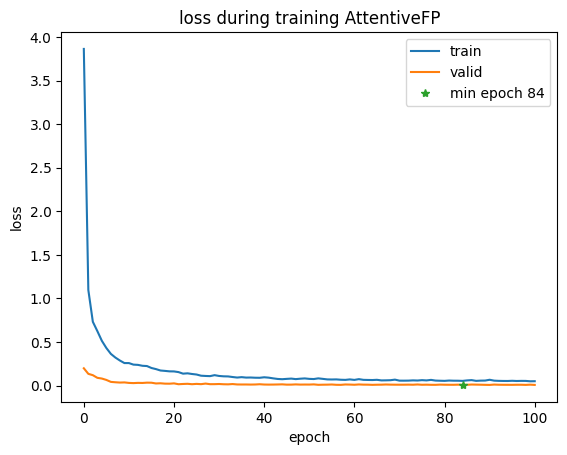

*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.359  &0.201  &0.448  &0.569

*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.971  &2.085  &1.444  &0.823

Epoch:101 [Train] Loss: 0.053 | [Valid] Loss: 0.011	EarlyStopping counter: 17 out of 30
Epoch:102 [Train] Loss: 0.048 | [Valid] Loss: 0.008	EarlyStopping counter: 18 out of 30
Epoch:103 [Train] Loss: 0.048 | [Valid] Loss: 0.009	EarlyStopping counter: 19 out of 30
Epoch:104 [Train] Loss: 0.049 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.008 -> 0.008 | runtime: 0.334 ms
Epoch:105 [Train] Loss: 0.050 | [Valid] Loss: 0.009	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.049 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.008 -> 0.007 | runtime: 0.324 ms
Epoch:107 [Train] Loss: 0.045 | [Valid] Loss: 0.008	EarlyStopping counter: 1 out of 30
Epoch:108 [Train] Loss: 0.050 | [Valid] Loss: 0.010	EarlyStopping counter: 2 out of 30
Epoch:109 [Train] Loss: 0.050 | [Valid]

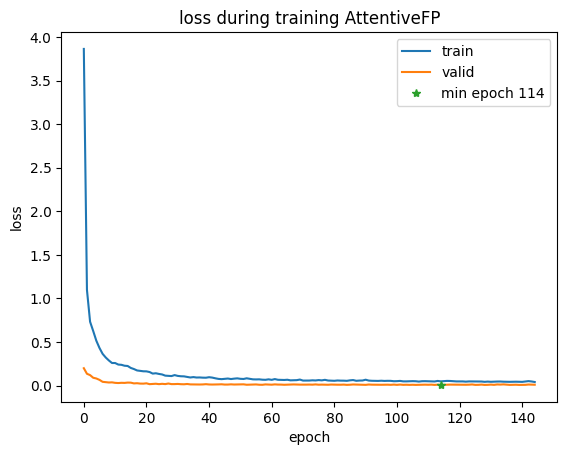

load pretrained model from  uw/AttentiveFP_MT_0.pt
[Test] Loss: nan
*************** Caco2_Wang ***************
  MAE     MSE     RMSE    R2
&0.365  &0.201  &0.448  &0.684


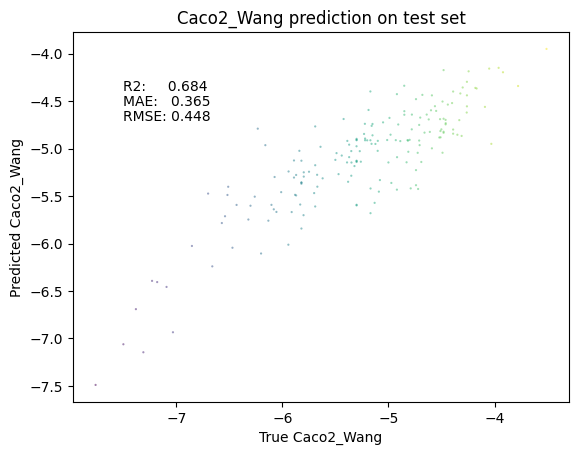


*************** HydrationFreeEnergy_FreeSolv ***************
  MAE     MSE     RMSE    R2
&0.782  &1.379  &1.174  &0.916


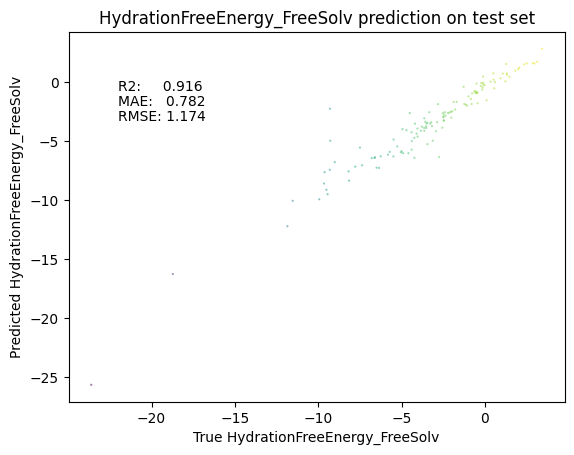



--> Train status saved at uw/AttentiveFP_MT_0.yml
Finished training



In [137]:
perfs = [] # a list to store the performance outputted from the model
for i in range(repeat_time): # run the same model for repeat_time times
    print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
    save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
    print(' | save dir: ', save_dir)
    config['model_path']  = save_dir + '.pt'
    config['config_path'] = save_dir + '.yml'
    config['uncertainty_weight'] = True
    # try: # try open yml file, if file exists, and no need train
    #     with open(config['config_path'], 'r') as f: data = yaml.safe_load(f)
    #     if data != None: p = yml_report(data); print('--> pre data loaded')
    # except:  # model was not trained yet, train the model

    models = PRED(**config); p = models.train(trn_l, val_l, tst_l)

In [129]:
def scale(trains_, valids_, tests_, scale_task={}):
    """
    Aim: scale train, valid, and test especially for regression task
    :param trains_, valids_, tests_: pd.dataframe, the unscaled data
    :param scale_task:               dict or bool, specify which task to scale
           if bool, True: scale all columns; False: no scale, return same data
           if dict, should be like {name1: True, name2: False}
                                or {name1: [min, max]}
    Return scaled train, valid, test, scale_dict
    """
    trains, valids, tests = trains_.copy(), valids_.copy(), tests_.copy()
    if type(scale_task) == bool:  # initialization is a boolean instead of dict
        if scale_task == False:
            print('No scaling'); return trains, valids, tests, None
        else: scale_task = {} # scale for all tasks, the same as len(scale_task) == 0
    # type(x) == bool
    if isinstance(scale_task, dict): # initialization is a dictionary
        if len(scale_task) == 0: # no info in dict,default scale all columns
            ignores = ['Drug', 'smiles', 'SMILES', 'Smiles', 'selfies']
            for col in trains.columns:

                if col in ignores:
                    print('no handle', col)
                    pass  # do not scale for smies or selfies
                else:
                    print(col)

                    scale_task[col] = True # set true for all scalable columns
                    print('scaletask:', scale_task)
        # else: # check if all false, then no need to scale
        #     all_false = False
    all_false = True

    dict_scale = {}
    for col in scale_task.keys(): # if col in data yet not in scale_task: do not scale
        # if col == 'Drug': pass
        scale_info = scale_task[col] # could be bool, or list
        if scale_info == True or isinstance(scale_info, list): # need scale here
            all_false = False # at least one col need scaling
            print('\nSTART scaling train valid test data set: ')
            if isinstance(scale_info, list): # if empty, need cal
                try: mi, ma = scale_info[0],scale_info[1]
                except:
                    print(f'invalid list {scale_info}, recal')
                    scale_info = True # set scale_info to recal
            elif scale_info == True: # need to calculate min and max
                mi = min(trains[col].min(), valids[col].min(), tests[col].min())
                ma = max(trains[col].max(), valids[col].max(), tests[col].max())
                # dict_scale[col] = [float(mi), float(ma)] # update dict_scale
            print(f'---> scale {col} | min {mi:.3f} | max {ma:.3f}')
            dict_scale[col] = [float(mi), float(ma)] # update dict_scale
            delta_here = ma - mi
            if delta_here == 0:
                print(f'cannot divide 0, no scale for {col}'); break
            trains[col] = (trains[col] - mi) / delta_here
            valids[col] = (valids[col] - mi) / delta_here
            tests[col]  = (tests[col]  - mi) / delta_here
        elif scale_info == False: pass # do not scale or update dict_scale
    if len(dict_scale) == 0: dict_scale = None
    if all_false == True: # did not scale
        assert dict_scale == None
        print('No scaling for all tasks', end=" ")
    print('Finished scaling process | dict_scale:', dict_scale, '\n')
    return trains, valids, tests, dict_scale


trn, val, tst, dict_scale = scale(trn, val, tst, scale_task={})
trn

no handle Drug
Caco2_Wang
scaletask: {'Caco2_Wang': True}
HydrationFreeEnergy_FreeSolv
scaletask: {'Caco2_Wang': True, 'HydrationFreeEnergy_FreeSolv': True}

START scaling train valid test data set: 
---> scale Caco2_Wang | min -7.760 | max -3.510

START scaling train valid test data set: 
---> scale HydrationFreeEnergy_FreeSolv | min 0.000 | max 1.000
Finished scaling process | dict_scale: {'Caco2_Wang': [-7.7600002, -3.51], 'HydrationFreeEnergy_FreeSolv': [0.0, 1.0]} 



Drug  Caco2_Wang  \
0               Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2    0.362353   
1                      C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C    0.917647   
2     COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...    0.863529   
3     C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...    0.687059   
4     C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...    0.385882   
...                                                 ...         ...   
1075                                      CCCCC/C=C/C=O         NaN   
1076                   CCOP(=S)(OCC)Oc1cc(C)nc(C(C)C)n1         NaN   
1077                                     O=Cc1ccc(O)cc1         NaN   
1078                                          CCCCCCCCl         NaN   
1079                                           C1COCCO1         NaN   

      HydrationFreeEnergy_FreeSolv  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
1075                      0.762630  
1076                      0.657093  
1077                      0.575779  
1078                      0.891349  
1079                      0.706228  

[1080 rows x 3 columns]

#### Test single train scaling effects

##### Test single task scaling effect

In [11]:
names_reg

['Caco2_Wang',
 'Lipophilicity_AstraZeneca',
 'HydrationFreeEnergy_FreeSolv',
 'Solubility_AqSolDB',
 'LD50_Zhu']

Found local copy...
Loading...
Done!


collect data for:  ['Solubility_AqSolDB']
path: Solubility_AqSolDB_no_scale already exists





info will be saved at Solubility_AqSolDB_no_scale
No scaling
MLP
---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED

Run # 0 for MLP ST	 pre data loaded
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.907 +/- 0.000 | 1.242 +/- 0.000 | 0.716 +/- 0.000 | 


Run # 1 for MLP ST	 pre data loaded
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.907 +/- 0.000 | 1.246 +/- 0.000 | 0.714 +/- 0.000 | 


Run # 2 for MLP ST	 pre data loaded
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.916 +/- 0.000 | 1

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 6988 out of 6988 | elapsed:    8.0s finished


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 952 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 998 out of 998 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 1996 out of 1996 | elapsed:    2.2s finished



Run # 0 for AttentiveFP ST	 pre data loaded
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.662 +/- 0.000 | 0.986 +/- 0.000 | 0.821 +/- 0.000 | 


Run # 1 for AttentiveFP ST	 pre data loaded
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.667 +/- 0.000 | 0.989 +/- 0.000 | 0.820 +/- 0.000 | 


Run # 2 for AttentiveFP ST	 pre data loaded
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.654 +/- 0.000 | 1.010 +/- 0.000 | 0.812 +/- 0.000 | 

repeated num # 3 idx 0 has the lowest loss from [0.972718277053986, 0.9788913612136382, 1.0192410845555857]
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.661 +/- 0.005 | 0.995 +/- 0.010 | 0.818 +/- 0.004 | 
 idx 0: | 0.662 +/- 0.000 | 0.986 +/- 0.000 | 0.821 +/- 0.000 | 

GIN
---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  GIN
--> preparing d

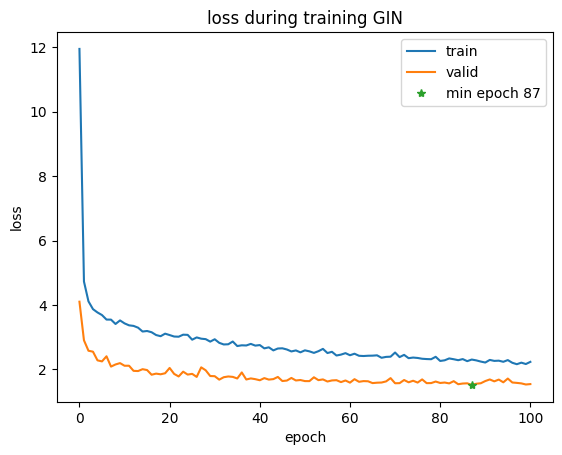

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.879  &1.543  &1.242  &0.709

Epoch:101 [Train] Loss: 2.213 | [Valid] Loss: 1.537	EarlyStopping counter: 14 out of 30
Epoch:102 [Train] Loss: 2.209 | [Valid] Loss: 1.514	SAVE MODEL: loss: 1.517 -> 1.514 | runtime: 2.064 ms
Epoch:103 [Train] Loss: 2.111 | [Valid] Loss: 1.528	EarlyStopping counter: 1 out of 30
Epoch:104 [Train] Loss: 2.162 | [Valid] Loss: 1.588	EarlyStopping counter: 2 out of 30
Epoch:105 [Train] Loss: 2.140 | [Valid] Loss: 1.549	EarlyStopping counter: 3 out of 30
Epoch:106 [Train] Loss: 2.173 | [Valid] Loss: 1.539	EarlyStopping counter: 4 out of 30
Epoch:107 [Train] Loss: 2.175 | [Valid] Loss: 1.531	EarlyStopping counter: 5 out of 30
Epoch:108 [Train] Loss: 2.107 | [Valid] Loss: 1.542	EarlyStopping counter: 6 out of 30
Epoch:109 [Train] Loss: 2.152 | [Valid] Loss: 1.531	EarlyStopping counter: 7 out of 30
Epoch:110 [Train] Loss: 2.152 | [Valid] Loss: 1.502	SAVE MODEL: loss: 1.514 -> 1.502 |

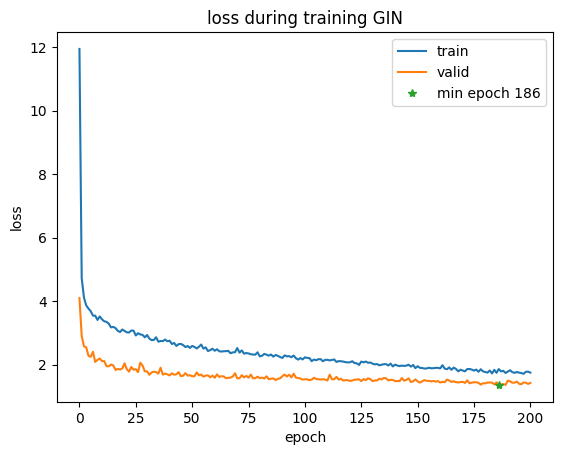

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.854  &1.425  &1.194  &0.731

Epoch:201 [Train] Loss: 1.729 | [Valid] Loss: 1.460	EarlyStopping counter: 15 out of 30
Epoch:202 [Train] Loss: 1.752 | [Valid] Loss: 1.403	EarlyStopping counter: 16 out of 30
Epoch:203 [Train] Loss: 1.769 | [Valid] Loss: 1.402	EarlyStopping counter: 17 out of 30
Epoch:204 [Train] Loss: 1.733 | [Valid] Loss: 1.443	EarlyStopping counter: 18 out of 30
Epoch:205 [Train] Loss: 1.688 | [Valid] Loss: 1.385	EarlyStopping counter: 19 out of 30
Epoch:206 [Train] Loss: 1.730 | [Valid] Loss: 1.381	EarlyStopping counter: 20 out of 30
Epoch:207 [Train] Loss: 1.739 | [Valid] Loss: 1.358	SAVE MODEL: loss: 1.362 -> 1.358 | runtime: 2.034 ms
Epoch:208 [Train] Loss: 1.696 | [Valid] Loss: 1.362	EarlyStopping counter: 1 out of 30
Epoch:209 [Train] Loss: 1.699 | [Valid] Loss: 1.390	EarlyStopping counter: 2 out of 30
Epoch:210 [Train] Loss: 1.736 | [Valid] Loss: 1.386	EarlyStopping counter: 3 out 

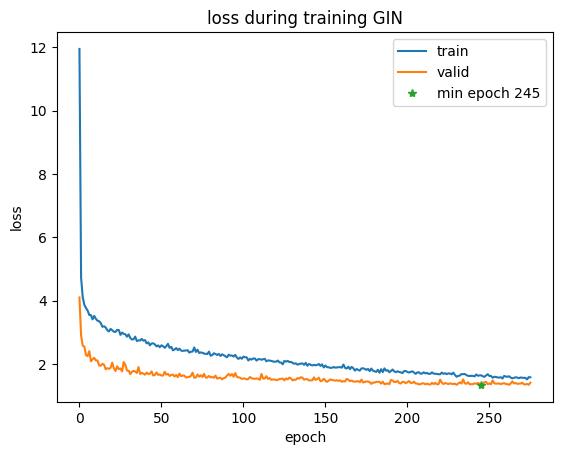

Pretrained model loaded
load pretrained model from  Solubility_AqSolDB_no_scale/GIN_ST_1.pt
[Test] Loss: 1.296
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.805  &1.296  &1.138  &0.761


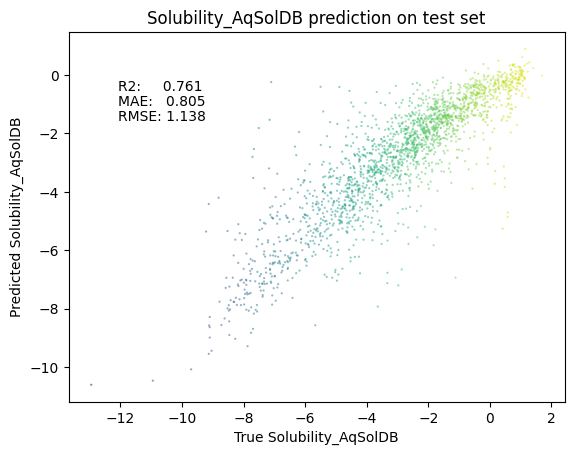



--> Train status saved at Solubility_AqSolDB_no_scale/GIN_ST_1.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.805 +/- 0.000 | 1.138 +/- 0.000 | 0.761 +/- 0.000 | 


Run # 2 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 11.199 | [Valid] Loss: 3.810	SAVE MODEL: loss: inf -> 3.810 | runtime: 2.059 ms
Epoch:1 [Train] Loss: 4.612 | [Valid] Loss: 3.011	SAVE MODEL: loss: 3.810 -> 3.011 | runtime: 2.056 ms
Epoch:2 [Train] Loss: 4.015 | [Valid] Loss: 2.674	SAVE MODEL: loss: 3.011 -> 2.674 | runtime: 2.060 ms
Epoch:3 [Train] Loss: 3.873 | [Valid] Loss: 2.358	SAVE MODEL: loss: 2.674 -> 2.358 | runtime: 2.042 ms
Epoch:4 [Train] Loss: 3.667 | [Valid] Loss: 2.351	SAVE MODEL: loss: 2.358 -> 2.351 | runtime: 2.032 ms
Epoch

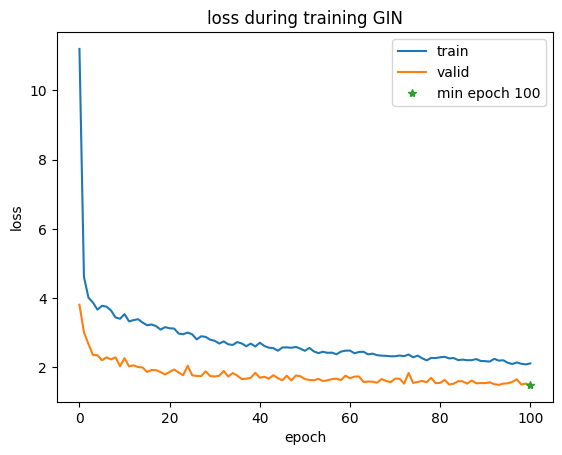

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.861  &1.494  &1.222  &0.719

Epoch:101 [Train] Loss: 2.080 | [Valid] Loss: 1.505	EarlyStopping counter: 1 out of 30
Epoch:102 [Train] Loss: 2.117 | [Valid] Loss: 1.549	EarlyStopping counter: 2 out of 30
Epoch:103 [Train] Loss: 2.134 | [Valid] Loss: 1.530	EarlyStopping counter: 3 out of 30
Epoch:104 [Train] Loss: 2.014 | [Valid] Loss: 1.483	SAVE MODEL: loss: 1.494 -> 1.483 | runtime: 2.036 ms
Epoch:105 [Train] Loss: 2.086 | [Valid] Loss: 1.638	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 2.182 | [Valid] Loss: 1.614	EarlyStopping counter: 2 out of 30
Epoch:107 [Train] Loss: 2.065 | [Valid] Loss: 1.487	EarlyStopping counter: 3 out of 30
Epoch:108 [Train] Loss: 2.073 | [Valid] Loss: 1.503	EarlyStopping counter: 4 out of 30
Epoch:109 [Train] Loss: 2.133 | [Valid] Loss: 1.586	EarlyStopping counter: 5 out of 30
Epoch:110 [Train] Loss: 2.084 | [Valid] Loss: 1.516	EarlyStopping counter: 6 out of 30


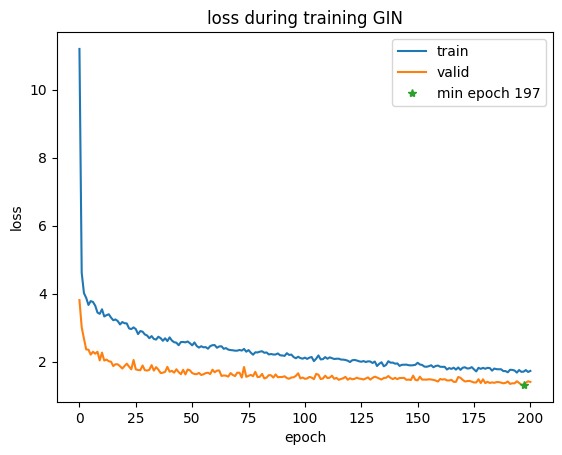

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.831  &1.401  &1.183  &0.736

Epoch:201 [Train] Loss: 1.704 | [Valid] Loss: 1.427	EarlyStopping counter: 4 out of 30
Epoch:202 [Train] Loss: 1.718 | [Valid] Loss: 1.440	EarlyStopping counter: 5 out of 30
Epoch:203 [Train] Loss: 1.675 | [Valid] Loss: 1.400	EarlyStopping counter: 6 out of 30
Epoch:204 [Train] Loss: 1.733 | [Valid] Loss: 1.382	EarlyStopping counter: 7 out of 30
Epoch:205 [Train] Loss: 1.712 | [Valid] Loss: 1.449	EarlyStopping counter: 8 out of 30
Epoch:206 [Train] Loss: 1.699 | [Valid] Loss: 1.415	EarlyStopping counter: 9 out of 30
Epoch:207 [Train] Loss: 1.703 | [Valid] Loss: 1.371	EarlyStopping counter: 10 out of 30
Epoch:208 [Train] Loss: 1.717 | [Valid] Loss: 1.367	EarlyStopping counter: 11 out of 30
Epoch:209 [Train] Loss: 1.697 | [Valid] Loss: 1.387	EarlyStopping counter: 12 out of 30
Epoch:210 [Train] Loss: 1.670 | [Valid] Loss: 1.373	EarlyStopping counter: 13 out of 30
Epoch:211 [Tra

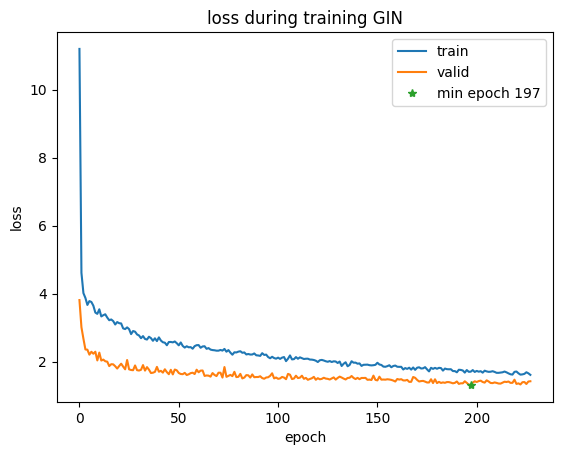

Pretrained model loaded
load pretrained model from  Solubility_AqSolDB_no_scale/GIN_ST_2.pt
[Test] Loss: 1.286
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.794  &1.286  &1.134  &0.763


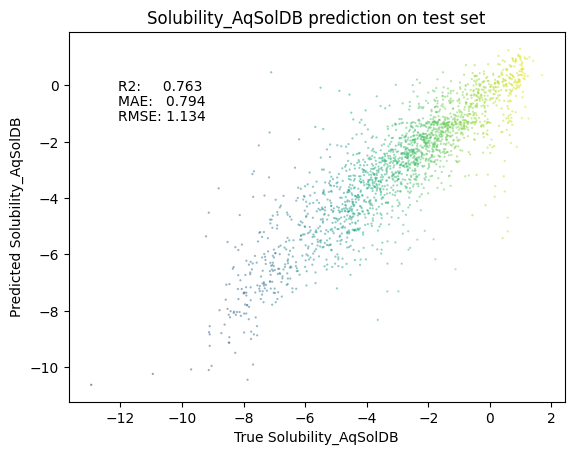



--> Train status saved at Solubility_AqSolDB_no_scale/GIN_ST_2.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.794 +/- 0.000 | 1.134 +/- 0.000 | 0.763 +/- 0.000 | 

repeated num # 3 idx 2 has the lowest loss from [1.3352433818136762, 1.2959512699104263, 1.286430729653888]
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.806 +/- 0.010 | 1.143 +/- 0.009 | 0.759 +/- 0.004 | 
 idx 2: | 0.794 +/- 0.000 | 1.134 +/- 0.000 | 0.763 +/- 0.000 | 

RNN
---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN

Run # 0 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 6.811 | [Valid] Loss: 4.747	SAVE MODEL: loss: inf -> 4.747 | runtime: 1.384 ms
Epoch:1 [Train] Loss: 3.641 | [Valid] Loss: 2.687	SAVE MODEL: loss: 4.747 -

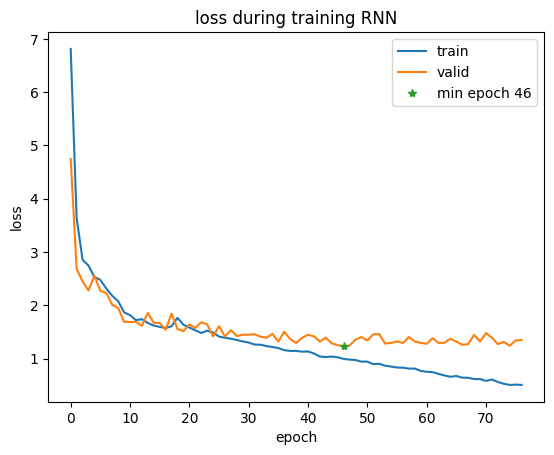

load pretrained model from  Solubility_AqSolDB_no_scale/RNN_ST_0.pt
[Test] Loss: 1.295
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.801  &1.295  &1.138  &0.761


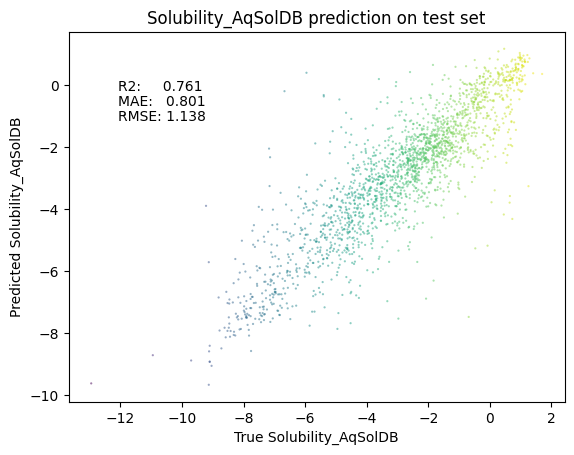



--> Train status saved at Solubility_AqSolDB_no_scale/RNN_ST_0.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.801 +/- 0.000 | 1.138 +/- 0.000 | 0.761 +/- 0.000 | 


Run # 1 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 6.532 | [Valid] Loss: 4.043	SAVE MODEL: loss: inf -> 4.043 | runtime: 1.329 ms
Epoch:1 [Train] Loss: 3.346 | [Valid] Loss: 2.624	SAVE MODEL: loss: 4.043 -> 2.624 | runtime: 1.331 ms
Epoch:2 [Train] Loss: 2.823 | [Valid] Loss: 2.455	SAVE MODEL: loss: 2.624 -> 2.455 | runtime: 1.288 ms
Epoch:3 [Train] Loss: 2.663 | [Valid] Loss: 2.631	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 2.552 | [Valid] Loss: 2.370	SAVE MODEL: loss: 2.455 -> 2.370 | runtime: 1.330 ms
Epoch:5 [Train] Loss: 2.354 | [Valid] Loss: 2.165	SAVE MODEL: loss: 2.370 -> 2.165 | runtime: 1.280 ms
Epoch:6 [Train] Loss: 2.311 | [Valid] Loss: 2.648	EarlyStopping counter: 1 out 

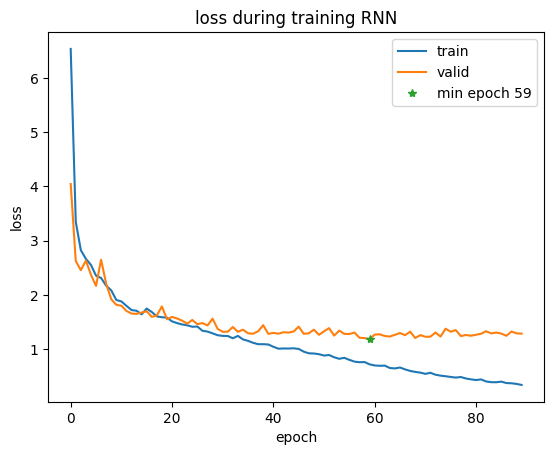

load pretrained model from  Solubility_AqSolDB_no_scale/RNN_ST_1.pt
[Test] Loss: 1.192
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.747  &1.192  &1.092  &0.780


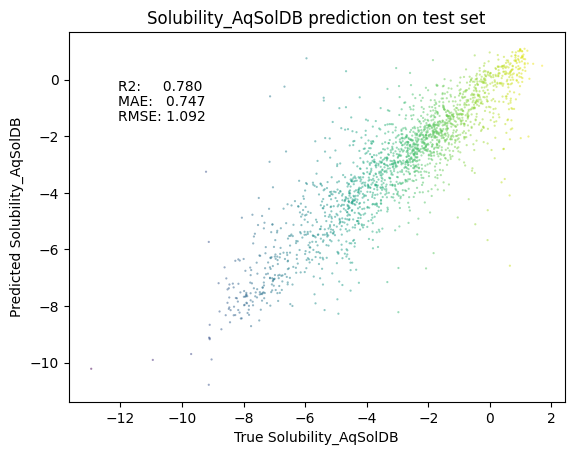



--> Train status saved at Solubility_AqSolDB_no_scale/RNN_ST_1.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.747 +/- 0.000 | 1.092 +/- 0.000 | 0.780 +/- 0.000 | 


Run # 2 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 6.962 | [Valid] Loss: 4.931	SAVE MODEL: loss: inf -> 4.931 | runtime: 1.323 ms
Epoch:1 [Train] Loss: 3.689 | [Valid] Loss: 2.793	SAVE MODEL: loss: 4.931 -> 2.793 | runtime: 1.281 ms
Epoch:2 [Train] Loss: 2.879 | [Valid] Loss: 2.388	SAVE MODEL: loss: 2.793 -> 2.388 | runtime: 1.307 ms
Epoch:3 [Train] Loss: 2.763 | [Valid] Loss: 2.279	SAVE MODEL: loss: 2.388 -> 2.279 | runtime: 1.324 ms
Epoch:4 [Train] Loss: 2.587 | [Valid] Loss: 2.273	SAVE MODEL: loss: 2.279 -> 2.273 | runtime: 1.312 ms
Epoch:5 [Train] Loss: 2.442 | [Valid] Loss: 2.219	SAVE MODEL: loss: 2.273 -> 2.219 | runtime: 1.294 ms
Epoch:6 [Train] Loss: 2.304 | [Valid] Loss: 2.141	SAVE MODEL:

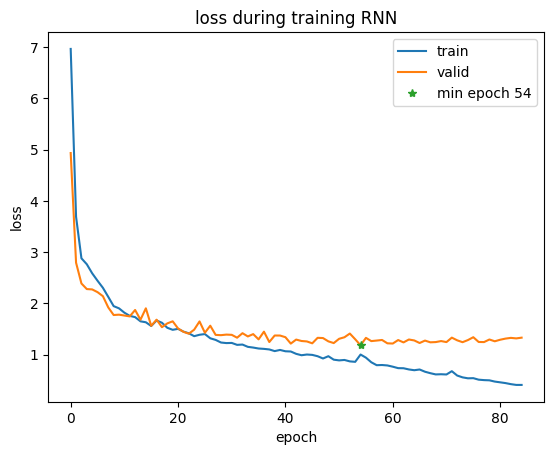

load pretrained model from  Solubility_AqSolDB_no_scale/RNN_ST_2.pt
[Test] Loss: 1.243
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.787  &1.243  &1.115  &0.771


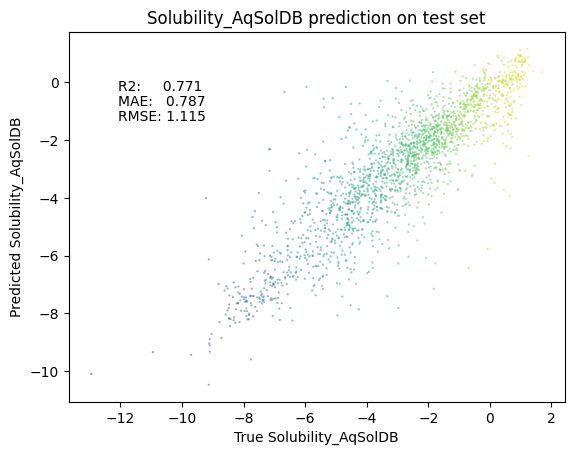



--> Train status saved at Solubility_AqSolDB_no_scale/RNN_ST_2.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.787 +/- 0.000 | 1.115 +/- 0.000 | 0.771 +/- 0.000 | 

repeated num # 3 idx 1 has the lowest loss from [1.2945350062154337, 1.1922192697773477, 1.2432725558538953]
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.778 +/- 0.023 | 1.115 +/- 0.019 | 0.771 +/- 0.008 | 
 idx 1: | 0.747 +/- 0.000 | 1.092 +/- 0.000 | 0.780 +/- 0.000 | 

path: Solubility_AqSolDB_scale is created





info will be saved at Solubility_AqSolDB_scale

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138
Finished scaling process | dict_scale: {'Solubility_AqSolDB': [-13.1719, 2.1376816201]} 

MLP
---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data load

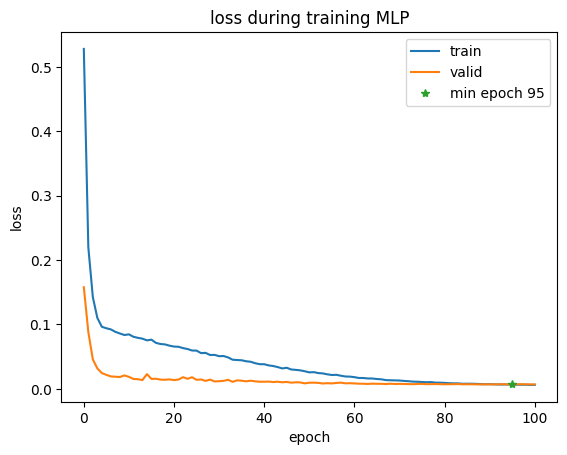

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.925  &1.637  &1.279  &0.692

Epoch:101 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 6 out of 30
Epoch:102 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 7 out of 30
Epoch:103 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 8 out of 30
Epoch:104 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 9 out of 30
Epoch:105 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 10 out of 30
Epoch:106 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 11 out of 30
Epoch:107 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 12 out of 30
Epoch:108 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 13 out of 30
Epoch:109 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 14 out of 30
Epoch:110 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 15 out of 30
Epoch:111 [T

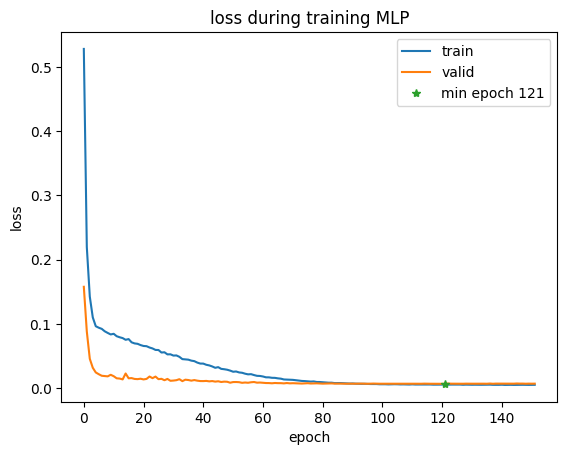

load pretrained model from  Solubility_AqSolDB_scale/MLP_ST_0.pt
[Test] Loss: 0.007
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.910  &1.572  &1.254  &0.710


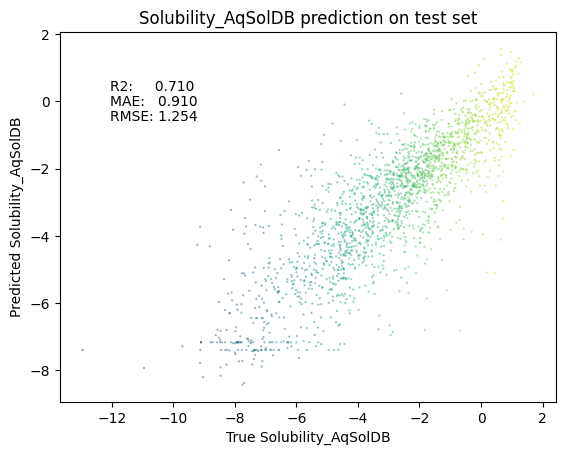



--> Train status saved at Solubility_AqSolDB_scale/MLP_ST_0.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.910 +/- 0.000 | 1.254 +/- 0.000 | 0.710 +/- 0.000 | 


Run # 1 for MLP ST	Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 0.212 | [Valid] Loss: 0.066	SAVE MODEL: loss: inf -> 0.066 | runtime: 0.167 ms
Epoch:1 [Train] Loss: 0.086 | [Valid] Loss: 0.031	SAVE MODEL: loss: 0.066 -> 0.031 | runtime: 0.162 ms
Epoch:2 [Train] Loss: 0.060 | [Valid] Loss: 0.019	SAVE MODEL: loss: 0.031 -> 0.019 | runtime: 0.165 ms
Epoch:3 [Train] Loss: 0.047 | [Valid] Loss: 0.014	SAVE MODEL: loss: 0.019 -> 0.014 | runtime: 0.165 ms
Epoch:4 [Train] Loss: 0.044 | [Valid] Loss: 0.014	SAVE MODEL: loss: 0.014 -> 0.014 | runtime: 0.166 ms
Epoch:5 [Train] Loss: 0.041 | [Valid] Loss: 0.013	SAVE MODEL: loss: 0.014 -> 0.013 | runtime: 0.167 ms
Epoch:6 [Train] Loss: 0.040 | [Valid] Loss: 0.013	SAVE MODEL: loss

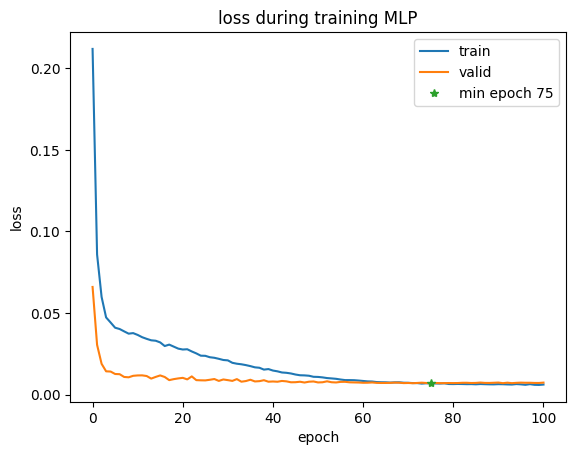

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.952  &1.725  &1.313  &0.675

Epoch:101 [Train] Loss: 0.006 | [Valid] Loss: 0.008	EarlyStopping counter: 26 out of 30
Epoch:102 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 27 out of 30
Epoch:103 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 28 out of 30
Epoch:104 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 29 out of 30
Epoch:105 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at Solubility_AqSolDB_scale/MLP_ST_1.yml
Model parameters:  30817
Train time: 0.168+/-0.005 ms
best epoch: 75, min loss: 0.0070


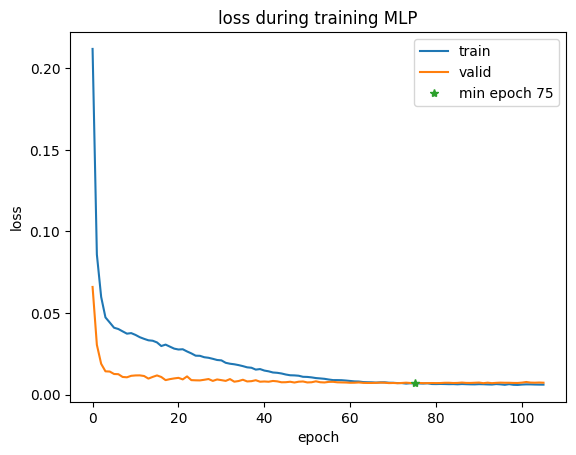

load pretrained model from  Solubility_AqSolDB_scale/MLP_ST_1.pt
[Test] Loss: 0.007
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.931  &1.567  &1.252  &0.711


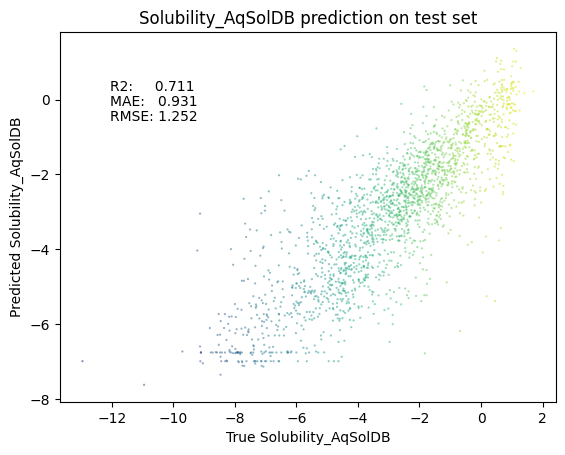



--> Train status saved at Solubility_AqSolDB_scale/MLP_ST_1.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.931 +/- 0.000 | 1.252 +/- 0.000 | 0.711 +/- 0.000 | 


Run # 2 for MLP ST	Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 0.134 | [Valid] Loss: 0.048	SAVE MODEL: loss: inf -> 0.048 | runtime: 0.166 ms
Epoch:1 [Train] Loss: 0.059 | [Valid] Loss: 0.023	SAVE MODEL: loss: 0.048 -> 0.023 | runtime: 0.164 ms
Epoch:2 [Train] Loss: 0.042 | [Valid] Loss: 0.015	SAVE MODEL: loss: 0.023 -> 0.015 | runtime: 0.166 ms
Epoch:3 [Train] Loss: 0.036 | [Valid] Loss: 0.012	SAVE MODEL: loss: 0.015 -> 0.012 | runtime: 0.166 ms
Epoch:4 [Train] Loss: 0.034 | [Valid] Loss: 0.013	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss: 0.034 | [Valid] Loss: 0.011	SAVE MODEL: loss: 0.012 -> 0.011 | runtime: 0.174 ms
Epoch:6 [Train] Loss: 0.032 | [Valid] Loss: 0.012	EarlyStopping counter: 1 out of 30

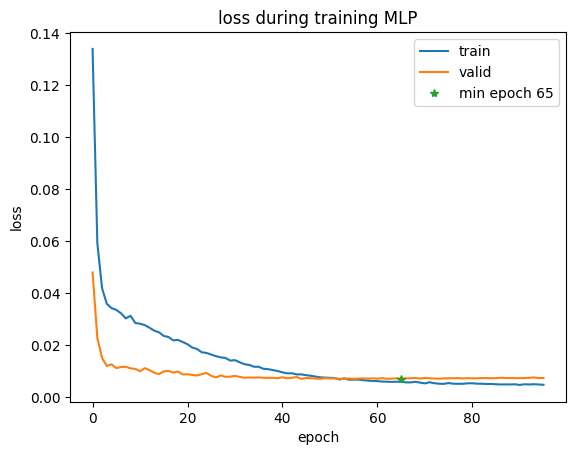

load pretrained model from  Solubility_AqSolDB_scale/MLP_ST_2.pt
[Test] Loss: 0.007
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.918  &1.587  &1.260  &0.708


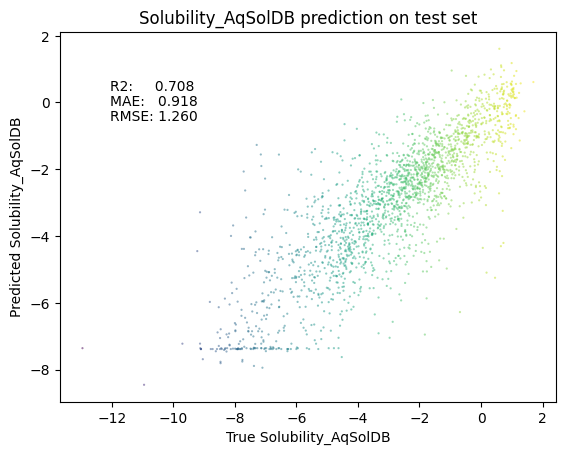



--> Train status saved at Solubility_AqSolDB_scale/MLP_ST_2.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.918 +/- 0.000 | 1.260 +/- 0.000 | 0.708 +/- 0.000 | 

repeated num # 3 idx 1 has the lowest loss from [0.006705403118907569, 0.006687083947873545, 0.0067703555485528555]
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.920 +/- 0.009 | 1.255 +/- 0.003 | 0.710 +/- 0.002 | 
 idx 1: | 0.931 +/- 0.000 | 1.252 +/- 0.000 | 0.711 +/- 0.000 | 

AttentiveFP
---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 652 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 6988 out of 6988 | elapsed:   10.9s finished


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 952 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 998 out of 998 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Done 1660 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 1996 out of 1996 | elapsed:    2.1s finished



Run # 0 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.079 | [Valid] Loss: 0.023	SAVE MODEL: loss: inf -> 0.023 | runtime: 0.366 ms
Epoch:1 [Train] Loss: 0.023 | [Valid] Loss: 0.015	SAVE MODEL: loss: 0.023 -> 0.015 | runtime: 0.290 ms
Epoch:2 [Train] Loss: 0.017 | [Valid] Loss: 0.015	SAVE MODEL: loss: 0.015 -> 0.015 | runtime: 0.301 ms
Epoch:3 [Train] Loss: 0.013 | [Valid] Loss: 0.011	SAVE MODEL: loss: 0.015 -> 0.011 | runtime: 0.300 ms
Epoch:4 [Train] Loss: 0.012 | [Valid] Loss: 0.011	SAVE MODEL: loss: 0.011 -> 0.011 | runtime: 0.297 ms
Epoch:5 [Train] Loss: 0.011 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.011 -> 0.008 | runtime: 0.294 ms
Epoch:6 [Train] Loss: 0.010 | [Valid] Loss: 0.008	EarlyStopping counter: 1 out of 30
Epoch:7 [Train] Loss: 0.009 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.008 -> 0.007 | runtime: 0.299 ms
Epoch:8 [Train] Loss: 0.009 | [Valid] Loss: 0.008	EarlyStopping counter: 1 out of 30

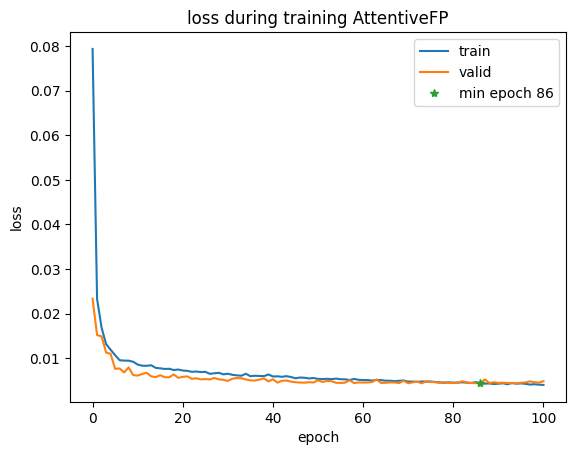

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.744  &1.141  &1.068  &0.785

Epoch:101 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 15 out of 30
Epoch:102 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 16 out of 30
Epoch:103 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 17 out of 30
Epoch:104 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 18 out of 30
Epoch:105 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 19 out of 30
Epoch:106 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 20 out of 30
Epoch:107 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 21 out of 30
Epoch:108 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 22 out of 30
Epoch:109 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 23 out of 30
Epoch:110 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 24 out of 30
Epoch:11

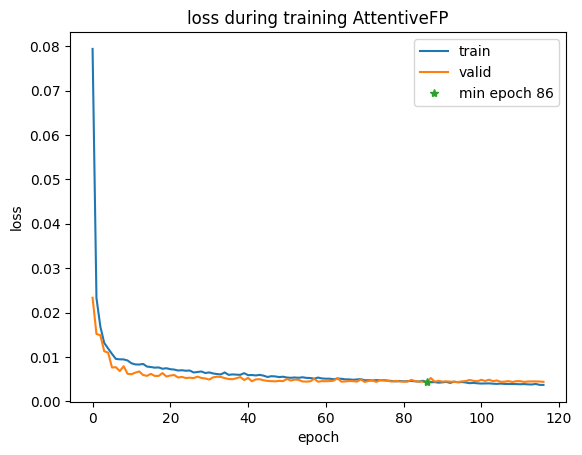

load pretrained model from  Solubility_AqSolDB_scale/AttentiveFP_ST_0.pt
[Test] Loss: 0.004
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.697  &1.029  &1.015  &0.810


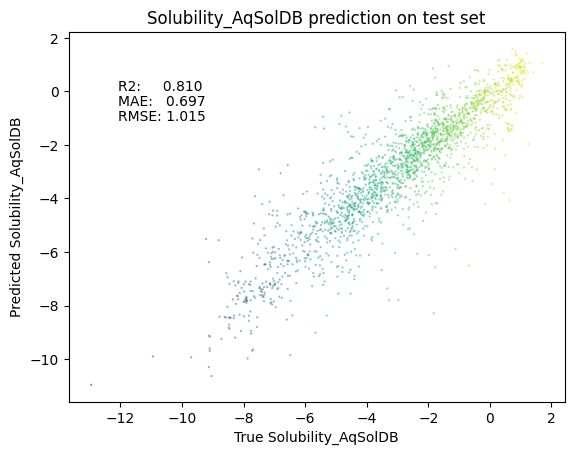



--> Train status saved at Solubility_AqSolDB_scale/AttentiveFP_ST_0.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.697 +/- 0.000 | 1.015 +/- 0.000 | 0.810 +/- 0.000 | 


Run # 1 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.090 | [Valid] Loss: 0.027	SAVE MODEL: loss: inf -> 0.027 | runtime: 0.287 ms
Epoch:1 [Train] Loss: 0.026 | [Valid] Loss: 0.016	SAVE MODEL: loss: 0.027 -> 0.016 | runtime: 0.293 ms
Epoch:2 [Train] Loss: 0.019 | [Valid] Loss: 0.012	SAVE MODEL: loss: 0.016 -> 0.012 | runtime: 0.282 ms
Epoch:3 [Train] Loss: 0.016 | [Valid] Loss: 0.009	SAVE MODEL: loss: 0.012 -> 0.009 | runtime: 0.283 ms
Epoch:4 [Train] Loss: 0.012 | [Valid] Loss: 0.011	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss: 0.012 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.009 -> 0.008 | runtime: 0.285 ms
Epoch:6 [Train] Loss: 0.010 | [Valid] Loss: 0.007	

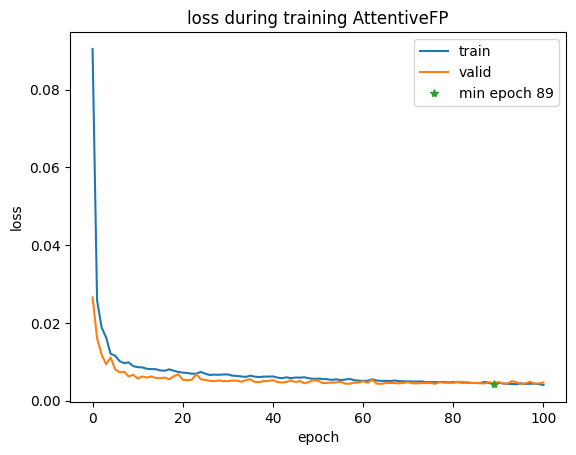

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.729  &1.089  &1.043  &0.795

Epoch:101 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 12 out of 30
Epoch:102 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 13 out of 30
Epoch:103 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 14 out of 30
Epoch:104 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 15 out of 30
Epoch:105 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 16 out of 30
Epoch:106 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 17 out of 30
Epoch:107 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 18 out of 30
Epoch:108 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 19 out of 30
Epoch:109 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 20 out of 30
Epoch:110 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 21 out of 30
Epoch:11

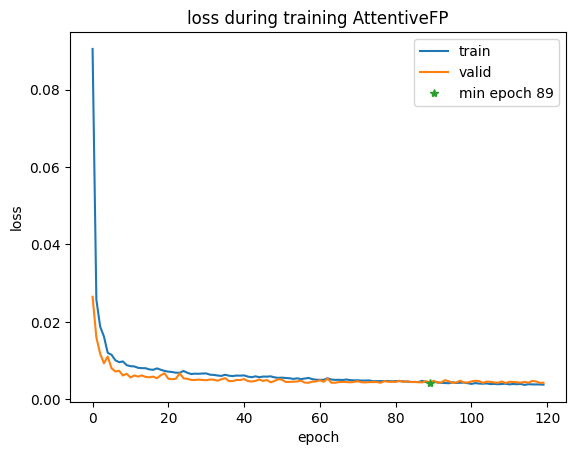

load pretrained model from  Solubility_AqSolDB_scale/AttentiveFP_ST_1.pt
[Test] Loss: 0.004
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.695  &1.014  &1.007  &0.813


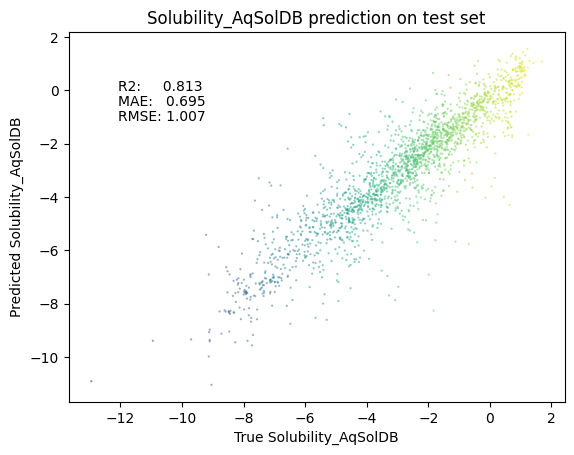



--> Train status saved at Solubility_AqSolDB_scale/AttentiveFP_ST_1.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.695 +/- 0.000 | 1.007 +/- 0.000 | 0.813 +/- 0.000 | 


Run # 2 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.114 | [Valid] Loss: 0.022	SAVE MODEL: loss: inf -> 0.022 | runtime: 0.285 ms
Epoch:1 [Train] Loss: 0.027 | [Valid] Loss: 0.017	SAVE MODEL: loss: 0.022 -> 0.017 | runtime: 0.290 ms
Epoch:2 [Train] Loss: 0.018 | [Valid] Loss: 0.012	SAVE MODEL: loss: 0.017 -> 0.012 | runtime: 0.293 ms
Epoch:3 [Train] Loss: 0.015 | [Valid] Loss: 0.010	SAVE MODEL: loss: 0.012 -> 0.010 | runtime: 0.297 ms
Epoch:4 [Train] Loss: 0.013 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.010 -> 0.008 | runtime: 0.287 ms
Epoch:5 [Train] Loss: 0.012 | [Valid] Loss: 0.010	EarlyStopping counter: 1 out of 30
Epoch:6 [Train] Loss: 0.012 | [Valid] Loss: 0.011	

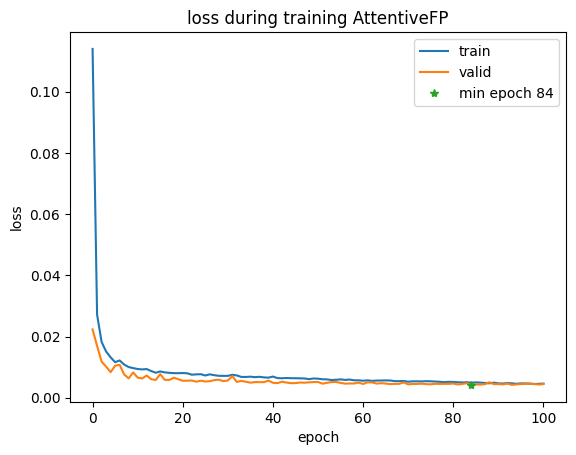

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.716  &1.053  &1.026  &0.802

Epoch:101 [Train] Loss: 0.004 | [Valid] Loss: 0.004	SAVE MODEL: loss: 0.004 -> 0.004 | runtime: 0.279 ms
Epoch:102 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.005 | [Valid] Loss: 0.004	EarlyStopping counter: 3 out of 30
Epoch:105 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 4 out of 30
Epoch:106 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 5 out of 30
Epoch:107 [Train] Loss: 0.005 | [Valid] Loss: 0.005	EarlyStopping counter: 6 out of 30
Epoch:108 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 7 out of 30
Epoch:109 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 8 out of 30
Epoch:110 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 9 out of 30


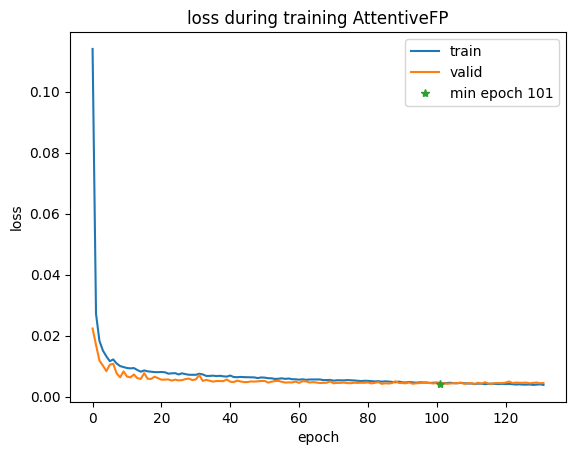

load pretrained model from  Solubility_AqSolDB_scale/AttentiveFP_ST_2.pt
[Test] Loss: 0.004
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.682  &0.994  &0.997  &0.817


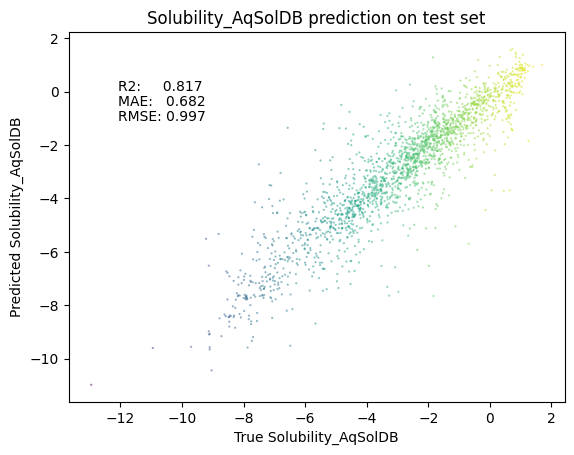



--> Train status saved at Solubility_AqSolDB_scale/AttentiveFP_ST_2.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.682 +/- 0.000 | 0.997 +/- 0.000 | 0.817 +/- 0.000 | 

repeated num # 3 idx 2 has the lowest loss from [0.004391649786479965, 0.004325797255029659, 0.004242001045383289]
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.691 +/- 0.007 | 1.006 +/- 0.007 | 0.813 +/- 0.003 | 
 idx 2: | 0.682 +/- 0.000 | 0.997 +/- 0.000 | 0.817 +/- 0.000 | 

GIN
---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN

Run # 0 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:

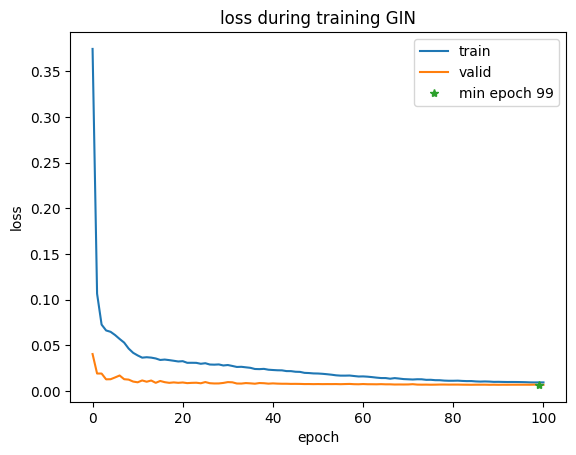

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.893  &1.553  &1.246  &0.707

Epoch:101 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 2 out of 30
Epoch:102 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 3 out of 30
Epoch:103 [Train] Loss: 0.009 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 2.136 ms
Epoch:104 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 1 out of 30
Epoch:105 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 2 out of 30
Epoch:106 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 3 out of 30
Epoch:107 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 4 out of 30
Epoch:108 [Train] Loss: 0.009 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.007 -> 0.006 | runtime: 2.084 ms
Epoch:109 [Train] Loss: 0.009 | [Valid] Loss: 0.006	EarlyStopping counter: 1 out of 30
Epoch:110 [Train] Loss: 0.009 | [Valid] Loss: 0.006	EarlyStopping cou

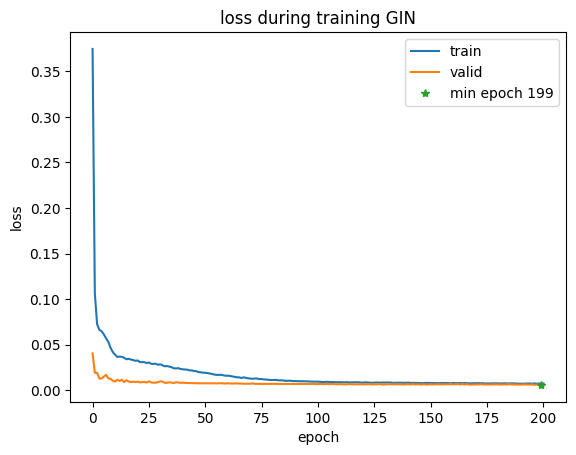

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.830  &1.392  &1.180  &0.738

Epoch:201 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 2 out of 30
Epoch:202 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 3 out of 30
Epoch:203 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 4 out of 30
Epoch:204 [Train] Loss: 0.007 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 2.060 ms
Epoch:205 [Train] Loss: 0.007 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 2.066 ms
Epoch:206 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 1 out of 30
Epoch:207 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 2 out of 30
Epoch:208 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 3 out of 30
Epoch:209 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 4 out of 30
Epoch:210 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping cou

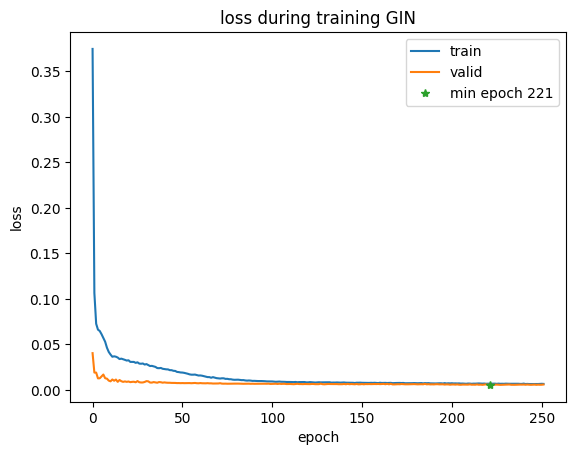

Pretrained model loaded
load pretrained model from  Solubility_AqSolDB_scale/GIN_ST_0.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.793  &1.280  &1.131  &0.764


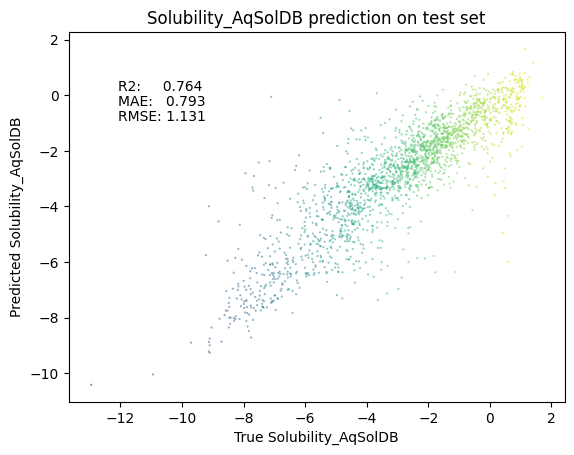



--> Train status saved at Solubility_AqSolDB_scale/GIN_ST_0.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.793 +/- 0.000 | 1.131 +/- 0.000 | 0.764 +/- 0.000 | 


Run # 1 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 0.480 | [Valid] Loss: 0.065	SAVE MODEL: loss: inf -> 0.065 | runtime: 2.068 ms
Epoch:1 [Train] Loss: 0.188 | [Valid] Loss: 0.032	SAVE MODEL: loss: 0.065 -> 0.032 | runtime: 2.071 ms
Epoch:2 [Train] Loss: 0.137 | [Valid] Loss: 0.026	SAVE MODEL: loss: 0.032 -> 0.026 | runtime: 2.104 ms
Epoch:3 [Train] Loss: 0.130 | [Valid] Loss: 0.032	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 0.123 | [Valid] Loss: 0.020	SAVE MODEL: loss: 0.026 -> 0.020 | runtime: 2.109 ms
Epoch:5 [Train] Loss: 0.117

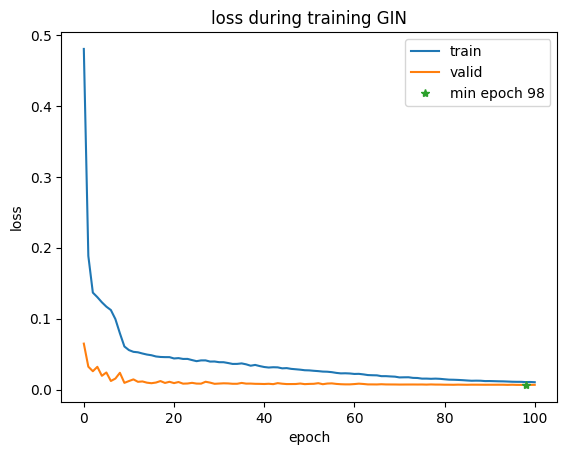

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.916  &1.601  &1.265  &0.698

Epoch:101 [Train] Loss: 0.011 | [Valid] Loss: 0.007	EarlyStopping counter: 3 out of 30
Epoch:102 [Train] Loss: 0.010 | [Valid] Loss: 0.007	EarlyStopping counter: 4 out of 30
Epoch:103 [Train] Loss: 0.010 | [Valid] Loss: 0.007	EarlyStopping counter: 5 out of 30
Epoch:104 [Train] Loss: 0.010 | [Valid] Loss: 0.007	EarlyStopping counter: 6 out of 30
Epoch:105 [Train] Loss: 0.010 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 2.064 ms
Epoch:106 [Train] Loss: 0.010 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 2.081 ms
Epoch:107 [Train] Loss: 0.010 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 2.086 ms
Epoch:108 [Train] Loss: 0.010 | [Valid] Loss: 0.007	EarlyStopping counter: 1 out of 30
Epoch:109 [Train] Loss: 0.010 | [Valid] Loss: 0.007	EarlyStopping counter: 2 out of 30
Epoch:110 [Train] Loss: 0.010 | [Valid] Loss: 0.007

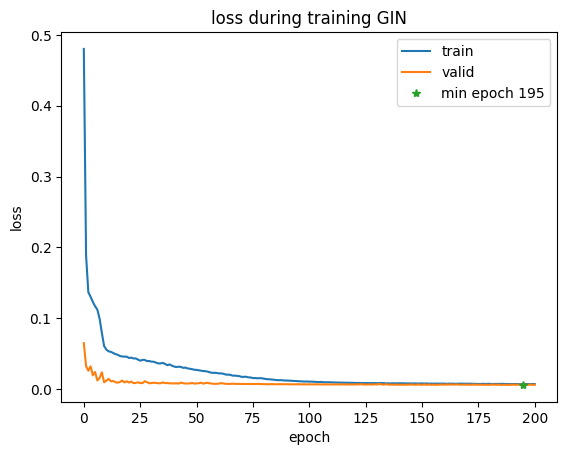

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.827  &1.443  &1.201  &0.728

Epoch:201 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 6 out of 30
Epoch:202 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 7 out of 30
Epoch:203 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 8 out of 30
Epoch:204 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 9 out of 30
Epoch:205 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 10 out of 30
Epoch:206 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 11 out of 30
Epoch:207 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 12 out of 30
Epoch:208 [Train] Loss: 0.007 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 2.058 ms
Epoch:209 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 1 out of 30
Epoch:210 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 2 out of 

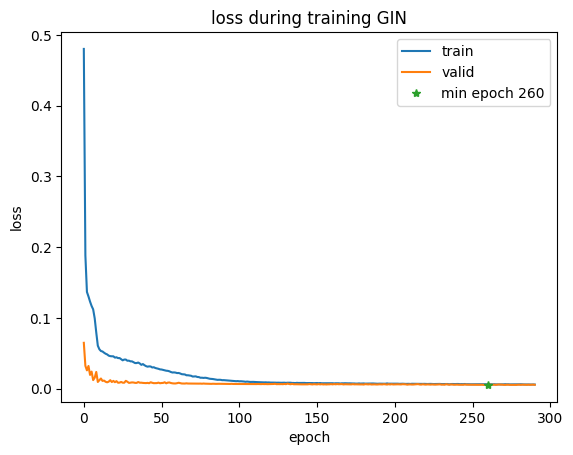

Pretrained model loaded
load pretrained model from  Solubility_AqSolDB_scale/GIN_ST_1.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.777  &1.238  &1.112  &0.772


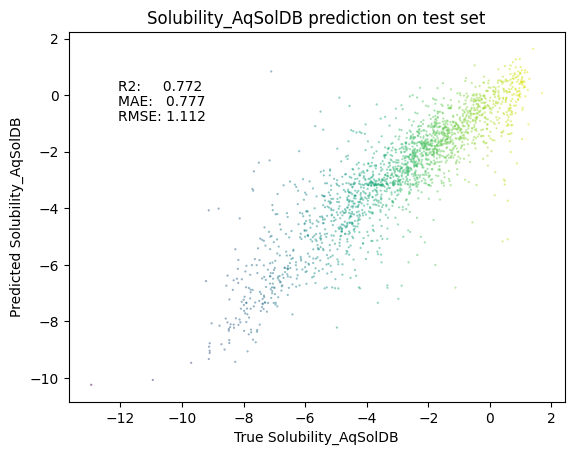



--> Train status saved at Solubility_AqSolDB_scale/GIN_ST_1.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.777 +/- 0.000 | 1.112 +/- 0.000 | 0.772 +/- 0.000 | 


Run # 2 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 0.375 | [Valid] Loss: 0.040	SAVE MODEL: loss: inf -> 0.040 | runtime: 2.059 ms
Epoch:1 [Train] Loss: 0.102 | [Valid] Loss: 0.020	SAVE MODEL: loss: 0.040 -> 0.020 | runtime: 2.067 ms
Epoch:2 [Train] Loss: 0.086 | [Valid] Loss: 0.020	SAVE MODEL: loss: 0.020 -> 0.020 | runtime: 2.089 ms
Epoch:3 [Train] Loss: 0.082 | [Valid] Loss: 0.018	SAVE MODEL: loss: 0.020 -> 0.018 | runtime: 2.098 ms
Epoch:4 [Train] Loss: 0.081 | [Valid] Loss: 0.015	SAVE MODEL: loss: 0.018 -> 0.015 | runtime: 2.077 ms
Epoch:5 [

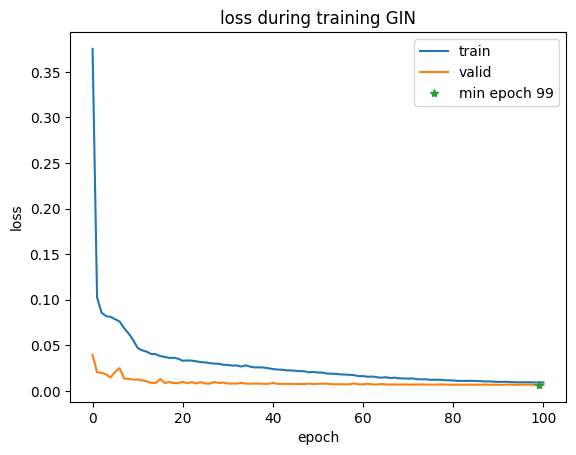

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.918  &1.630  &1.277  &0.693

Epoch:101 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 2 out of 30
Epoch:102 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 3 out of 30
Epoch:103 [Train] Loss: 0.009 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 2.117 ms
Epoch:104 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 1 out of 30
Epoch:105 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 2 out of 30
Epoch:106 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 3 out of 30
Epoch:107 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 4 out of 30
Epoch:108 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 5 out of 30
Epoch:109 [Train] Loss: 0.009 | [Valid] Loss: 0.007	EarlyStopping counter: 6 out of 30
Epoch:110 [Train] Loss: 0.008 | [Valid] Loss: 0.007	EarlyStopping counter: 7 out of 30


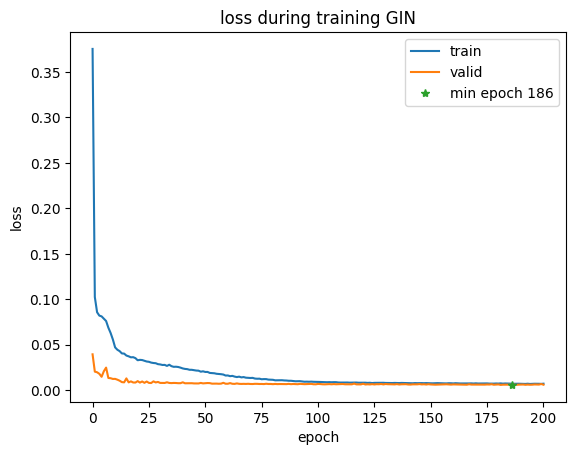

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.826  &1.431  &1.196  &0.730

Epoch:201 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 15 out of 30
Epoch:202 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 16 out of 30
Epoch:203 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 17 out of 30
Epoch:204 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 18 out of 30
Epoch:205 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 19 out of 30
Epoch:206 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 20 out of 30
Epoch:207 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 21 out of 30
Epoch:208 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 22 out of 30
Epoch:209 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 23 out of 30
Epoch:210 [Train] Loss: 0.007 | [Valid] Loss: 0.006	EarlyStopping counter: 24 out of 30
Epoch:21

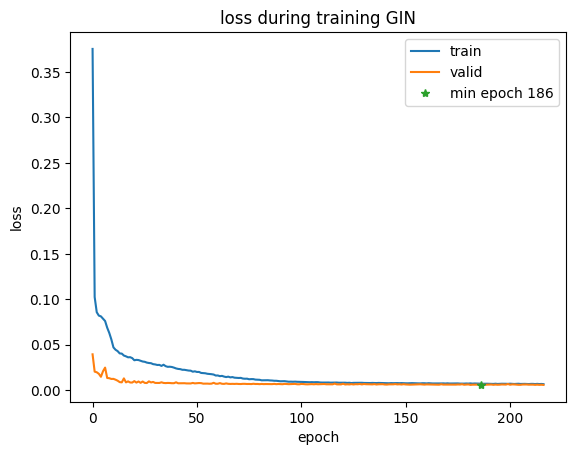

Pretrained model loaded
load pretrained model from  Solubility_AqSolDB_scale/GIN_ST_2.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.799  &1.287  &1.135  &0.763


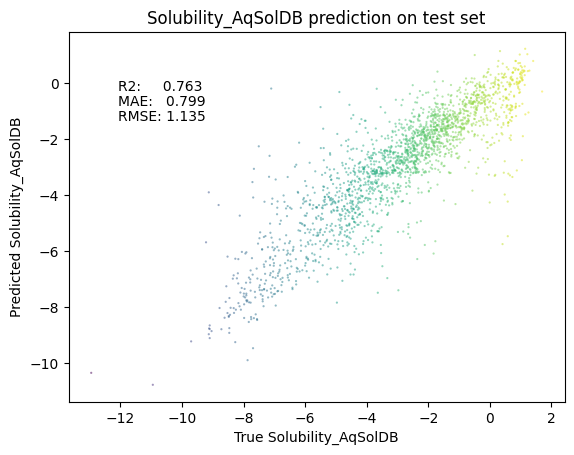



--> Train status saved at Solubility_AqSolDB_scale/GIN_ST_2.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.799 +/- 0.000 | 1.135 +/- 0.000 | 0.763 +/- 0.000 | 

repeated num # 3 idx 1 has the lowest loss from [0.005459754703517906, 0.005280250172039311, 0.005492871802651094]
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.790 +/- 0.009 | 1.126 +/- 0.010 | 0.766 +/- 0.004 | 
 idx 1: | 0.777 +/- 0.000 | 1.112 +/- 0.000 | 0.772 +/- 0.000 | 

RNN
---> loader for ['Solubility_AqSolDB']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN

Run # 0 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 0.056 | [Valid] Loss: 0.022	SAVE MODEL: loss: inf -> 0.022 | runtime: 1.313 ms
Epoch:1 [Train] Loss: 0.021 | [Valid] Loss: 0.019	SAVE MODEL: loss: 0.0

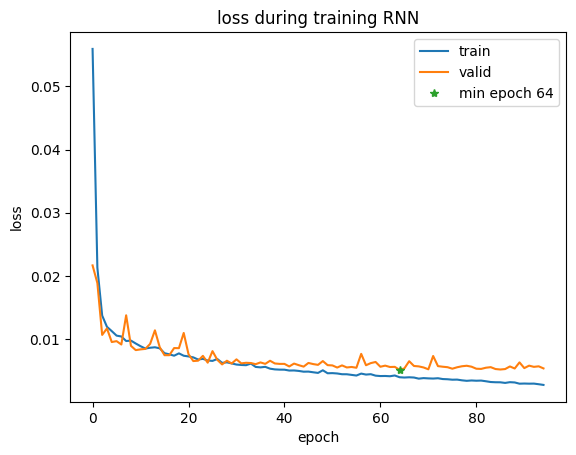

load pretrained model from  Solubility_AqSolDB_scale/RNN_ST_0.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.770  &1.250  &1.118  &0.770


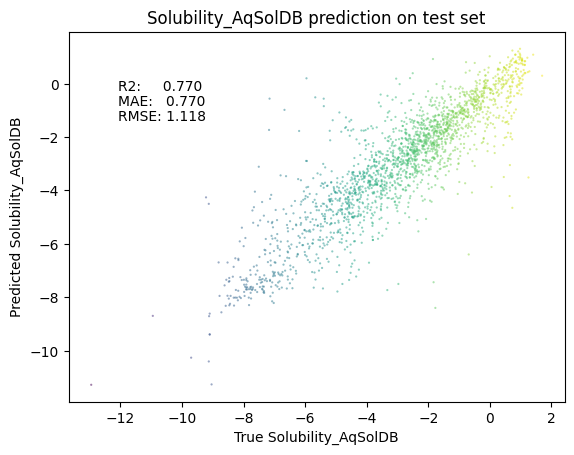



--> Train status saved at Solubility_AqSolDB_scale/RNN_ST_0.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.770 +/- 0.000 | 1.118 +/- 0.000 | 0.770 +/- 0.000 | 


Run # 1 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 0.055 | [Valid] Loss: 0.022	SAVE MODEL: loss: inf -> 0.022 | runtime: 1.352 ms
Epoch:1 [Train] Loss: 0.021 | [Valid] Loss: 0.016	SAVE MODEL: loss: 0.022 -> 0.016 | runtime: 1.279 ms
Epoch:2 [Train] Loss: 0.013 | [Valid] Loss: 0.011	SAVE MODEL: loss: 0.016 -> 0.011 | runtime: 1.289 ms
Epoch:3 [Train] Loss: 0.012 | [Valid] Loss: 0.010	SAVE MODEL: loss: 0.011 -> 0.010 | runtime: 1.301 ms
Epoch:4 [Train] Loss: 0.011 | [Valid] Loss: 0.009	SAVE MODEL: loss: 0.010 -> 0.009 | runtime: 1.311 ms
Epoch:5 [Train] Loss: 0.011 | [Valid] Loss: 0.009	EarlyStopping counter: 1 out of 30
Epoch:6 [Train] Loss: 0.010 | [Valid] Loss: 0.009	SAVE MODEL: loss: 0.009 -> 0.009

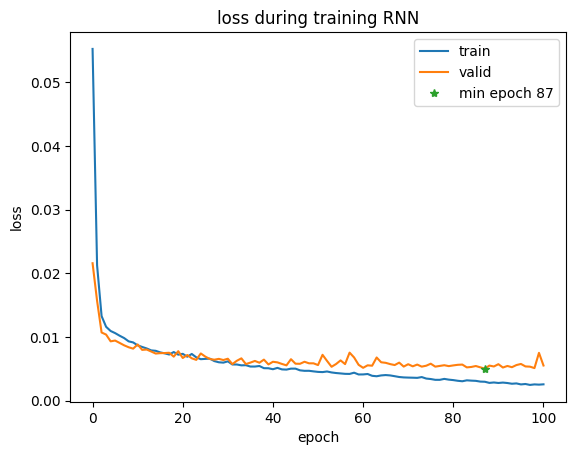

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.807  &1.297  &1.139  &0.756

Epoch:101 [Train] Loss: 0.002 | [Valid] Loss: 0.006	EarlyStopping counter: 14 out of 30
Epoch:102 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 15 out of 30
Epoch:103 [Train] Loss: 0.002 | [Valid] Loss: 0.006	EarlyStopping counter: 16 out of 30
Epoch:104 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 17 out of 30
Epoch:105 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 18 out of 30
Epoch:106 [Train] Loss: 0.002 | [Valid] Loss: 0.006	EarlyStopping counter: 19 out of 30
Epoch:107 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 20 out of 30
Epoch:108 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 21 out of 30
Epoch:109 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 22 out of 30
Epoch:110 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 23 out of 30
Epoch:11

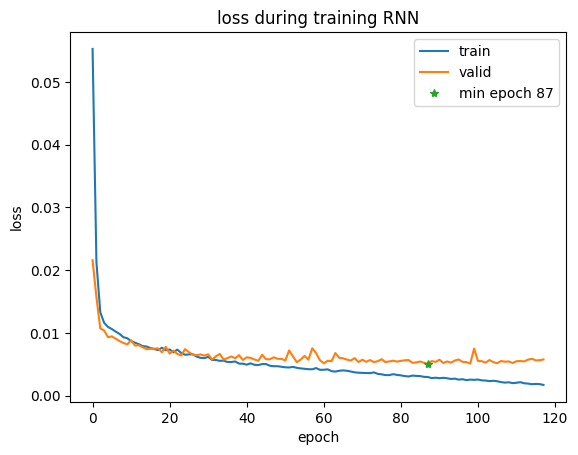

load pretrained model from  Solubility_AqSolDB_scale/RNN_ST_1.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.761  &1.220  &1.105  &0.775


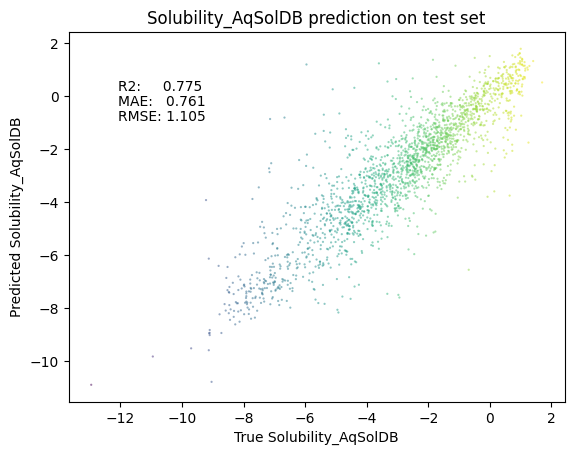



--> Train status saved at Solubility_AqSolDB_scale/RNN_ST_1.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.761 +/- 0.000 | 1.105 +/- 0.000 | 0.775 +/- 0.000 | 


Run # 2 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 0.058 | [Valid] Loss: 0.022	SAVE MODEL: loss: inf -> 0.022 | runtime: 1.263 ms
Epoch:1 [Train] Loss: 0.022 | [Valid] Loss: 0.017	SAVE MODEL: loss: 0.022 -> 0.017 | runtime: 1.273 ms
Epoch:2 [Train] Loss: 0.014 | [Valid] Loss: 0.012	SAVE MODEL: loss: 0.017 -> 0.012 | runtime: 1.330 ms
Epoch:3 [Train] Loss: 0.012 | [Valid] Loss: 0.010	SAVE MODEL: loss: 0.012 -> 0.010 | runtime: 1.344 ms
Epoch:4 [Train] Loss: 0.011 | [Valid] Loss: 0.011	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss: 0.011 | [Valid] Loss: 0.009	SAVE MODEL: loss: 0.010 -> 0.009 | runtime: 1.338 ms
Epoch:6 [Train] Loss: 0.011 | [Valid] Loss: 0.010	EarlyStopping counter: 1 out of 

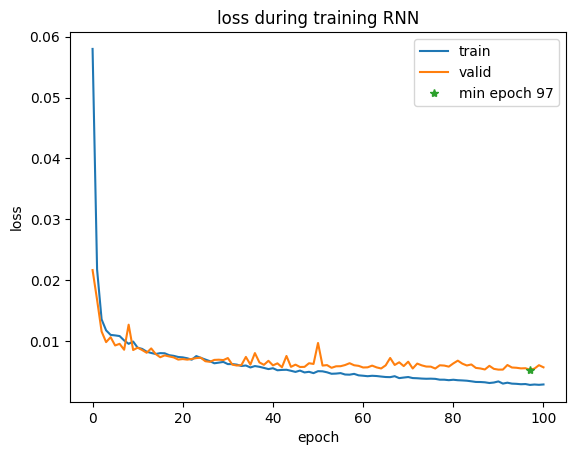

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.794  &1.326  &1.152  &0.750

Epoch:101 [Train] Loss: 0.003 | [Valid] Loss: 0.006	EarlyStopping counter: 4 out of 30
Epoch:102 [Train] Loss: 0.003 | [Valid] Loss: 0.006	EarlyStopping counter: 5 out of 30
Epoch:103 [Train] Loss: 0.003 | [Valid] Loss: 0.006	EarlyStopping counter: 6 out of 30
Epoch:104 [Train] Loss: 0.003 | [Valid] Loss: 0.006	EarlyStopping counter: 7 out of 30
Epoch:105 [Train] Loss: 0.003 | [Valid] Loss: 0.006	EarlyStopping counter: 8 out of 30
Epoch:106 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 9 out of 30
Epoch:107 [Train] Loss: 0.002 | [Valid] Loss: 0.006	EarlyStopping counter: 10 out of 30
Epoch:108 [Train] Loss: 0.002 | [Valid] Loss: 0.006	EarlyStopping counter: 11 out of 30
Epoch:109 [Train] Loss: 0.002 | [Valid] Loss: 0.006	EarlyStopping counter: 12 out of 30
Epoch:110 [Train] Loss: 0.002 | [Valid] Loss: 0.006	EarlyStopping counter: 13 out of 30
Epoch:111 [Tra

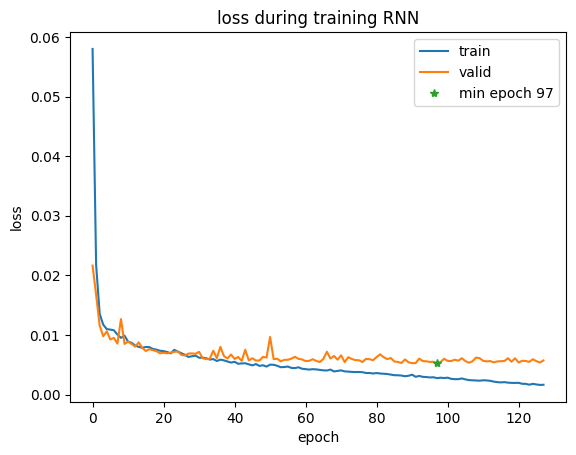

load pretrained model from  Solubility_AqSolDB_scale/RNN_ST_2.pt
[Test] Loss: 0.005
*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.772  &1.187  &1.089  &0.781


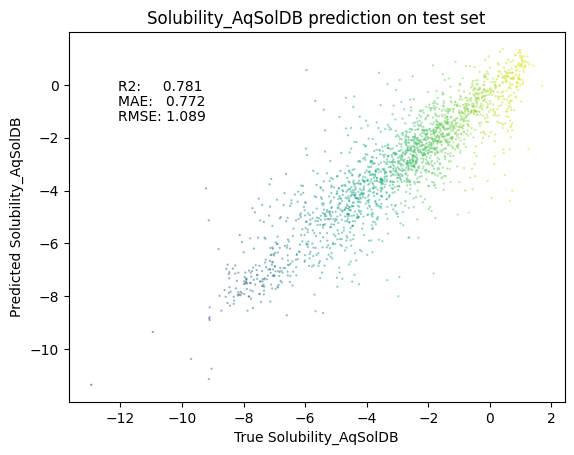

Found local copy...
Loading...




--> Train status saved at Solubility_AqSolDB_scale/RNN_ST_2.yml
Finished training

******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.772 +/- 0.000 | 1.089 +/- 0.000 | 0.781 +/- 0.000 | 

repeated num # 3 idx 2 has the lowest loss from [0.005334475729054583, 0.0052061934389905605, 0.005062424885724972]
******************** Solubility_AqSolDB ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.768 +/- 0.005 | 1.104 +/- 0.012 | 0.775 +/- 0.005 | 
 idx 2: | 0.772 +/- 0.000 | 1.089 +/- 0.000 | 0.781 +/- 0.000 | 

collect data for:  ['LD50_Zhu']


Done!


path: LD50_Zhu_no_scale is created





info will be saved at LD50_Zhu_no_scale
No scaling
MLP
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED

Run # 0 for MLP ST	Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 6.628 | [Valid] Loss: 5.046	SAVE MODEL: loss: inf -> 5.046 | runtime: 0.165 ms
Epoch:1 [Train] Loss: 3.100 | [Valid] Loss: 1.443	SAVE MODEL: loss: 5.046 -> 1.443 | runtime: 0.162 ms
Epoch:2 [Train] Loss: 2.268 | [Valid] Loss: 1.348	SAVE MODEL: loss: 1.443 -> 1.348 | runtime: 0.168 ms
Epoch:3 [Train] Loss: 2.096 | [Valid] Loss: 1.183	SAVE MODEL: loss: 1.348 -> 1.183 | runtime: 0.161 ms
Epoch:4 [Train] Loss: 1.886 | [Valid] Loss: 1.114	SAVE MODEL: loss: 1.183 -> 1.114 | runtime: 0

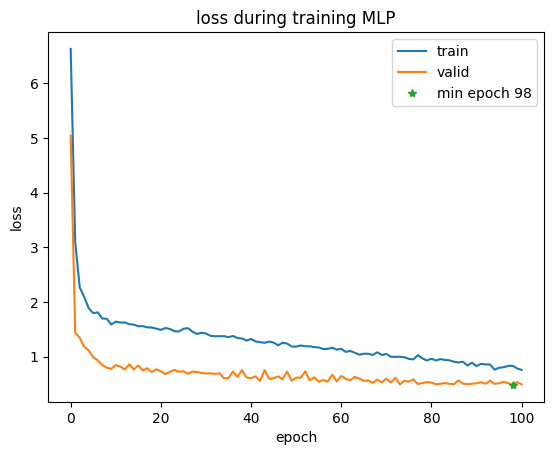

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.512  &0.495  &0.703  &0.483

Epoch:101 [Train] Loss: 0.792 | [Valid] Loss: 0.477	SAVE MODEL: loss: 0.486 -> 0.477 | runtime: 0.172 ms
Epoch:102 [Train] Loss: 0.758 | [Valid] Loss: 0.537	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.799 | [Valid] Loss: 0.547	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.772 | [Valid] Loss: 0.462	SAVE MODEL: loss: 0.477 -> 0.462 | runtime: 0.178 ms
Epoch:105 [Train] Loss: 0.722 | [Valid] Loss: 0.508	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.739 | [Valid] Loss: 0.533	EarlyStopping counter: 2 out of 30
Epoch:107 [Train] Loss: 0.746 | [Valid] Loss: 0.487	EarlyStopping counter: 3 out of 30
Epoch:108 [Train] Loss: 0.719 | [Valid] Loss: 0.540	EarlyStopping counter: 4 out of 30
Epoch:109 [Train] Loss: 0.720 | [Valid] Loss: 0.512	EarlyStopping counter: 5 out of 30
Epoch:110 [Train] Loss: 0.724 | [Valid] Loss: 0.417	SAVE MODEL: loss: 0.462 -> 

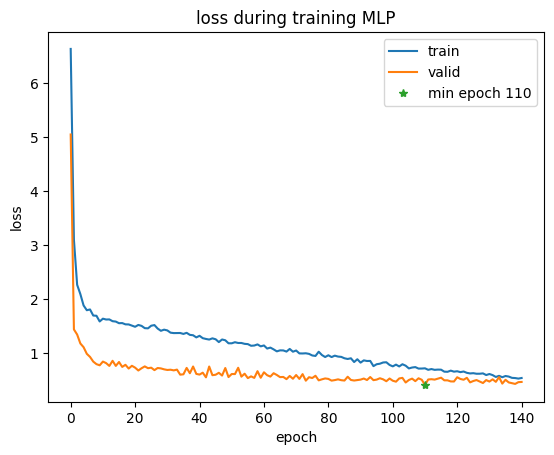

load pretrained model from  LD50_Zhu_no_scale/MLP_ST_0.pt
[Test] Loss: 0.383
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.460  &0.383  &0.619  &0.572


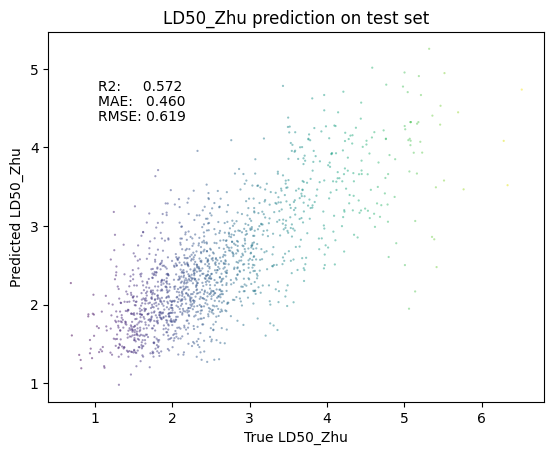



--> Train status saved at LD50_Zhu_no_scale/MLP_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.460 +/- 0.000 | 0.619 +/- 0.000 | 0.572 +/- 0.000 | 


Run # 1 for MLP ST	Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 6.365 | [Valid] Loss: 5.184	SAVE MODEL: loss: inf -> 5.184 | runtime: 0.166 ms
Epoch:1 [Train] Loss: 3.184 | [Valid] Loss: 1.454	SAVE MODEL: loss: 5.184 -> 1.454 | runtime: 0.171 ms
Epoch:2 [Train] Loss: 2.347 | [Valid] Loss: 1.377	SAVE MODEL: loss: 1.454 -> 1.377 | runtime: 0.175 ms
Epoch:3 [Train] Loss: 2.099 | [Valid] Loss: 1.227	SAVE MODEL: loss: 1.377 -> 1.227 | runtime: 0.181 ms
Epoch:4 [Train] Loss: 1.972 | [Valid] Loss: 1.077	SAVE MODEL: loss: 1.227 -> 1.077 | runtime: 0.163 ms
Epoch:5 [Train] Loss: 1.886 | [Valid] Loss: 1.061	SAVE MODEL: loss: 1.077 -> 1.061 | runtime: 0.161 ms
Epoch:6 [Train] Loss: 1.801 | [Valid] Loss: 0.991	SAVE MODEL: loss: 1.061 -> 0.991 

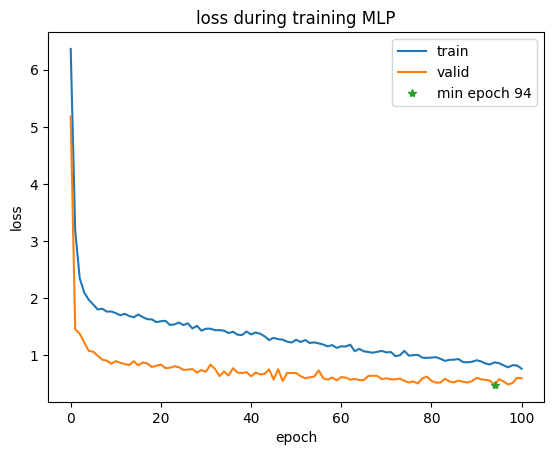

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.571  &0.597  &0.773  &0.376

Epoch:101 [Train] Loss: 0.790 | [Valid] Loss: 0.543	EarlyStopping counter: 7 out of 30
Epoch:102 [Train] Loss: 0.776 | [Valid] Loss: 0.515	EarlyStopping counter: 8 out of 30
Epoch:103 [Train] Loss: 0.753 | [Valid] Loss: 0.493	EarlyStopping counter: 9 out of 30
Epoch:104 [Train] Loss: 0.752 | [Valid] Loss: 0.473	SAVE MODEL: loss: 0.480 -> 0.473 | runtime: 0.162 ms
Epoch:105 [Train] Loss: 0.765 | [Valid] Loss: 0.524	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.778 | [Valid] Loss: 0.460	SAVE MODEL: loss: 0.473 -> 0.460 | runtime: 0.167 ms
Epoch:107 [Train] Loss: 0.749 | [Valid] Loss: 0.546	EarlyStopping counter: 1 out of 30
Epoch:108 [Train] Loss: 0.741 | [Valid] Loss: 0.523	EarlyStopping counter: 2 out of 30
Epoch:109 [Train] Loss: 0.764 | [Valid] Loss: 0.460	EarlyStopping counter: 3 out of 30
Epoch:110 [Train] Loss: 0.740 | [Valid] Loss: 0.508	EarlyStopping counter: 4 ou

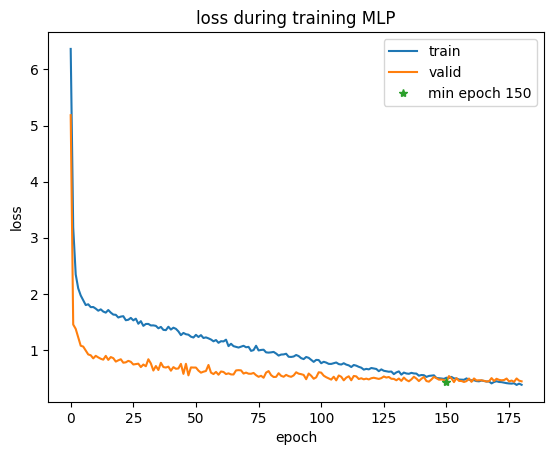

load pretrained model from  LD50_Zhu_no_scale/MLP_ST_1.pt
[Test] Loss: 0.403
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.470  &0.403  &0.635  &0.548


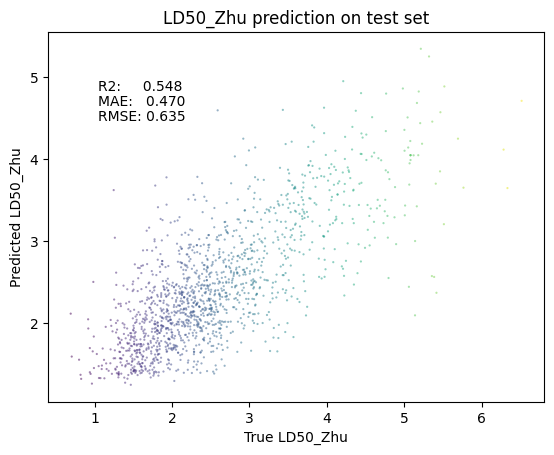



--> Train status saved at LD50_Zhu_no_scale/MLP_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.470 +/- 0.000 | 0.635 +/- 0.000 | 0.548 +/- 0.000 | 


Run # 2 for MLP ST	Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 5.495 | [Valid] Loss: 3.954	SAVE MODEL: loss: inf -> 3.954 | runtime: 0.172 ms
Epoch:1 [Train] Loss: 2.268 | [Valid] Loss: 1.268	SAVE MODEL: loss: 3.954 -> 1.268 | runtime: 0.169 ms
Epoch:2 [Train] Loss: 1.643 | [Valid] Loss: 1.066	SAVE MODEL: loss: 1.268 -> 1.066 | runtime: 0.184 ms
Epoch:3 [Train] Loss: 1.363 | [Valid] Loss: 0.920	SAVE MODEL: loss: 1.066 -> 0.920 | runtime: 0.168 ms
Epoch:4 [Train] Loss: 1.217 | [Valid] Loss: 0.796	SAVE MODEL: loss: 0.920 -> 0.796 | runtime: 0.162 ms
Epoch:5 [Train] Loss: 1.157 | [Valid] Loss: 0.743	SAVE MODEL: loss: 0.796 -> 0.743 | runtime: 0.165 ms
Epoch:6 [Train] Loss: 1.080 | [Valid] Loss: 0.691	SAVE MODEL: loss: 0.743 -> 0.691 

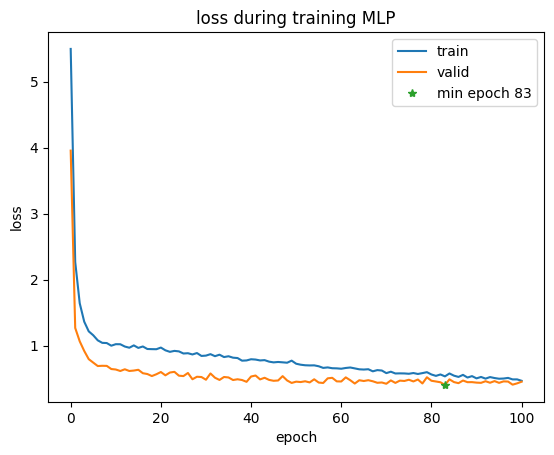

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.490  &0.454  &0.674  &0.525

Epoch:101 [Train] Loss: 0.470 | [Valid] Loss: 0.451	EarlyStopping counter: 18 out of 30
Epoch:102 [Train] Loss: 0.472 | [Valid] Loss: 0.419	EarlyStopping counter: 19 out of 30
Epoch:103 [Train] Loss: 0.474 | [Valid] Loss: 0.458	EarlyStopping counter: 20 out of 30
Epoch:104 [Train] Loss: 0.480 | [Valid] Loss: 0.441	EarlyStopping counter: 21 out of 30
Epoch:105 [Train] Loss: 0.459 | [Valid] Loss: 0.426	EarlyStopping counter: 22 out of 30
Epoch:106 [Train] Loss: 0.470 | [Valid] Loss: 0.426	EarlyStopping counter: 23 out of 30
Epoch:107 [Train] Loss: 0.454 | [Valid] Loss: 0.470	EarlyStopping counter: 24 out of 30
Epoch:108 [Train] Loss: 0.433 | [Valid] Loss: 0.427	EarlyStopping counter: 25 out of 30
Epoch:109 [Train] Loss: 0.459 | [Valid] Loss: 0.439	EarlyStopping counter: 26 out of 30
Epoch:110 [Train] Loss: 0.436 | [Valid] Loss: 0.450	EarlyStopping counter: 27 out of 30
Epoch:111 [Train] 

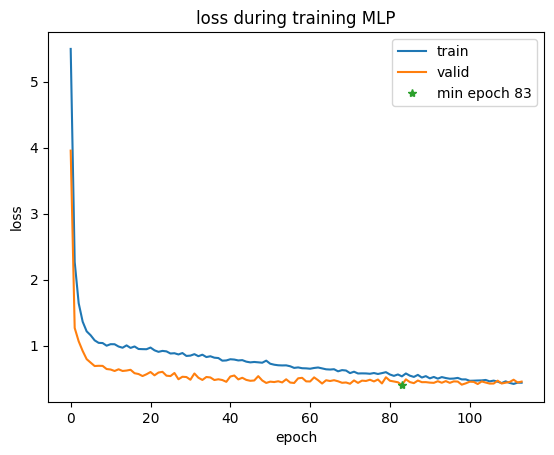

load pretrained model from  LD50_Zhu_no_scale/MLP_ST_2.pt
[Test] Loss: 0.382
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.457  &0.382  &0.618  &0.573


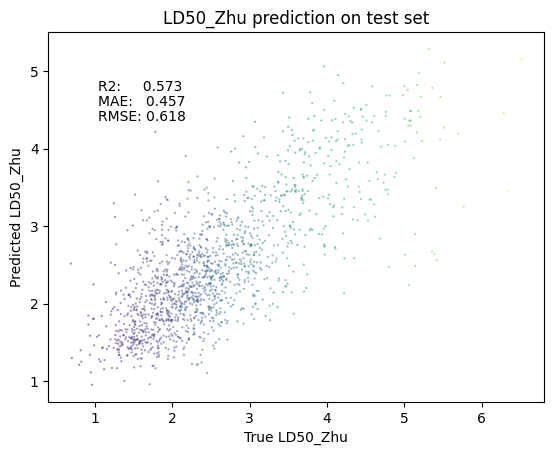



--> Train status saved at LD50_Zhu_no_scale/MLP_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.457 +/- 0.000 | 0.618 +/- 0.000 | 0.573 +/- 0.000 | 

repeated num # 3 idx 2 has the lowest loss from [0.38264380360101635, 0.40345133198381034, 0.38164060537122596]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.462 +/- 0.006 | 0.624 +/- 0.008 | 0.564 +/- 0.011 | 
 idx 2: | 0.457 +/- 0.000 | 0.618 +/- 0.000 | 0.573 +/- 0.000 | 

AttentiveFP
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 652 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 5170 out of 5170 | elapsed:    8.4s finished


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 716 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Done 1416 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 1474 out of 1477 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 1477 out of 1477 | elapsed:    1.6s finished



Run # 0 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 1.754 | [Valid] Loss: 0.947	SAVE MODEL: loss: inf -> 0.947 | runtime: 0.353 ms
Epoch:1 [Train] Loss: 0.896 | [Valid] Loss: 0.896	SAVE MODEL: loss: 0.947 -> 0.896 | runtime: 0.305 ms
Epoch:2 [Train] Loss: 0.790 | [Valid] Loss: 0.727	SAVE MODEL: loss: 0.896 -> 0.727 | runtime: 0.298 ms
Epoch:3 [Train] Loss: 0.720 | [Valid] Loss: 0.742	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 0.685 | [Valid] Loss: 0.722	SAVE MODEL: loss: 0.727 -> 0.722 | runtime: 0.291 ms
Epoch:5 [Train] Loss: 0.671 | [Valid] Loss: 0.658	SAVE MODEL: loss: 0.722 -> 0.658 | runtime: 0.289 ms
Epoch:6 [Train] Loss: 0.668 | [Valid] Loss: 0.629	SAVE MODEL: loss: 0.658 -> 0.629 | runtime: 0.294 ms
Epoch:7 [Train] Loss: 0.644 | [Valid] Loss: 0.635	EarlyStopping counter: 1 out of 30
Epoch:8 [Train] Loss: 0.650 | [Valid] Loss: 0.675	EarlyStopping counter: 2 out of 30
Epoch:9 [Train] L

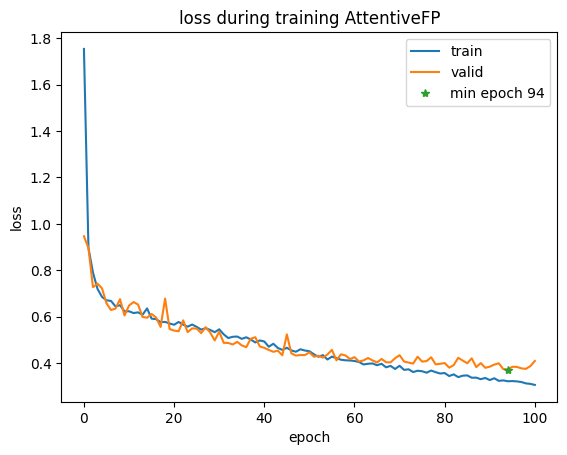

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.476  &0.409  &0.640  &0.572

Epoch:101 [Train] Loss: 0.306 | [Valid] Loss: 0.378	EarlyStopping counter: 7 out of 30
Epoch:102 [Train] Loss: 0.299 | [Valid] Loss: 0.410	EarlyStopping counter: 8 out of 30
Epoch:103 [Train] Loss: 0.309 | [Valid] Loss: 0.387	EarlyStopping counter: 9 out of 30
Epoch:104 [Train] Loss: 0.315 | [Valid] Loss: 0.389	EarlyStopping counter: 10 out of 30
Epoch:105 [Train] Loss: 0.305 | [Valid] Loss: 0.374	EarlyStopping counter: 11 out of 30
Epoch:106 [Train] Loss: 0.301 | [Valid] Loss: 0.381	EarlyStopping counter: 12 out of 30
Epoch:107 [Train] Loss: 0.303 | [Valid] Loss: 0.385	EarlyStopping counter: 13 out of 30
Epoch:108 [Train] Loss: 0.303 | [Valid] Loss: 0.404	EarlyStopping counter: 14 out of 30
Epoch:109 [Train] Loss: 0.302 | [Valid] Loss: 0.383	EarlyStopping counter: 15 out of 30
Epoch:110 [Train] Loss: 0.291 | [Valid] Loss: 0.395	EarlyStopping counter: 16 out of 30
Epoch:111 [Train] Los

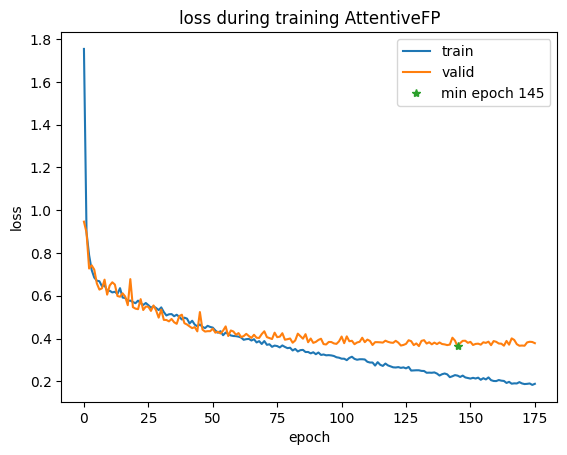

load pretrained model from  LD50_Zhu_no_scale/AttentiveFP_ST_0.pt
[Test] Loss: 0.362
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.443  &0.362  &0.602  &0.595


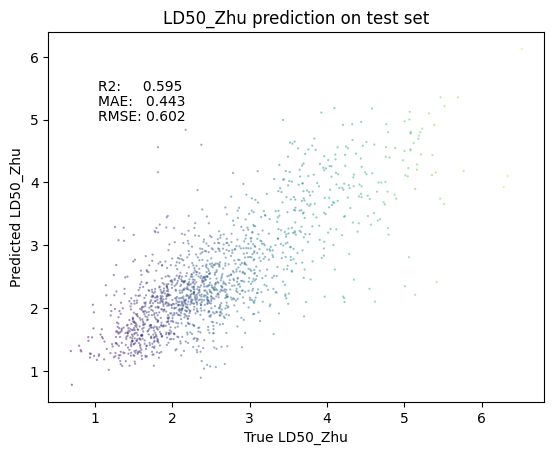



--> Train status saved at LD50_Zhu_no_scale/AttentiveFP_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.443 +/- 0.000 | 0.602 +/- 0.000 | 0.595 +/- 0.000 | 


Run # 1 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 1.659 | [Valid] Loss: 0.929	SAVE MODEL: loss: inf -> 0.929 | runtime: 0.278 ms
Epoch:1 [Train] Loss: 0.885 | [Valid] Loss: 0.809	SAVE MODEL: loss: 0.929 -> 0.809 | runtime: 0.278 ms
Epoch:2 [Train] Loss: 0.768 | [Valid] Loss: 0.729	SAVE MODEL: loss: 0.809 -> 0.729 | runtime: 0.287 ms
Epoch:3 [Train] Loss: 0.712 | [Valid] Loss: 0.681	SAVE MODEL: loss: 0.729 -> 0.681 | runtime: 0.292 ms
Epoch:4 [Train] Loss: 0.672 | [Valid] Loss: 0.654	SAVE MODEL: loss: 0.681 -> 0.654 | runtime: 0.288 ms
Epoch:5 [Train] Loss: 0.680 | [Valid] Loss: 0.647	SAVE MODEL: loss: 0.654 -> 0.647 | runtime: 0.280 ms
Epoch:6 [Train] Loss: 0.640 | [Valid] Loss: 0.632

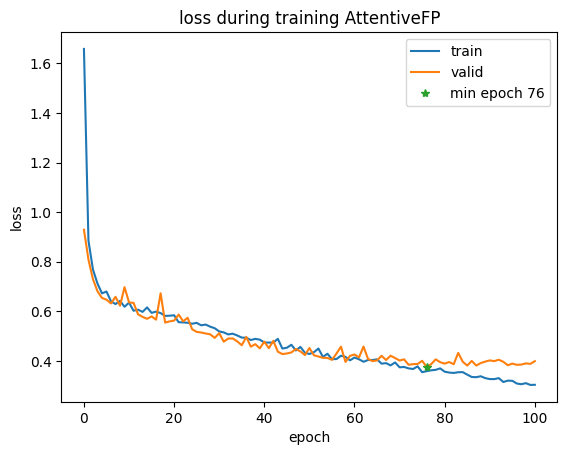

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.470  &0.399  &0.631  &0.583

Epoch:101 [Train] Loss: 0.322 | [Valid] Loss: 0.408	EarlyStopping counter: 25 out of 30
Epoch:102 [Train] Loss: 0.309 | [Valid] Loss: 0.377	EarlyStopping counter: 26 out of 30
Epoch:103 [Train] Loss: 0.297 | [Valid] Loss: 0.379	EarlyStopping counter: 27 out of 30
Epoch:104 [Train] Loss: 0.298 | [Valid] Loss: 0.379	EarlyStopping counter: 28 out of 30
Epoch:105 [Train] Loss: 0.299 | [Valid] Loss: 0.396	EarlyStopping counter: 29 out of 30
Epoch:106 [Train] Loss: 0.284 | [Valid] Loss: 0.385	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at LD50_Zhu_no_scale/AttentiveFP_ST_1.yml
Model parameters:  3823507
Train time: 0.279+/-0.006 ms
best epoch: 76, min loss: 0.3759


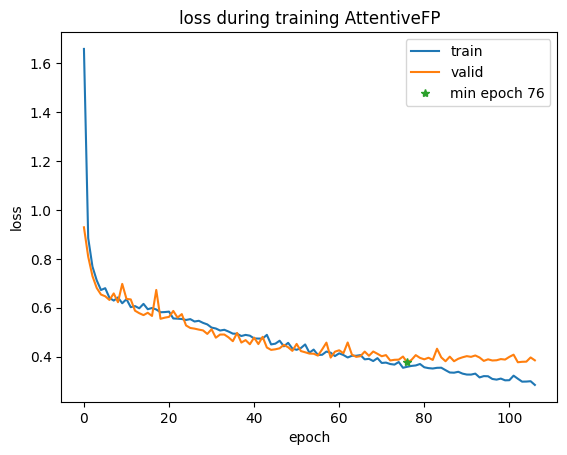

load pretrained model from  LD50_Zhu_no_scale/AttentiveFP_ST_1.pt
[Test] Loss: 0.387
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.466  &0.387  &0.622  &0.567


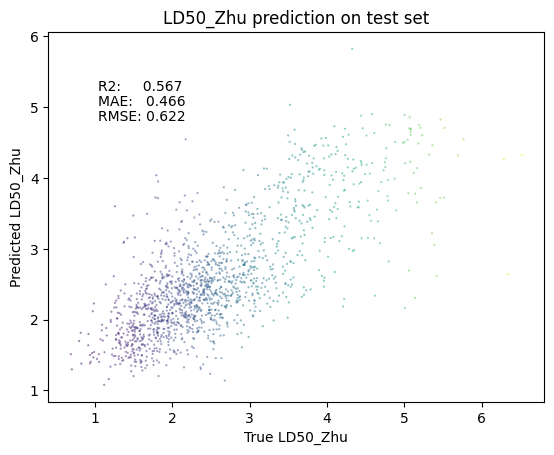



--> Train status saved at LD50_Zhu_no_scale/AttentiveFP_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.466 +/- 0.000 | 0.622 +/- 0.000 | 0.567 +/- 0.000 | 


Run # 2 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 1.723 | [Valid] Loss: 0.949	SAVE MODEL: loss: inf -> 0.949 | runtime: 0.275 ms
Epoch:1 [Train] Loss: 0.916 | [Valid] Loss: 0.886	SAVE MODEL: loss: 0.949 -> 0.886 | runtime: 0.277 ms
Epoch:2 [Train] Loss: 0.802 | [Valid] Loss: 0.728	SAVE MODEL: loss: 0.886 -> 0.728 | runtime: 0.275 ms
Epoch:3 [Train] Loss: 0.731 | [Valid] Loss: 0.687	SAVE MODEL: loss: 0.728 -> 0.687 | runtime: 0.277 ms
Epoch:4 [Train] Loss: 0.679 | [Valid] Loss: 0.703	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss: 0.675 | [Valid] Loss: 0.673	SAVE MODEL: loss: 0.687 -> 0.673 | runtime: 0.275 ms
Epoch:6 [Train] Loss: 0.651 | [Valid] Loss: 0.640	SAVE MODEL: loss:

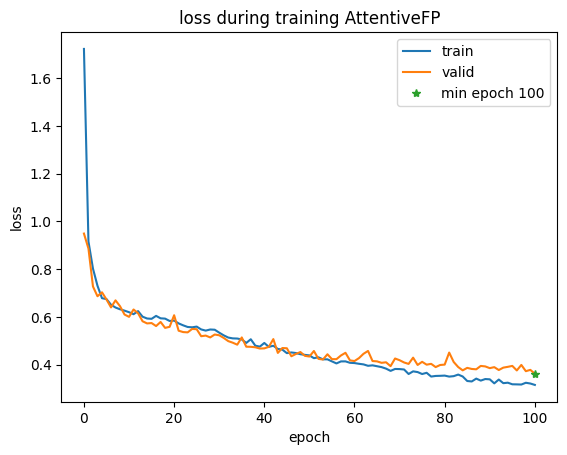

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.455  &0.362  &0.602  &0.621

Epoch:101 [Train] Loss: 0.306 | [Valid] Loss: 0.362	SAVE MODEL: loss: 0.362 -> 0.362 | runtime: 0.345 ms
Epoch:102 [Train] Loss: 0.309 | [Valid] Loss: 0.374	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.299 | [Valid] Loss: 0.377	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.299 | [Valid] Loss: 0.389	EarlyStopping counter: 3 out of 30
Epoch:105 [Train] Loss: 0.302 | [Valid] Loss: 0.370	EarlyStopping counter: 4 out of 30
Epoch:106 [Train] Loss: 0.294 | [Valid] Loss: 0.386	EarlyStopping counter: 5 out of 30
Epoch:107 [Train] Loss: 0.286 | [Valid] Loss: 0.383	EarlyStopping counter: 6 out of 30
Epoch:108 [Train] Loss: 0.287 | [Valid] Loss: 0.364	EarlyStopping counter: 7 out of 30
Epoch:109 [Train] Loss: 0.284 | [Valid] Loss: 0.369	EarlyStopping counter: 8 out of 30
Epoch:110 [Train] Loss: 0.293 | [Valid] Loss: 0.371	EarlyStopping counter: 9 out of 30
Epoch:111 

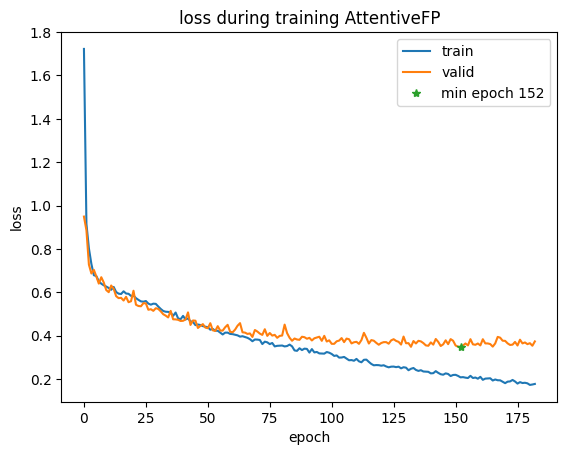

load pretrained model from  LD50_Zhu_no_scale/AttentiveFP_ST_2.pt
[Test] Loss: 0.355
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.437  &0.355  &0.596  &0.603


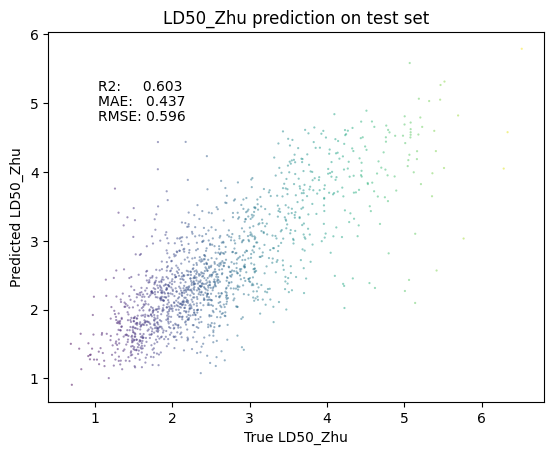



--> Train status saved at LD50_Zhu_no_scale/AttentiveFP_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.437 +/- 0.000 | 0.596 +/- 0.000 | 0.603 +/- 0.000 | 

repeated num # 3 idx 2 has the lowest loss from [0.36200820003398465, 0.38654722292518484, 0.3550743911422905]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.449 +/- 0.013 | 0.606 +/- 0.011 | 0.588 +/- 0.015 | 
 idx 2: | 0.437 +/- 0.000 | 0.596 +/- 0.000 | 0.603 +/- 0.000 | 

GIN
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN

Run # 0 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 6.257 | [Valid] Loss: 4.7

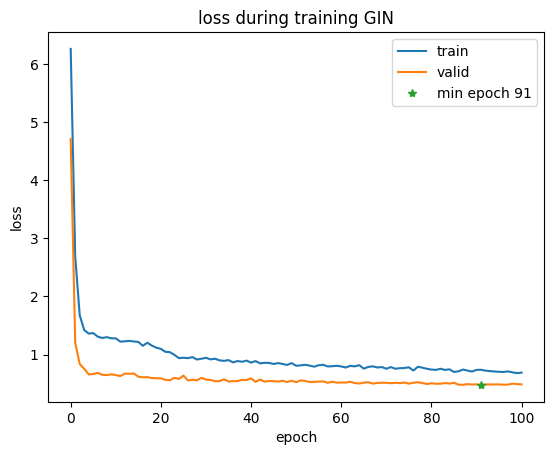

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.504  &0.487  &0.698  &0.491

Epoch:101 [Train] Loss: 0.703 | [Valid] Loss: 0.502	EarlyStopping counter: 10 out of 30
Epoch:102 [Train] Loss: 0.695 | [Valid] Loss: 0.491	EarlyStopping counter: 11 out of 30
Epoch:103 [Train] Loss: 0.680 | [Valid] Loss: 0.485	EarlyStopping counter: 12 out of 30
Epoch:104 [Train] Loss: 0.691 | [Valid] Loss: 0.493	EarlyStopping counter: 13 out of 30
Epoch:105 [Train] Loss: 0.689 | [Valid] Loss: 0.485	EarlyStopping counter: 14 out of 30
Epoch:106 [Train] Loss: 0.652 | [Valid] Loss: 0.481	EarlyStopping counter: 15 out of 30
Epoch:107 [Train] Loss: 0.651 | [Valid] Loss: 0.485	EarlyStopping counter: 16 out of 30
Epoch:108 [Train] Loss: 0.688 | [Valid] Loss: 0.472	SAVE MODEL: loss: 0.478 -> 0.472 | runtime: 2.053 ms
Epoch:109 [Train] Loss: 0.667 | [Valid] Loss: 0.473	EarlyStopping counter: 1 out of 30
Epoch:110 [Train] Loss: 0.672 | [Valid] Loss: 0.474	EarlyStopping counter: 2 out of 30
Epo

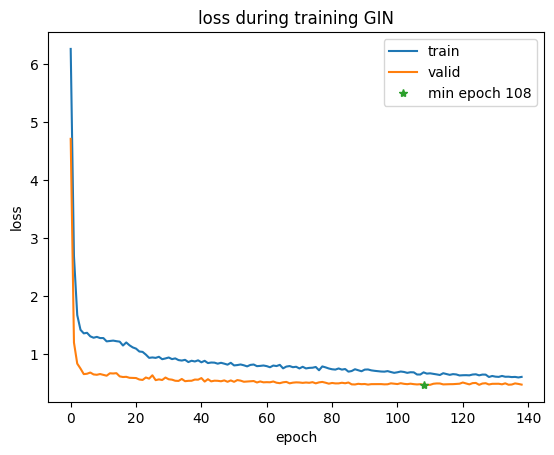

Pretrained model loaded
load pretrained model from  LD50_Zhu_no_scale/GIN_ST_0.pt
[Test] Loss: 0.405
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.470  &0.405  &0.637  &0.546


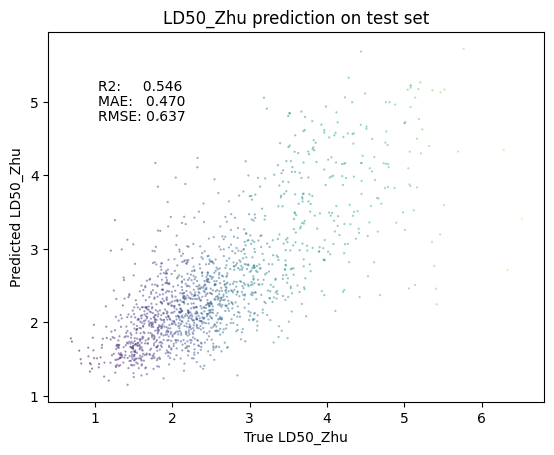



--> Train status saved at LD50_Zhu_no_scale/GIN_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.470 +/- 0.000 | 0.637 +/- 0.000 | 0.546 +/- 0.000 | 


Run # 1 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 7.698 | [Valid] Loss: 6.871	SAVE MODEL: loss: inf -> 6.871 | runtime: 2.012 ms
Epoch:1 [Train] Loss: 4.145 | [Valid] Loss: 1.909	SAVE MODEL: loss: 6.871 -> 1.909 | runtime: 2.033 ms
Epoch:2 [Train] Loss: 2.609 | [Valid] Loss: 1.134	SAVE MODEL: loss: 1.909 -> 1.134 | runtime: 2.013 ms
Epoch:3 [Train] Loss: 2.238 | [Valid] Loss: 1.013	SAVE MODEL: loss: 1.134 -> 1.013 | runtime: 2.052 ms
Epoch:4 [Train] Loss: 2.159 | [Valid] Loss: 0.928	SAVE MODEL: loss: 1.013 -> 0.928 | runtime: 2.028 ms
Epoch:5 [Train] Loss: 2.06

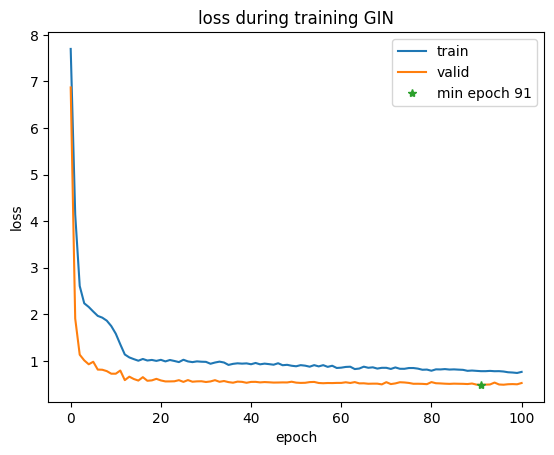

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.526  &0.526  &0.725  &0.450

Epoch:101 [Train] Loss: 0.770 | [Valid] Loss: 0.499	EarlyStopping counter: 10 out of 30
Epoch:102 [Train] Loss: 0.745 | [Valid] Loss: 0.507	EarlyStopping counter: 11 out of 30
Epoch:103 [Train] Loss: 0.745 | [Valid] Loss: 0.499	EarlyStopping counter: 12 out of 30
Epoch:104 [Train] Loss: 0.744 | [Valid] Loss: 0.486	EarlyStopping counter: 13 out of 30
Epoch:105 [Train] Loss: 0.751 | [Valid] Loss: 0.495	EarlyStopping counter: 14 out of 30
Epoch:106 [Train] Loss: 0.733 | [Valid] Loss: 0.498	EarlyStopping counter: 15 out of 30
Epoch:107 [Train] Loss: 0.733 | [Valid] Loss: 0.489	EarlyStopping counter: 16 out of 30
Epoch:108 [Train] Loss: 0.739 | [Valid] Loss: 0.493	EarlyStopping counter: 17 out of 30
Epoch:109 [Train] Loss: 0.737 | [Valid] Loss: 0.498	EarlyStopping counter: 18 out of 30
Epoch:110 [Train] Loss: 0.732 | [Valid] Loss: 0.486	EarlyStopping counter: 19 out of 30
Epoch:111 [Train] 

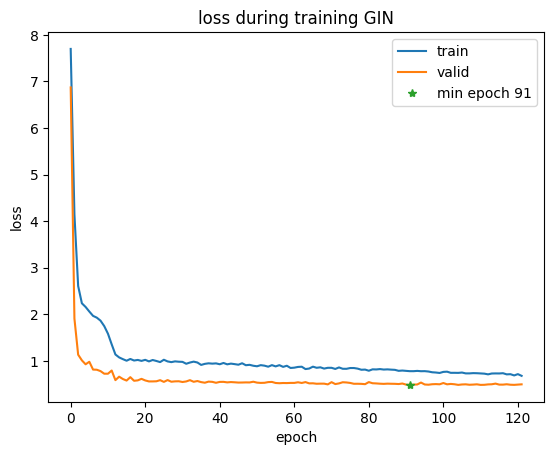

Pretrained model loaded
load pretrained model from  LD50_Zhu_no_scale/GIN_ST_1.pt
[Test] Loss: 0.420
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.480  &0.420  &0.648  &0.530


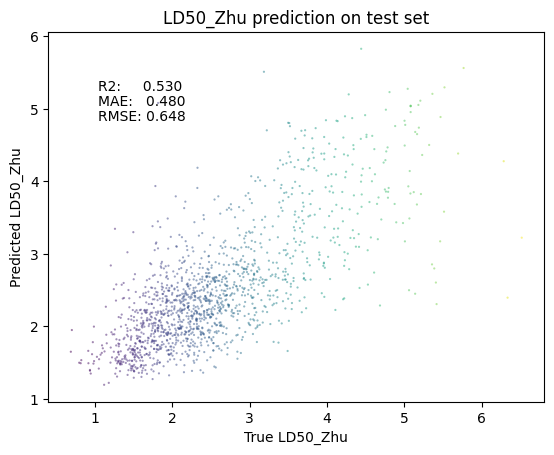



--> Train status saved at LD50_Zhu_no_scale/GIN_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.480 +/- 0.000 | 0.648 +/- 0.000 | 0.530 +/- 0.000 | 


Run # 2 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 6.670 | [Valid] Loss: 4.025	SAVE MODEL: loss: inf -> 4.025 | runtime: 2.005 ms
Epoch:1 [Train] Loss: 2.522 | [Valid] Loss: 0.949	SAVE MODEL: loss: 4.025 -> 0.949 | runtime: 2.042 ms
Epoch:2 [Train] Loss: 1.711 | [Valid] Loss: 0.769	SAVE MODEL: loss: 0.949 -> 0.769 | runtime: 2.070 ms
Epoch:3 [Train] Loss: 1.548 | [Valid] Loss: 0.679	SAVE MODEL: loss: 0.769 -> 0.679 | runtime: 2.056 ms
Epoch:4 [Train] Loss: 1.534 | [Valid] Loss: 0.781	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss: 1.445 | [Valid] Loss: 

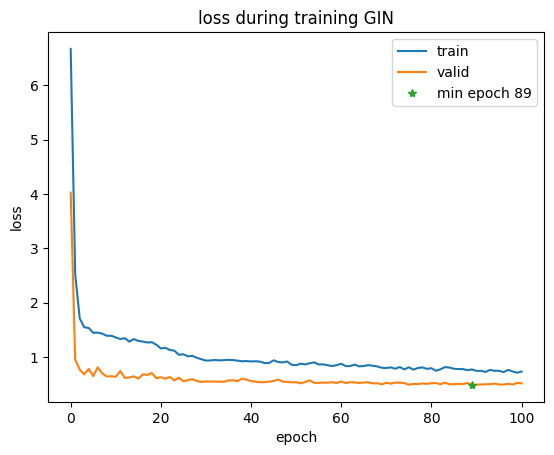

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.514  &0.515  &0.718  &0.462

Epoch:101 [Train] Loss: 0.723 | [Valid] Loss: 0.514	EarlyStopping counter: 12 out of 30
Epoch:102 [Train] Loss: 0.709 | [Valid] Loss: 0.501	EarlyStopping counter: 13 out of 30
Epoch:103 [Train] Loss: 0.718 | [Valid] Loss: 0.496	EarlyStopping counter: 14 out of 30
Epoch:104 [Train] Loss: 0.720 | [Valid] Loss: 0.485	SAVE MODEL: loss: 0.486 -> 0.485 | runtime: 2.065 ms
Epoch:105 [Train] Loss: 0.698 | [Valid] Loss: 0.479	SAVE MODEL: loss: 0.485 -> 0.479 | runtime: 2.069 ms
Epoch:106 [Train] Loss: 0.701 | [Valid] Loss: 0.492	EarlyStopping counter: 1 out of 30
Epoch:107 [Train] Loss: 0.687 | [Valid] Loss: 0.513	EarlyStopping counter: 2 out of 30
Epoch:108 [Train] Loss: 0.727 | [Valid] Loss: 0.487	EarlyStopping counter: 3 out of 30
Epoch:109 [Train] Loss: 0.710 | [Valid] Loss: 0.485	EarlyStopping counter: 4 out of 30
Epoch:110 [Train] Loss: 0.708 | [Valid] Loss: 0.484	EarlyStopping counter: 5

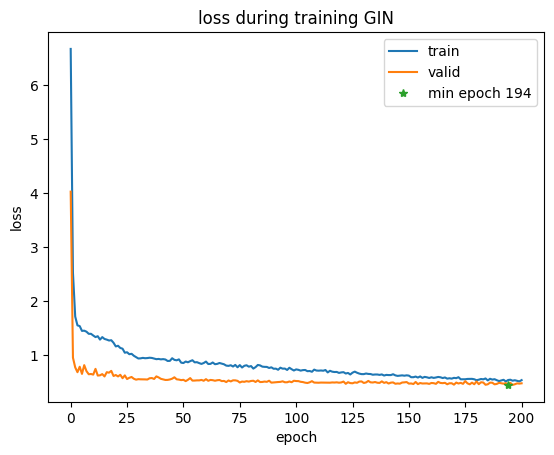

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.492  &0.474  &0.688  &0.505

Epoch:201 [Train] Loss: 0.526 | [Valid] Loss: 0.446	EarlyStopping counter: 7 out of 30
Epoch:202 [Train] Loss: 0.521 | [Valid] Loss: 0.473	EarlyStopping counter: 8 out of 30
Epoch:203 [Train] Loss: 0.519 | [Valid] Loss: 0.465	EarlyStopping counter: 9 out of 30
Epoch:204 [Train] Loss: 0.503 | [Valid] Loss: 0.449	EarlyStopping counter: 10 out of 30
Epoch:205 [Train] Loss: 0.527 | [Valid] Loss: 0.498	EarlyStopping counter: 11 out of 30
Epoch:206 [Train] Loss: 0.510 | [Valid] Loss: 0.482	EarlyStopping counter: 12 out of 30
Epoch:207 [Train] Loss: 0.501 | [Valid] Loss: 0.466	EarlyStopping counter: 13 out of 30
Epoch:208 [Train] Loss: 0.503 | [Valid] Loss: 0.499	EarlyStopping counter: 14 out of 30
Epoch:209 [Train] Loss: 0.515 | [Valid] Loss: 0.478	EarlyStopping counter: 15 out of 30
Epoch:210 [Train] Loss: 0.498 | [Valid] Loss: 0.446	EarlyStopping counter: 16 out of 30
Epoch:211 [Train] Los

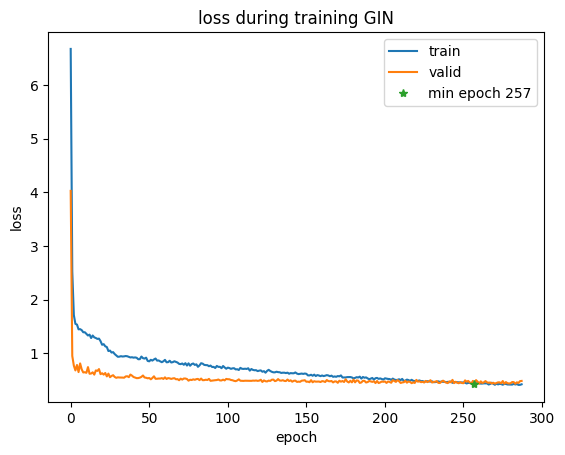

Pretrained model loaded
load pretrained model from  LD50_Zhu_no_scale/GIN_ST_2.pt
[Test] Loss: 0.347
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.436  &0.347  &0.589  &0.612


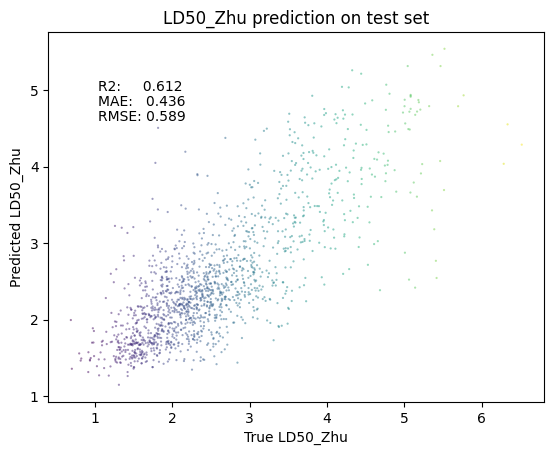



--> Train status saved at LD50_Zhu_no_scale/GIN_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.436 +/- 0.000 | 0.589 +/- 0.000 | 0.612 +/- 0.000 | 

repeated num # 3 idx 2 has the lowest loss from [0.40541186684600067, 0.42001044596863824, 0.34691953820478455]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.462 +/- 0.019 | 0.625 +/- 0.026 | 0.563 +/- 0.035 | 
 idx 2: | 0.436 +/- 0.000 | 0.589 +/- 0.000 | 0.612 +/- 0.000 | 

RNN
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN

Run # 0 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 2.188 | [Valid] Loss: 0.984	SAVE MODEL: loss: inf -> 0.984 | runtime: 0.772 ms
Epoch:1 [Train] Loss: 0.911 | [Valid] Loss: 0.907	SAVE MODEL: loss: 0.984 -> 0.907 | runtime: 0.790 ms
Epoch:2 

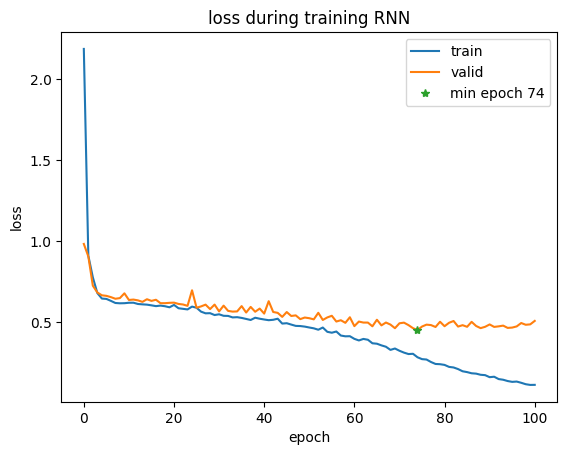

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.527  &0.509  &0.713  &0.468

Epoch:101 [Train] Loss: 0.113 | [Valid] Loss: 0.484	EarlyStopping counter: 27 out of 30
Epoch:102 [Train] Loss: 0.106 | [Valid] Loss: 0.468	EarlyStopping counter: 28 out of 30
Epoch:103 [Train] Loss: 0.105 | [Valid] Loss: 0.501	EarlyStopping counter: 29 out of 30
Epoch:104 [Train] Loss: 0.108 | [Valid] Loss: 0.488	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at LD50_Zhu_no_scale/RNN_ST_0.yml
Model parameters:  3046533
Train time: 0.768+/-0.015 ms
best epoch: 74, min loss: 0.4526


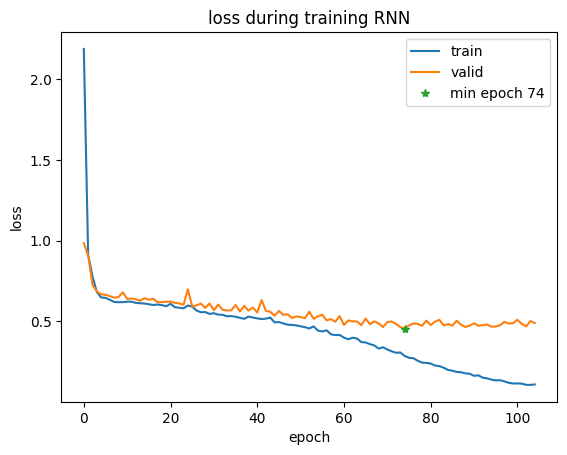

load pretrained model from  LD50_Zhu_no_scale/RNN_ST_0.pt
[Test] Loss: 0.457
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.514  &0.457  &0.676  &0.488


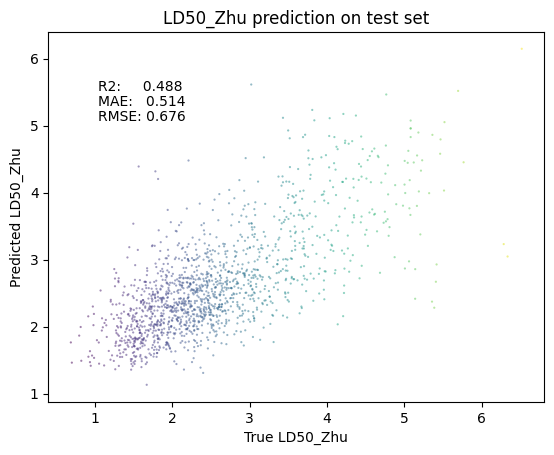



--> Train status saved at LD50_Zhu_no_scale/RNN_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.514 +/- 0.000 | 0.676 +/- 0.000 | 0.488 +/- 0.000 | 


Run # 1 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 2.088 | [Valid] Loss: 0.979	SAVE MODEL: loss: inf -> 0.979 | runtime: 0.760 ms
Epoch:1 [Train] Loss: 0.915 | [Valid] Loss: 0.931	SAVE MODEL: loss: 0.979 -> 0.931 | runtime: 0.765 ms
Epoch:2 [Train] Loss: 0.807 | [Valid] Loss: 0.764	SAVE MODEL: loss: 0.931 -> 0.764 | runtime: 0.775 ms
Epoch:3 [Train] Loss: 0.682 | [Valid] Loss: 0.741	SAVE MODEL: loss: 0.764 -> 0.741 | runtime: 0.769 ms
Epoch:4 [Train] Loss: 0.660 | [Valid] Loss: 0.667	SAVE MODEL: loss: 0.741 -> 0.667 | runtime: 0.748 ms
Epoch:5 [Train] Loss: 0.638 | [Valid] Loss: 0.690	EarlyStopping counter: 1 out of 30
Epoch:6 [Train] Loss: 0.630 | [Valid] Loss: 0.642	SAVE MODEL: loss: 0.667 -> 0.642 | runtime: 0.745

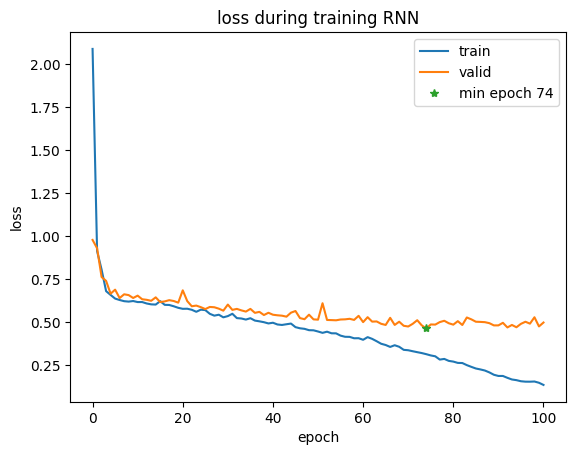

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.529  &0.499  &0.707  &0.478

Epoch:101 [Train] Loss: 0.135 | [Valid] Loss: 0.501	EarlyStopping counter: 27 out of 30
Epoch:102 [Train] Loss: 0.125 | [Valid] Loss: 0.486	EarlyStopping counter: 28 out of 30
Epoch:103 [Train] Loss: 0.121 | [Valid] Loss: 0.504	EarlyStopping counter: 29 out of 30
Epoch:104 [Train] Loss: 0.118 | [Valid] Loss: 0.499	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at LD50_Zhu_no_scale/RNN_ST_1.yml
Model parameters:  3046533
Train time: 0.763+/-0.011 ms
best epoch: 74, min loss: 0.4650


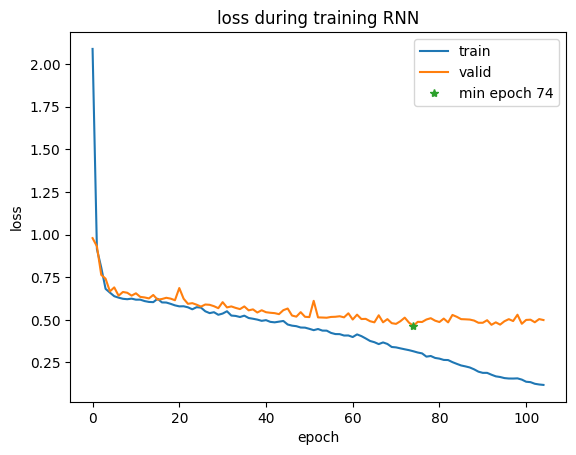

load pretrained model from  LD50_Zhu_no_scale/RNN_ST_1.pt
[Test] Loss: 0.484
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.513  &0.484  &0.696  &0.458


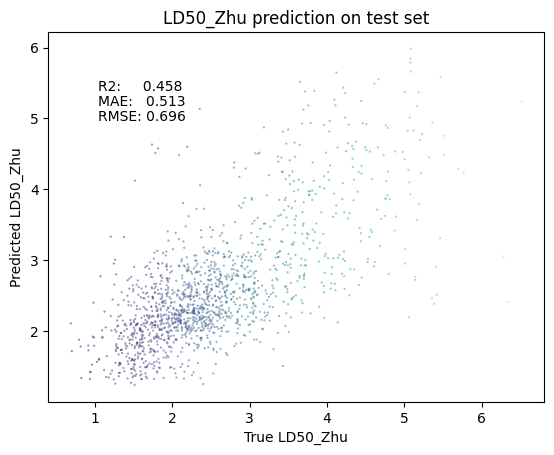



--> Train status saved at LD50_Zhu_no_scale/RNN_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.513 +/- 0.000 | 0.696 +/- 0.000 | 0.458 +/- 0.000 | 


Run # 2 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 2.023 | [Valid] Loss: 0.995	SAVE MODEL: loss: inf -> 0.995 | runtime: 0.780 ms
Epoch:1 [Train] Loss: 0.915 | [Valid] Loss: 0.920	SAVE MODEL: loss: 0.995 -> 0.920 | runtime: 0.764 ms
Epoch:2 [Train] Loss: 0.789 | [Valid] Loss: 0.722	SAVE MODEL: loss: 0.920 -> 0.722 | runtime: 0.765 ms
Epoch:3 [Train] Loss: 0.670 | [Valid] Loss: 0.706	SAVE MODEL: loss: 0.722 -> 0.706 | runtime: 0.729 ms
Epoch:4 [Train] Loss: 0.648 | [Valid] Loss: 0.671	SAVE MODEL: loss: 0.706 -> 0.671 | runtime: 0.775 ms
Epoch:5 [Train] Loss: 0.641 | [Valid] Loss: 0.679	EarlyStopping counter: 1 out of 30
Epoch:6 [Train] Loss: 0.649 | [Valid] Loss: 0.680	EarlyStopping counter: 2 out of 30
Epoch:7 [Train

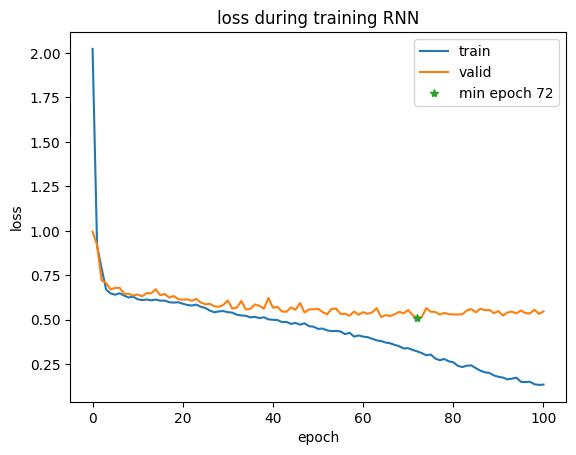

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.534  &0.547  &0.739  &0.429

Epoch:101 [Train] Loss: 0.133 | [Valid] Loss: 0.542	EarlyStopping counter: 29 out of 30
Epoch:102 [Train] Loss: 0.130 | [Valid] Loss: 0.529	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at LD50_Zhu_no_scale/RNN_ST_2.yml
Model parameters:  3046533
Train time: 0.765+/-0.011 ms
best epoch: 72, min loss: 0.5121


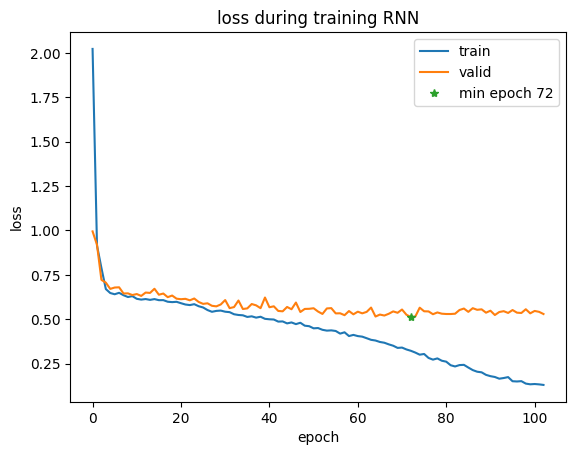

load pretrained model from  LD50_Zhu_no_scale/RNN_ST_2.pt
[Test] Loss: 0.478
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.512  &0.478  &0.691  &0.465


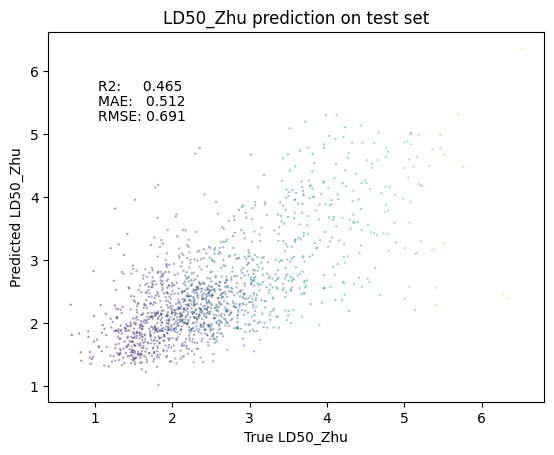



--> Train status saved at LD50_Zhu_no_scale/RNN_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.512 +/- 0.000 | 0.691 +/- 0.000 | 0.465 +/- 0.000 | 

repeated num # 3 idx 0 has the lowest loss from [0.45742863711264786, 0.48387063348624215, 0.47761090639562487]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.513 +/- 0.001 | 0.688 +/- 0.008 | 0.471 +/- 0.013 | 
 idx 0: | 0.514 +/- 0.000 | 0.676 +/- 0.000 | 0.488 +/- 0.000 | 

path: LD50_Zhu_scale is created





info will be saved at LD50_Zhu_scale

START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]} 

MLP
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED


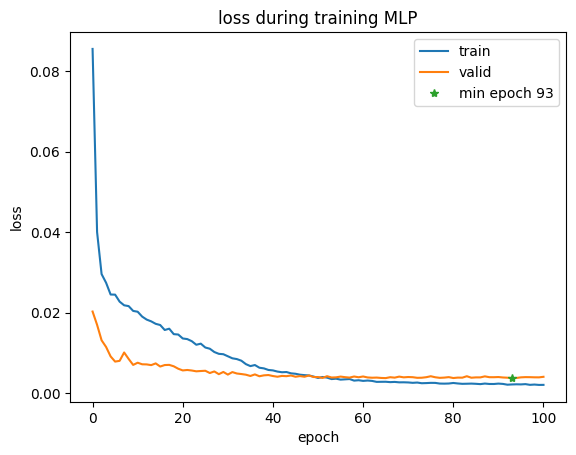

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.492  &0.456  &0.675  &0.524

Epoch:101 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 8 out of 30
Epoch:102 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 9 out of 30
Epoch:103 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 10 out of 30
Epoch:104 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 11 out of 30
Epoch:105 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 12 out of 30
Epoch:106 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 13 out of 30
Epoch:107 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 14 out of 30
Epoch:108 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 15 out of 30
Epoch:109 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 16 out of 30
Epoch:110 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 17 out of 30
Epoch:111 [Train] Lo

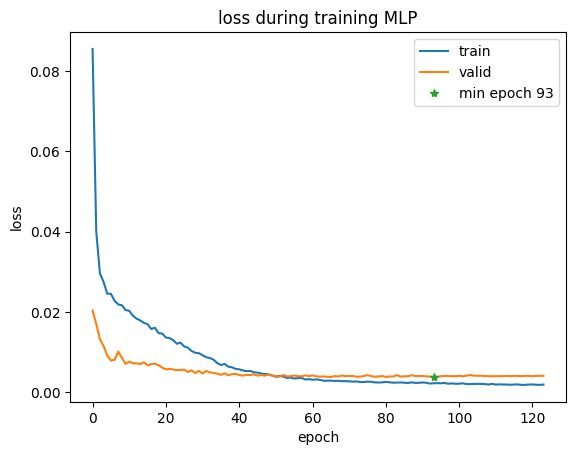

load pretrained model from  LD50_Zhu_scale/MLP_ST_0.pt
[Test] Loss: 0.004
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.465  &0.394  &0.628  &0.559


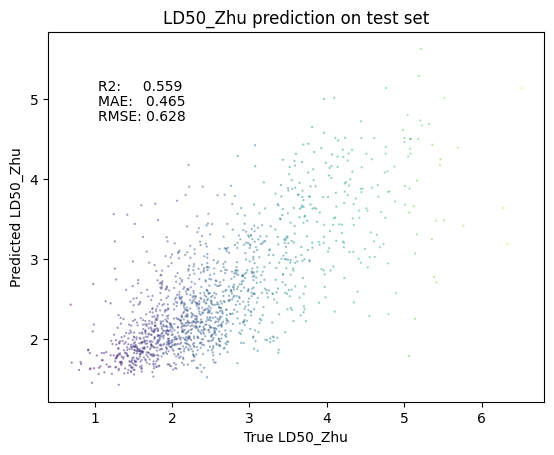



--> Train status saved at LD50_Zhu_scale/MLP_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.465 +/- 0.000 | 0.628 +/- 0.000 | 0.559 +/- 0.000 | 


Run # 1 for MLP ST	Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 0.087 | [Valid] Loss: 0.018	SAVE MODEL: loss: inf -> 0.018 | runtime: 0.162 ms
Epoch:1 [Train] Loss: 0.038 | [Valid] Loss: 0.015	SAVE MODEL: loss: 0.018 -> 0.015 | runtime: 0.163 ms
Epoch:2 [Train] Loss: 0.031 | [Valid] Loss: 0.012	SAVE MODEL: loss: 0.015 -> 0.012 | runtime: 0.162 ms
Epoch:3 [Train] Loss: 0.027 | [Valid] Loss: 0.011	SAVE MODEL: loss: 0.012 -> 0.011 | runtime: 0.164 ms
Epoch:4 [Train] Loss: 0.025 | [Valid] Loss: 0.009	SAVE MODEL: loss: 0.011 -> 0.009 | runtime: 0.165 ms
Epoch:5 [Train] Loss: 0.026 | [Valid] Loss: 0.009	SAVE MODEL: loss: 0.009 -> 0.009 | runtime: 0.166 ms
Epoch:6 [Train] Loss: 0.023 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.009 -> 0.008 | r

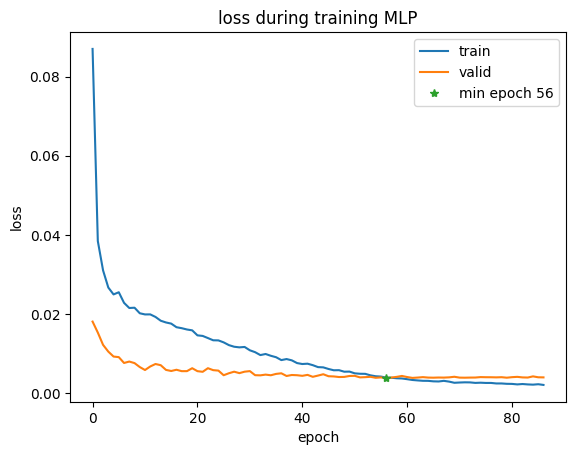

load pretrained model from  LD50_Zhu_scale/MLP_ST_1.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.456  &0.377  &0.614  &0.578


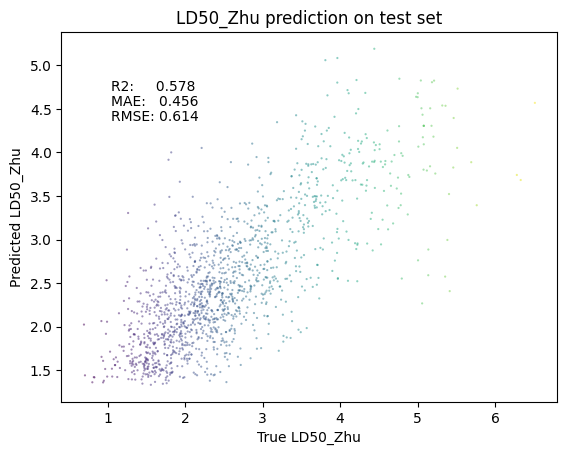



--> Train status saved at LD50_Zhu_scale/MLP_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.456 +/- 0.000 | 0.614 +/- 0.000 | 0.578 +/- 0.000 | 


Run # 2 for MLP ST	Model type:  MLP | Model parameters:  30817
Start training MLP...
Epoch:0 [Train] Loss: 0.124 | [Valid] Loss: 0.027	SAVE MODEL: loss: inf -> 0.027 | runtime: 0.172 ms
Epoch:1 [Train] Loss: 0.043 | [Valid] Loss: 0.017	SAVE MODEL: loss: 0.027 -> 0.017 | runtime: 0.173 ms
Epoch:2 [Train] Loss: 0.031 | [Valid] Loss: 0.012	SAVE MODEL: loss: 0.017 -> 0.012 | runtime: 0.180 ms
Epoch:3 [Train] Loss: 0.024 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.012 -> 0.008 | runtime: 0.163 ms
Epoch:4 [Train] Loss: 0.021 | [Valid] Loss: 0.008	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss: 0.020 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.008 -> 0.008 | runtime: 0.164 ms
Epoch:6 [Train] Loss: 0.019 | [Valid] Loss: 0.008	EarlyStopping counter: 1 out of 30
Epoch:7 [Train] Los

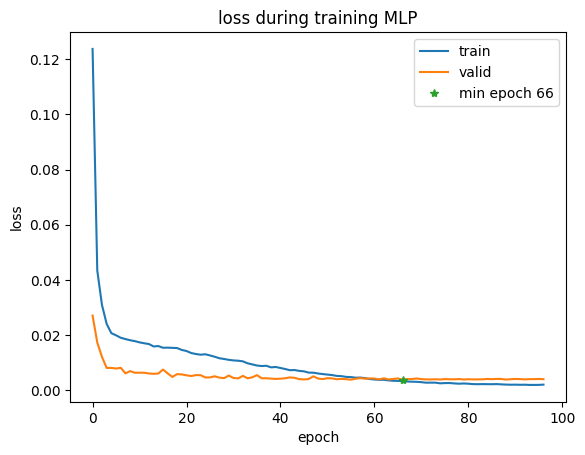

load pretrained model from  LD50_Zhu_scale/MLP_ST_2.pt
[Test] Loss: 0.004
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.464  &0.392  &0.626  &0.561


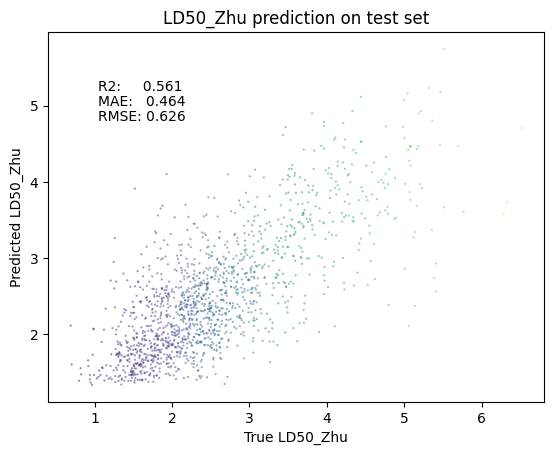



--> Train status saved at LD50_Zhu_scale/MLP_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.464 +/- 0.000 | 0.626 +/- 0.000 | 0.561 +/- 0.000 | 

repeated num # 3 idx 1 has the lowest loss from [0.0035394736456564333, 0.0033902998461300404, 0.0035230769607450967]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.462 +/- 0.004 | 0.623 +/- 0.006 | 0.566 +/- 0.008 | 
 idx 1: | 0.456 +/- 0.000 | 0.614 +/- 0.000 | 0.578 +/- 0.000 | 

AttentiveFP
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 780 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 5170 out of 5170 | elapsed:    8.5s finished


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 716 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 738 out of 738 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=2)]: Done 1416 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 1474 out of 1477 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 1477 out of 1477 | elapsed:    1.8s finished



Run # 0 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.024 | [Valid] Loss: 0.009	SAVE MODEL: loss: inf -> 0.009 | runtime: 0.340 ms
Epoch:1 [Train] Loss: 0.009 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.009 -> 0.007 | runtime: 0.301 ms
Epoch:2 [Train] Loss: 0.007 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 0.285 ms
Epoch:3 [Train] Loss: 0.007 | [Valid] Loss: 0.007	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 0.007 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.007 -> 0.006 | runtime: 0.283 ms
Epoch:5 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 0.284 ms
Epoch:6 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 1 out of 30
Epoch:7 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 2 out of 30
Epoch:8 [Train] Loss: 0.006 | [Valid] Loss: 0.006	EarlyStopping counter: 3 out of 30
Epoch:9 [Train] Loss: 0.006 | [Vali

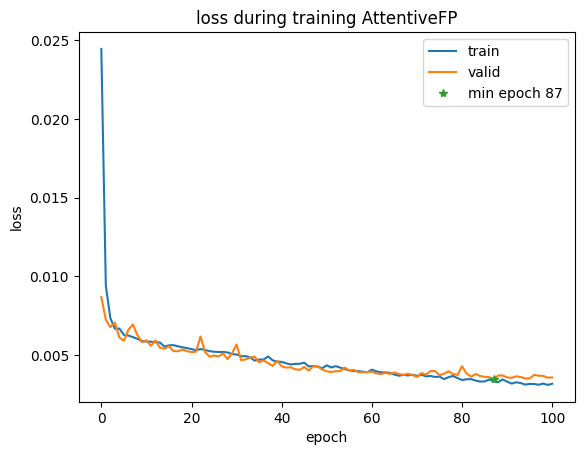

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.476  &0.398  &0.631  &0.584

Epoch:101 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 14 out of 30
Epoch:102 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 15 out of 30
Epoch:103 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 16 out of 30
Epoch:104 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 17 out of 30
Epoch:105 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 18 out of 30
Epoch:106 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 19 out of 30
Epoch:107 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 20 out of 30
Epoch:108 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 21 out of 30
Epoch:109 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 22 out of 30
Epoch:110 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 23 out of 30
Epoch:111 [Train] 

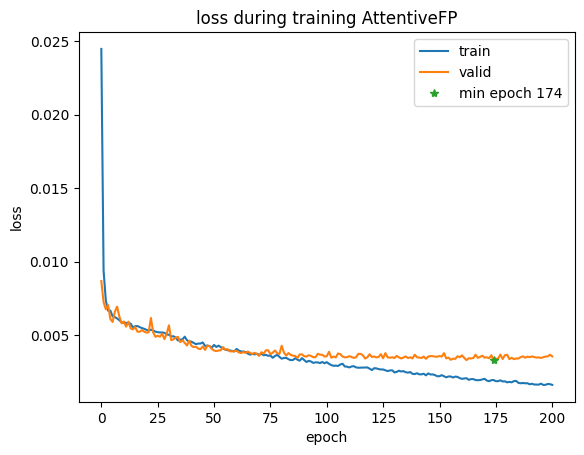

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.456  &0.397  &0.630  &0.585

Epoch:201 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 27 out of 30
Epoch:202 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 28 out of 30
Epoch:203 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 29 out of 30
Epoch:204 [Train] Loss: 0.002 | [Valid] Loss: 0.004	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at LD50_Zhu_scale/AttentiveFP_ST_0.yml
Model parameters:  3823507
Train time: 0.280+/-0.008 ms
best epoch: 174, min loss: 0.0033


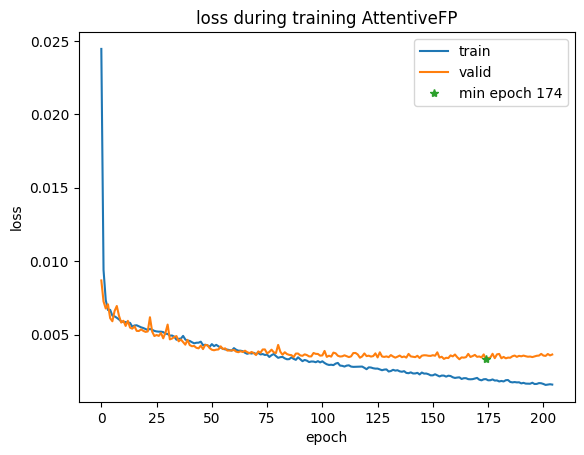

load pretrained model from  LD50_Zhu_scale/AttentiveFP_ST_0.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.444  &0.363  &0.603  &0.594


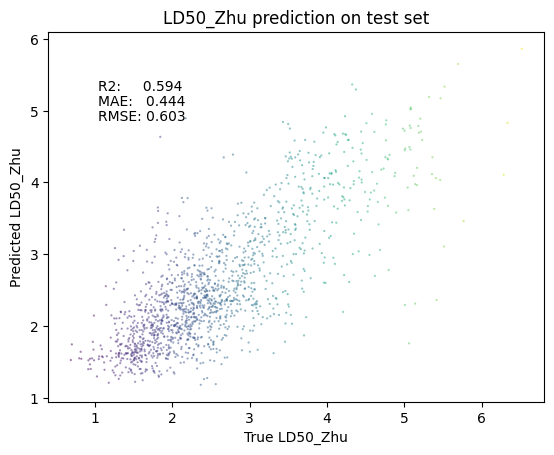



--> Train status saved at LD50_Zhu_scale/AttentiveFP_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.444 +/- 0.000 | 0.603 +/- 0.000 | 0.594 +/- 0.000 | 


Run # 1 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.026 | [Valid] Loss: 0.009	SAVE MODEL: loss: inf -> 0.009 | runtime: 0.275 ms
Epoch:1 [Train] Loss: 0.010 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.009 -> 0.007 | runtime: 0.282 ms
Epoch:2 [Train] Loss: 0.008 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 0.286 ms
Epoch:3 [Train] Loss: 0.007 | [Valid] Loss: 0.008	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 0.007 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.007 -> 0.006 | runtime: 0.273 ms
Epoch:5 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 0.276 ms
Epoch:6 [Train] Loss: 0.006 | [Valid] Loss: 0.006	EarlyStopping counte

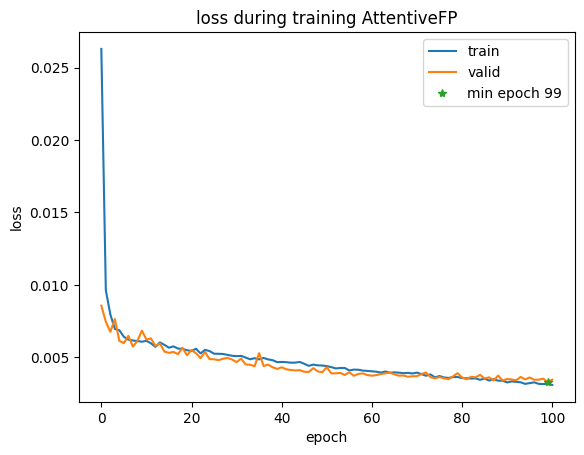

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.474  &0.384  &0.620  &0.598

Epoch:101 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 2 out of 30
Epoch:102 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 3 out of 30
Epoch:103 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 4 out of 30
Epoch:104 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 5 out of 30
Epoch:105 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 6 out of 30
Epoch:106 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 7 out of 30
Epoch:107 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 8 out of 30
Epoch:108 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 9 out of 30
Epoch:109 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 10 out of 30
Epoch:110 [Train] Loss: 0.003 | [Valid] Loss: 0.003	EarlyStopping counter: 11 out of 30
Epoch:111 [Train] Loss: 0.

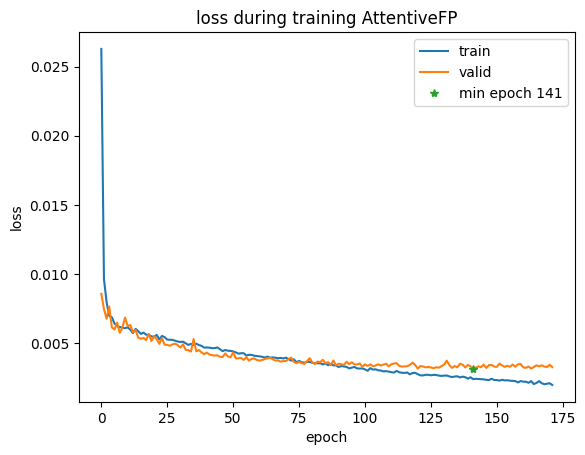

load pretrained model from  LD50_Zhu_scale/AttentiveFP_ST_1.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.450  &0.362  &0.602  &0.594


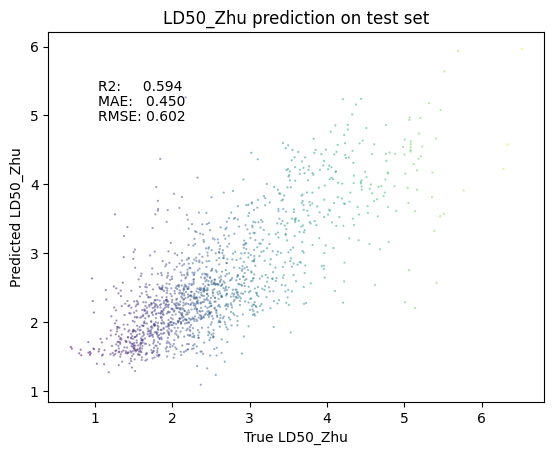



--> Train status saved at LD50_Zhu_scale/AttentiveFP_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.450 +/- 0.000 | 0.602 +/- 0.000 | 0.594 +/- 0.000 | 


Run # 2 for AttentiveFP ST	Model type:  AttentiveFP | Model parameters:  3823507
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.023 | [Valid] Loss: 0.008	SAVE MODEL: loss: inf -> 0.008 | runtime: 0.278 ms
Epoch:1 [Train] Loss: 0.009 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.008 -> 0.007 | runtime: 0.285 ms
Epoch:2 [Train] Loss: 0.008 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 0.285 ms
Epoch:3 [Train] Loss: 0.007 | [Valid] Loss: 0.007	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 0.007 | [Valid] Loss: 0.007	EarlyStopping counter: 2 out of 30
Epoch:5 [Train] Loss: 0.007 | [Valid] Loss: 0.007	EarlyStopping counter: 3 out of 30
Epoch:6 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.007 -> 0.006 | runtime: 0.272 ms
Epo

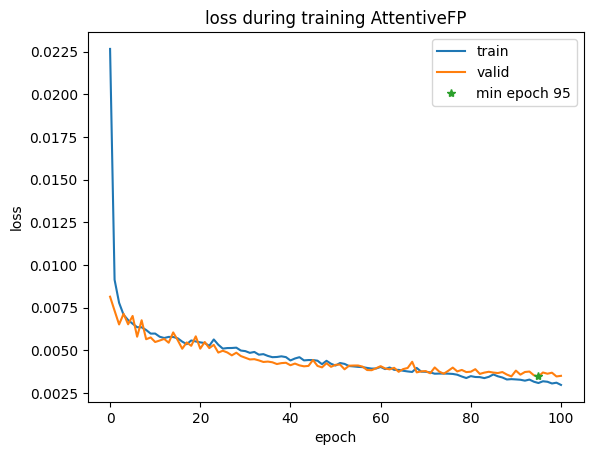

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.467  &0.391  &0.625  &0.591

Epoch:101 [Train] Loss: 0.003 | [Valid] Loss: 0.003	SAVE MODEL: loss: 0.003 -> 0.003 | runtime: 0.280 ms
Epoch:102 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 3 out of 30
Epoch:105 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 4 out of 30
Epoch:106 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 5 out of 30
Epoch:107 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 6 out of 30
Epoch:108 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 7 out of 30
Epoch:109 [Train] Loss: 0.003 | [Valid] Loss: 0.003	SAVE MODEL: loss: 0.003 -> 0.003 | runtime: 0.275 ms
Epoch:110 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 1 ou

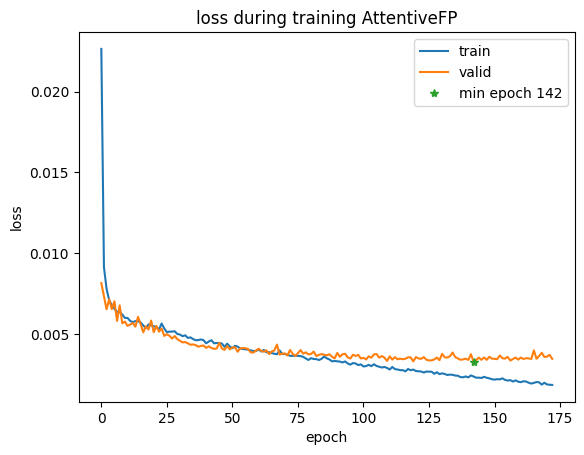

load pretrained model from  LD50_Zhu_scale/AttentiveFP_ST_2.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.458  &0.373  &0.611  &0.582


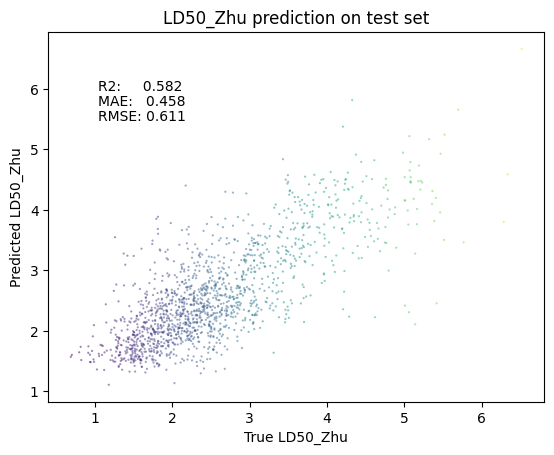



--> Train status saved at LD50_Zhu_scale/AttentiveFP_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.458 +/- 0.000 | 0.611 +/- 0.000 | 0.582 +/- 0.000 | 

repeated num # 3 idx 1 has the lowest loss from [0.0032618335960842744, 0.0032559256942674124, 0.003351400268989878]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.451 +/- 0.006 | 0.605 +/- 0.004 | 0.590 +/- 0.005 | 
 idx 1: | 0.450 +/- 0.000 | 0.602 +/- 0.000 | 0.594 +/- 0.000 | 

GIN
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN

Run # 0 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 0.008 | [Valid] Loss: 

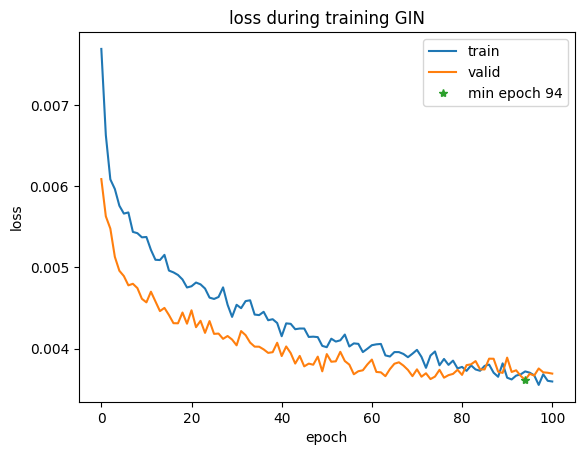

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.455  &0.411  &0.641  &0.570

Epoch:101 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 7 out of 30
Epoch:102 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 8 out of 30
Epoch:103 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 9 out of 30
Epoch:104 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 10 out of 30
Epoch:105 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 11 out of 30
Epoch:106 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 12 out of 30
Epoch:107 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 13 out of 30
Epoch:108 [Train] Loss: 0.003 | [Valid] Loss: 0.004	EarlyStopping counter: 14 out of 30
Epoch:109 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 15 out of 30
Epoch:110 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 16 out of 30
Epoch:111 [Train] Los

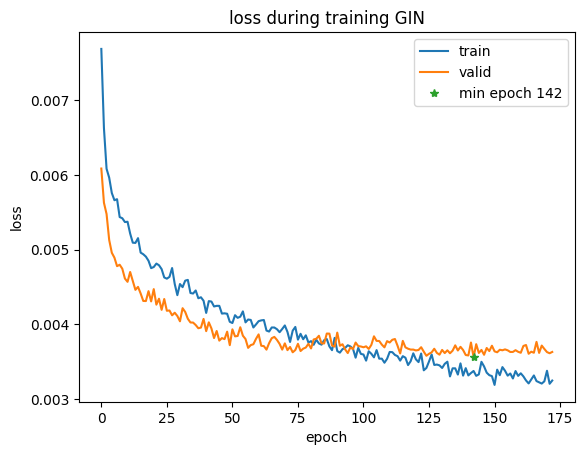

Pretrained model loaded
load pretrained model from  LD50_Zhu_scale/GIN_ST_0.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.428  &0.344  &0.586  &0.615


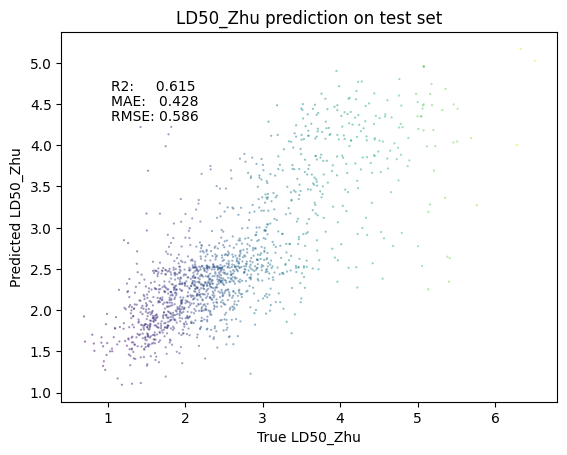



--> Train status saved at LD50_Zhu_scale/GIN_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.428 +/- 0.000 | 0.586 +/- 0.000 | 0.615 +/- 0.000 | 


Run # 1 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 0.120 | [Valid] Loss: 0.018	SAVE MODEL: loss: inf -> 0.018 | runtime: 2.066 ms
Epoch:1 [Train] Loss: 0.039 | [Valid] Loss: 0.011	SAVE MODEL: loss: 0.018 -> 0.011 | runtime: 2.051 ms
Epoch:2 [Train] Loss: 0.032 | [Valid] Loss: 0.011	SAVE MODEL: loss: 0.011 -> 0.011 | runtime: 2.041 ms
Epoch:3 [Train] Loss: 0.028 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.011 -> 0.008 | runtime: 2.071 ms
Epoch:4 [Train] Loss: 0.026 | [Valid] Loss: 0.009	EarlyStopping counter: 1 out of 30
Epoch:5 [Train] Loss: 0.025 | [Valid] Loss: 0.0

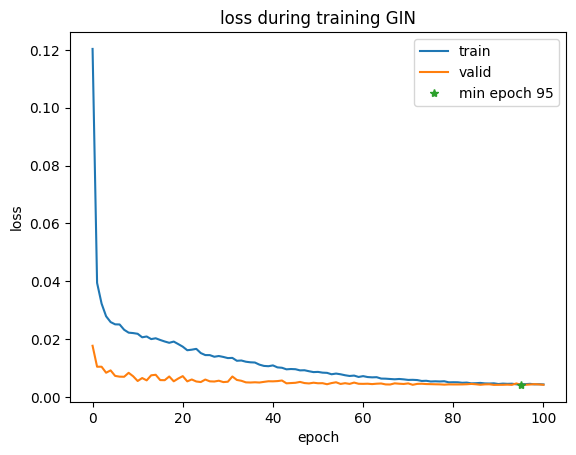

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.501  &0.474  &0.689  &0.504

Epoch:101 [Train] Loss: 0.004 | [Valid] Loss: 0.004	SAVE MODEL: loss: 0.004 -> 0.004 | runtime: 2.053 ms
Epoch:102 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.004 | [Valid] Loss: 0.005	EarlyStopping counter: 3 out of 30
Epoch:105 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 4 out of 30
Epoch:106 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 5 out of 30
Epoch:107 [Train] Loss: 0.004 | [Valid] Loss: 0.004	SAVE MODEL: loss: 0.004 -> 0.004 | runtime: 2.051 ms
Epoch:108 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 1 out of 30
Epoch:109 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 2 out of 30
Epoch:110 [Train] Loss: 0.004 | [Valid] Loss: 0.004	SAVE MODEL: loss: 0.004 -> 

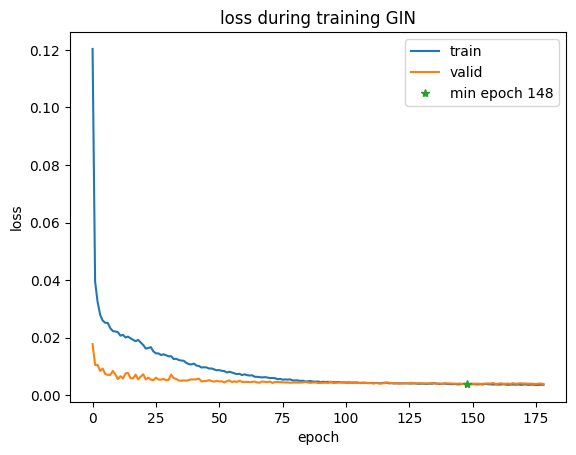

Pretrained model loaded
load pretrained model from  LD50_Zhu_scale/GIN_ST_1.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.453  &0.371  &0.609  &0.584


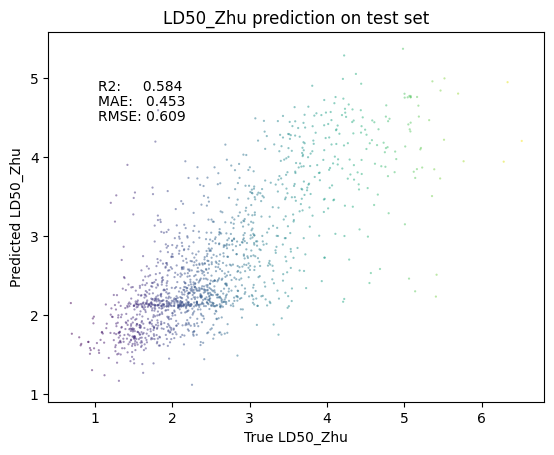



--> Train status saved at LD50_Zhu_scale/GIN_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.453 +/- 0.000 | 0.609 +/- 0.000 | 0.584 +/- 0.000 | 


Run # 2 for GIN ST	Downloading gin_supervised_contextpred_pre_trained.pth from https://data.dgl.ai/dgllife/pre_trained/gin_supervised_contextpred.pth...
Pretrained model loaded
Model type:  GIN | Model parameters:  1977165
Start training GIN...
Epoch:0 [Train] Loss: 0.020 | [Valid] Loss: 0.008	SAVE MODEL: loss: inf -> 0.008 | runtime: 2.050 ms
Epoch:1 [Train] Loss: 0.009 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.008 -> 0.007 | runtime: 2.078 ms
Epoch:2 [Train] Loss: 0.008 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.007 -> 0.006 | runtime: 2.054 ms
Epoch:3 [Train] Loss: 0.008 | [Valid] Loss: 0.006	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 0.007 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 2.055 ms
Epoch:5 [Train] Loss: 0.007 | [Valid] Loss: 0.0

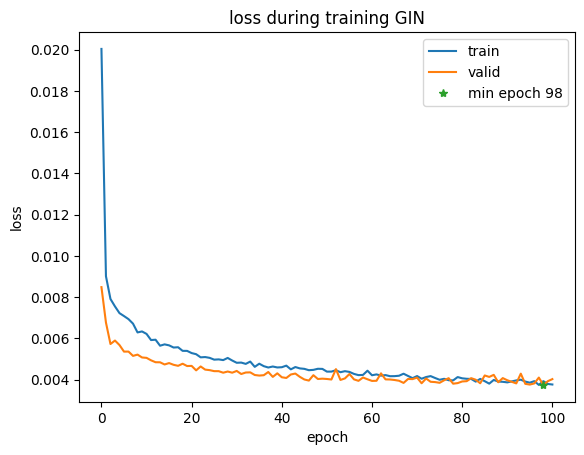

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.479  &0.447  &0.669  &0.532

Epoch:101 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 3 out of 30
Epoch:102 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 4 out of 30
Epoch:103 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 5 out of 30
Epoch:104 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 6 out of 30
Epoch:105 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 7 out of 30
Epoch:106 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 8 out of 30
Epoch:107 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 9 out of 30
Epoch:108 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 10 out of 30
Epoch:109 [Train] Loss: 0.004 | [Valid] Loss: 0.004	EarlyStopping counter: 11 out of 30
Epoch:110 [Train] Loss: 0.004 | [Valid] Loss: 0.004	SAVE MODEL: loss: 0.004 -> 0.004 | runtime: 2.060 ms
Epoch:11

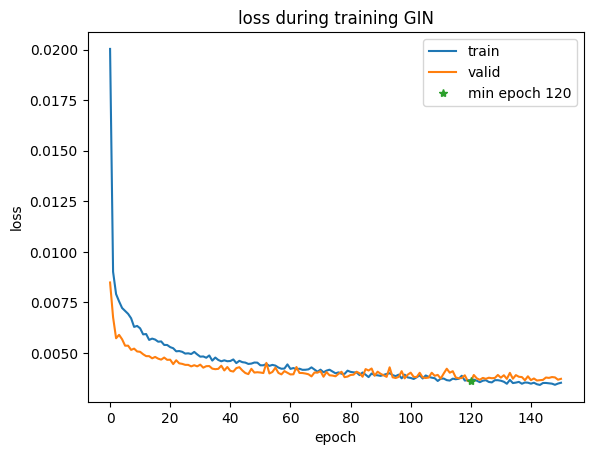

Pretrained model loaded
load pretrained model from  LD50_Zhu_scale/GIN_ST_2.pt
[Test] Loss: 0.003
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.437  &0.349  &0.591  &0.609


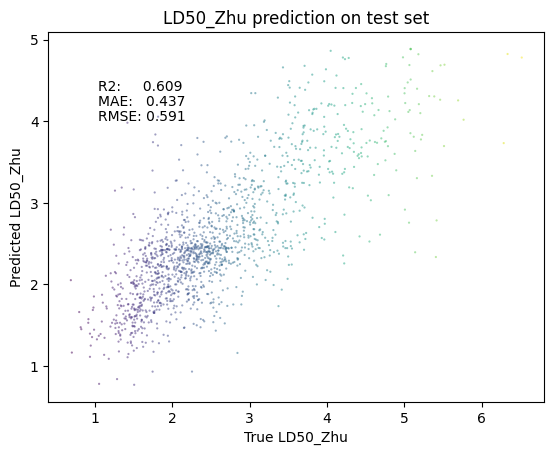



--> Train status saved at LD50_Zhu_scale/GIN_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.437 +/- 0.000 | 0.591 +/- 0.000 | 0.609 +/- 0.000 | 

repeated num # 3 idx 0 has the lowest loss from [0.0030869548294135823, 0.00333595992183879, 0.0031382450398837057]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.439 +/- 0.011 | 0.596 +/- 0.010 | 0.603 +/- 0.013 | 
 idx 0: | 0.428 +/- 0.000 | 0.586 +/- 0.000 | 0.615 +/- 0.000 | 

RNN
---> loader for ['LD50_Zhu']
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN
--> preparing data loader for model type  RNN

Run # 0 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 0.011 | [Valid] Loss: 0.009	SAVE MODEL: loss: inf -> 0.009 | runtime: 0.748 ms
Epoch:1 [Train] Loss: 0.008 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.009 -> 0.008 | runtime: 0.732 ms
Epoch:2

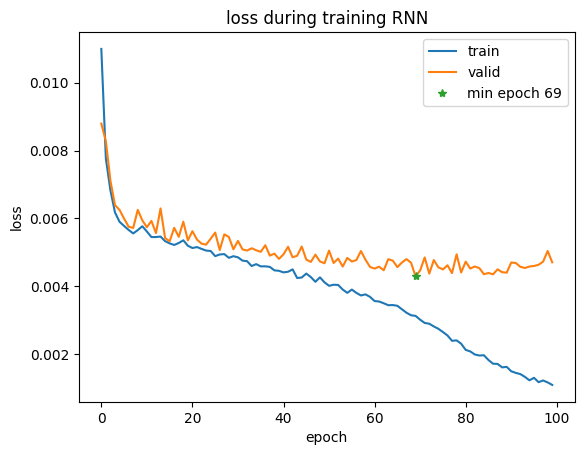

load pretrained model from  LD50_Zhu_scale/RNN_ST_0.pt
[Test] Loss: 0.004
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.509  &0.464  &0.682  &0.480


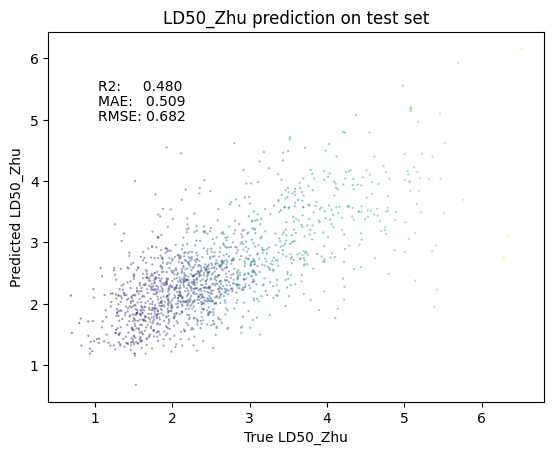



--> Train status saved at LD50_Zhu_scale/RNN_ST_0.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.509 +/- 0.000 | 0.682 +/- 0.000 | 0.480 +/- 0.000 | 


Run # 1 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 0.013 | [Valid] Loss: 0.009	SAVE MODEL: loss: inf -> 0.009 | runtime: 0.761 ms
Epoch:1 [Train] Loss: 0.008 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.009 -> 0.007 | runtime: 0.749 ms
Epoch:2 [Train] Loss: 0.006 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 0.742 ms
Epoch:3 [Train] Loss: 0.006 | [Valid] Loss: 0.007	EarlyStopping counter: 1 out of 30
Epoch:4 [Train] Loss: 0.006 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.007 -> 0.007 | runtime: 0.757 ms
Epoch:5 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.007 -> 0.006 | runtime: 0.767 ms
Epoch:6 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 0.768 ms

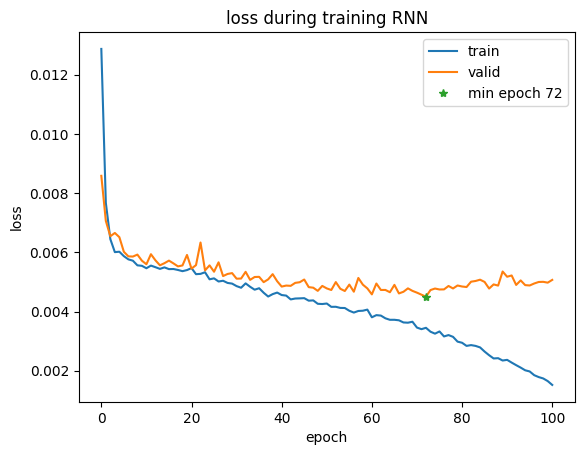

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.550  &0.564  &0.751  &0.410

Epoch:101 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 29 out of 30
Epoch:102 [Train] Loss: 0.001 | [Valid] Loss: 0.005	EarlyStopping counter: 30 out of 30
early stop

--> Train status saved at LD50_Zhu_scale/RNN_ST_1.yml
Model parameters:  3046533
Train time: 0.767+/-0.013 ms
best epoch: 72, min loss: 0.0045


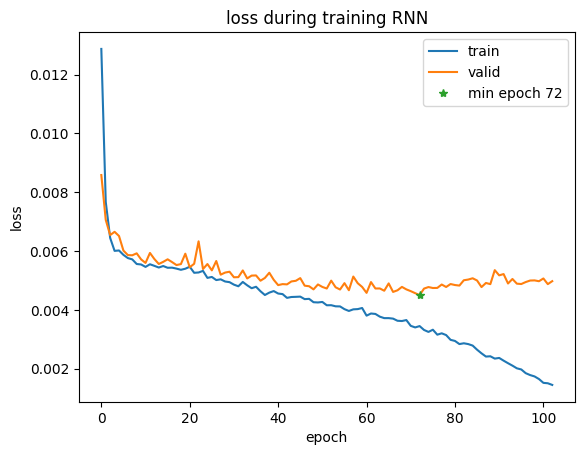

load pretrained model from  LD50_Zhu_scale/RNN_ST_1.pt
[Test] Loss: 0.004
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.498  &0.441  &0.664  &0.507


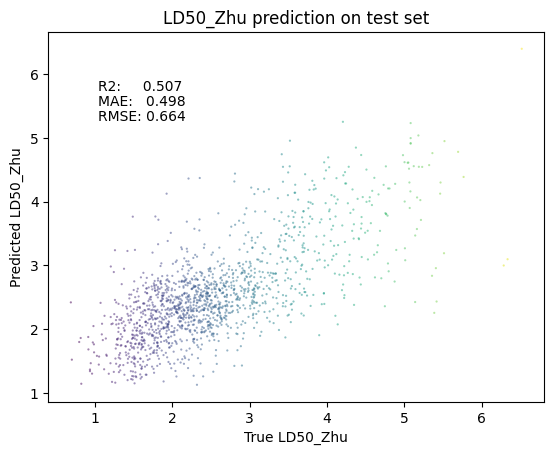



--> Train status saved at LD50_Zhu_scale/RNN_ST_1.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.498 +/- 0.000 | 0.664 +/- 0.000 | 0.507 +/- 0.000 | 


Run # 2 for RNN ST	Model type:  RNN | Model parameters:  3046533
Start training RNN...
Epoch:0 [Train] Loss: 0.015 | [Valid] Loss: 0.008	SAVE MODEL: loss: inf -> 0.008 | runtime: 0.768 ms
Epoch:1 [Train] Loss: 0.008 | [Valid] Loss: 0.008	SAVE MODEL: loss: 0.008 -> 0.008 | runtime: 0.761 ms
Epoch:2 [Train] Loss: 0.007 | [Valid] Loss: 0.007	SAVE MODEL: loss: 0.008 -> 0.007 | runtime: 0.763 ms
Epoch:3 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.007 -> 0.006 | runtime: 0.746 ms
Epoch:4 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 0.762 ms
Epoch:5 [Train] Loss: 0.006 | [Valid] Loss: 0.006	EarlyStopping counter: 1 out of 30
Epoch:6 [Train] Loss: 0.006 | [Valid] Loss: 0.006	SAVE MODEL: loss: 0.006 -> 0.006 | runtime: 0.768 ms

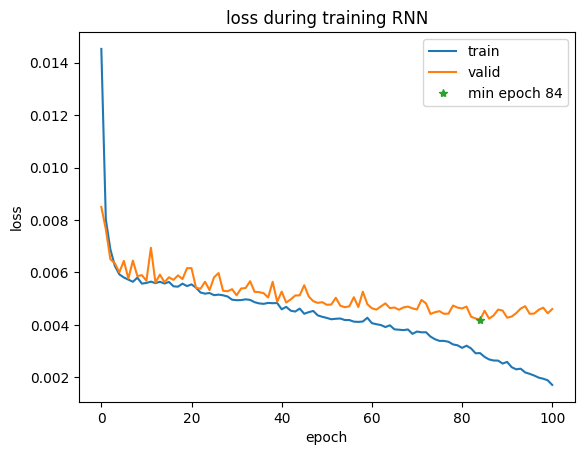

*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.546  &0.512  &0.716  &0.465

Epoch:101 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 17 out of 30
Epoch:102 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 18 out of 30
Epoch:103 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 19 out of 30
Epoch:104 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 20 out of 30
Epoch:105 [Train] Loss: 0.002 | [Valid] Loss: 0.005	EarlyStopping counter: 21 out of 30
Epoch:106 [Train] Loss: 0.001 | [Valid] Loss: 0.004	EarlyStopping counter: 22 out of 30
Epoch:107 [Train] Loss: 0.001 | [Valid] Loss: 0.005	EarlyStopping counter: 23 out of 30
Epoch:108 [Train] Loss: 0.001 | [Valid] Loss: 0.005	EarlyStopping counter: 24 out of 30
Epoch:109 [Train] Loss: 0.001 | [Valid] Loss: 0.005	EarlyStopping counter: 25 out of 30
Epoch:110 [Train] Loss: 0.001 | [Valid] Loss: 0.005	EarlyStopping counter: 26 out of 30
Epoch:111 [Train] 

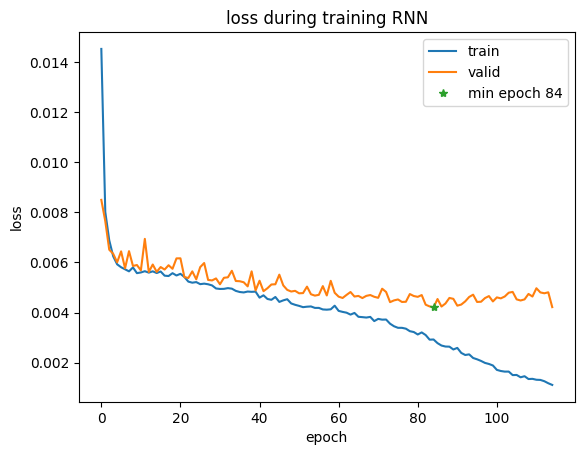

load pretrained model from  LD50_Zhu_scale/RNN_ST_2.pt
[Test] Loss: 0.004
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.493  &0.442  &0.665  &0.506


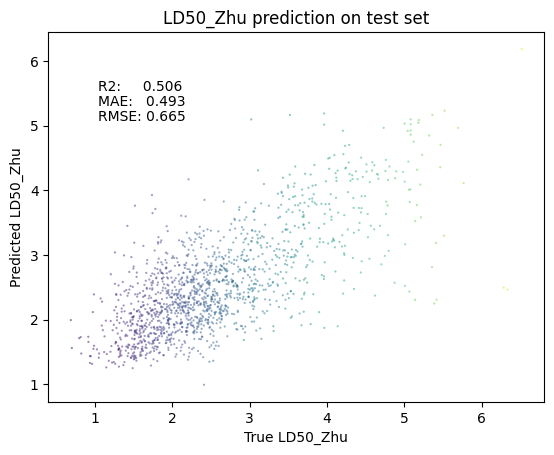



--> Train status saved at LD50_Zhu_scale/RNN_ST_2.yml
Finished training

******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.493 +/- 0.000 | 0.665 +/- 0.000 | 0.506 +/- 0.000 | 

repeated num # 3 idx 1 has the lowest loss from [0.004173140410401972, 0.00395829627541327, 0.003968775151303756]
******************** LD50_Zhu ******************** 
		 mae 	 	 rmse 	 	 r2 	 
	| 0.500 +/- 0.007 | 0.670 +/- 0.008 | 0.498 +/- 0.012 | 
 idx 1: | 0.498 +/- 0.000 | 0.664 +/- 0.000 | 0.507 +/- 0.000 | 



In [ ]:
repeat_time = 3
for name in names_reg[3:]:
    run_type = 'ST'
    trn, val, tst = collect_data_10_27([name])
    for scale_task in [False, True]:
        if scale_task == False: folder_name = f'{name}_no_scale'
        else: folder_name = f'{name}_scale'
        make_path(folder_name)
        print('\n\n\n\n\ninfo will be saved at', folder_name)
        trn, val, tst, dict_scale = scale(trn, val, tst, scale_task=scale_task)

        for model_type in model_types:
            print(model_type)
            config = get_config(model_type, [name])
            config['scale_dict'] = dict_scale
            trn_l, val_l, tst_l, vocab = get_multi_loader(trn, val, tst, config)
            if vocab != None and config['vocab'] == None:
                config['vocab'] = vocab # update config vocab info
                print('RNN, no vocab, use data update | vocab len:', len(vocab))

            perfs = [] # a list to store the performance outputted from the model
            for i in range(repeat_time):
                print(f'\nRun # {i} for {model_type} {run_type}', end='\t')
                save_dir = f'{folder_name}/{model_type}_{run_type}_{i}'
                config['model_path']  = save_dir + '.pt'
                config['config_path'] = save_dir + '.yml'

                try: # try open yml file, if file exists, and no need train
                    with open(config['config_path'], 'r') as f:
                        data = yaml.safe_load(f)
                    if data != None:
                        p = yml_report(data); print(' pre data loaded')
                        eval_perf_list(p, name, metrics_dict={})
                except:  # model was not trained yet, train the model
                    models = PRED(**config)
                    p = models.train(trn_l, val_l, tst_l)
                    eval_perf_list(p, name, metrics_dict={})
                perfs.append(p)
            eval_perf_list(perfs, name)

In [ ]:
eval_perf_list([p], name[:2], metrics_dict=d)

repeated num # 1
******************** CYP2C19_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.776 +/- 0.000 | 0.762 +/- 0.000 | 0.847 +/- 0.000 | 


repeated num # 1
******************** CYP2D6_Veith ******************** 
		 acc 	 	 f1 	 	 auc 	 
	| 0.843 +/- 0.000 | 0.315 +/- 0.000 | 0.815 +/- 0.000 | 




In [42]:
l = [2076.2451171875, 28.62302589416504]
torch.stack(torch.Tensor(l))

TypeError: ignored

In [47]:
l = [1.0, 2.0]
torch.Tensor(l) * torch.Tensor([1.0, 2.0]) + torch.Tensor([1.0, 2.0])

tensor([2., 6.])